In [1]:
import os
import sys
import time
import pickle
import string
from datetime import datetime
from datetime import timedelta
from itertools import chain, cycle
import collections
from pprint import pprint
from io import StringIO
import pathlib
import sqlite3

import numpy as np
import pandas as pd
import dask.dataframe as dd
from pandas.tools.plotting import parallel_coordinates
import matplotlib.pyplot as plt

#import urllib
#import webbrowser
#import codecs
from bs4 import BeautifulSoup
from xml.dom import minidom
from xml.etree import ElementTree as ET
#from lxml import etree as ET #Supports xpath syntax
import xmltodict 

import nltk
import re
import Levenshtein
import networkx as nx
import json

#from nominatim import Nominatim
#from mpl_toolkits.basemap import Basemap   #http://matplotlib.org/basemap/api/basemap_api.html
from matplotlib import cm
import geopy.geocoders as gg
from geopy.geocoders import Nominatim
import geopandas as gpd

#https://github.com/jupyter-widgets/ipyleaflet
#https://ipyleaflet.readthedocs.io/en/latest/
import ipyleaflet 
#from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, WMSLayer, Marker, MarkerCluster

import folium
import folium.plugins
#from folium.plugins import MarkerCluster
#from folium.plugins import FastMarkerCluster


#import plotly as py
#import plotly.graph_objs as go
#import plotly.figure_factory as ff

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display

In [2]:
df_lemmas = pd.read_pickle('./df_lemmas.pkl')

In [123]:
df_lemmas.info(verbose=True, null_counts=True, memory_usage='deep') #, max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416499 entries, 0 to 2416498
Data columns (total 52 columns):
Bundesland               1316889 non-null object
Bundesland_idno          1316889 non-null object
Gemeinde                 1198447 non-null object
Großregion               1296722 non-null object
Großregion_idno          1225463 non-null object
Kleinregion              1286463 non-null object
Kleinregion_idno         1209145 non-null object
Ort                      1198447 non-null object
Ort_idno                 1198447 non-null object
archiv                   2416419 non-null object
bibl                     1719656 non-null object
certainty                25631 non-null object
cit_def                  461023 non-null object
cit_interp               353677 non-null object
cit_note                 111690 non-null object
cit_pRef                 79913 non-null object
cit_quote                704560 non-null object
cit_re                   113327 non-null object
cit_ref       

In [4]:
df_lemmas.columns

Index(['Bundesland', 'Bundesland_idno', 'Gemeinde', 'Großregion',
       'Großregion_idno', 'Kleinregion', 'Kleinregion_idno', 'Ort', 'Ort_idno',
       'archiv', 'bibl', 'certainty', 'cit_def', 'cit_interp', 'cit_note',
       'cit_pRef', 'cit_quote', 'cit_re', 'cit_ref', 'cit_type', 'date',
       'entry_id', 'etym', 'filename', 'fragebogenNummer',
       'hauptlemma_normalized', 'hauptlemma_orig', 'hauptlemma_unique',
       'nebenlemma_normalized', 'nebenlemma_orig', 'nebenlemma_unique',
       'note_anmerkung', 'note_diverse', 'note_notabene', 'orig_placeName',
       'paragraph', 'placeName_id', 'pos', 'quelle', 'quelleBearbeitet',
       'seite', 'simple_placeName', 'tustep', 'usg_corresp', 'verweise',
       '_coordinates', '_location', '_typist', '_drawer', '_fragebogen',
       '_bestlemma', '_year'],
      dtype='object')

In [5]:
df_lemmas.head()

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,archiv,...,tustep,usg_corresp,verweise,_coordinates,_location,_typist,_drawer,_fragebogen,_bestlemma,_year
0,None,None,None,None,None,None,None,None,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",...,"(diaun,)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,NaN
1,None,None,None,None,None,None,None,None,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",...,"(diaun,)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,NaN
2,None,None,None,None,None,None,None,None,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",...,"(diaun,)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,NaN
3,None,None,None,None,None,None,None,None,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",...,"(tib,)",None,None,None,None,Barbara Piringer,HK 154,Systematic,tib,NaN
4,None,None,None,None,None,None,None,None,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",...,"(tib,)",None,None,None,None,Barbara Piringer,HK 154,Systematic,tib,NaN


In [6]:
entry_info = ['filename', 'entry_id']

regions_info = ['Bundesland', 
                'Bundesland_idno', 
                'Gemeinde', 
                'Großregion', 
                'Großregion_idno', 
                'Kleinregion', 
                'Kleinregion_idno',
                'Ort', 
                'Ort_idno',
                'simple_placeName',
                'orig_placeName',
                'placeName_id', 
                'usg_corresp',]

lemmas_info = ['date',
               'hauptlemma_normalized', 
               'hauptlemma_orig', 
               'hauptlemma_unique',
               'nebenlemma_normalized',
               'nebenlemma_orig', 
               'nebenlemma_unique', 
               'tustep',
               'etym', 
               'pos',]

ref_info = ['verweise',
            'archiv',
            'quelle',
            'quelleBearbeitet', 
            'seite', 
            'fragebogenNummer', 
            'paragraph', 
            'bibl',]

cit_info = ['cit_def',
            'cit_interp',
            'cit_note',
            'cit_pRef',
            'cit_quote',
            'cit_re',
            'cit_ref',
            'cit_type', 
            'certainty',]

note_info = ['note_anmerkung',
             'note_diverse',
             'note_notabene',]

# we are creating new fields based on the existing ones, in this notebook

created = ['_form',   
           '_typist', 
           '_drawer', 
           '_fragebogen',
           '_bestlemma',
           '_coordinates',
           '_location',
           '_year']

### Creating a field for the standardized reference lemma for each entry

In [7]:
bestlemma = []
for idx in df_lemmas.index:
    if df_lemmas.hauptlemma_normalized.iloc[idx]:
        bestlemma.append(df_lemmas.hauptlemma_normalized.iloc[idx])
    elif df_lemmas.hauptlemma_unique.iloc[idx]:
        bestlemma.append(df_lemmas.hauptlemma_unique.iloc[idx])
    elif df_lemmas.hauptlemma_orig.iloc[idx]:
        bestlemma.append(df_lemmas.hauptlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_normalized.iloc[idx]:
        bestlemma.append(df_lemmas.nebenlemma_normalized.iloc[idx])
    elif df_lemmas.nebenlemma_orig.iloc[idx]:
        bestlemma.append(df_lemmas.nebenlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_unique.iloc[idx]:
        bestlemma.append(df_lemmas.nebenlemma_unique.iloc[idx])
    else:
        bestlemma.append(None)

        
df_lemmas['_bestlemma'] = bestlemma
del(bestlemma)

### Processing locations

In [8]:
df_lemmas[regions_info].info(verbose=True, null_counts=True, memory_usage='deep') #, max_cols=100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416499 entries, 0 to 2416498
Data columns (total 13 columns):
Bundesland          1316889 non-null object
Bundesland_idno     1316889 non-null object
Gemeinde            1198447 non-null object
Großregion          1296722 non-null object
Großregion_idno     1225463 non-null object
Kleinregion         1286463 non-null object
Kleinregion_idno    1209145 non-null object
Ort                 1198447 non-null object
Ort_idno            1198447 non-null object
simple_placeName    395816 non-null object
orig_placeName      1334384 non-null object
placeName_id        1316887 non-null object
usg_corresp         16675 non-null object
dtypes: object(13)
memory usage: 1.3 GB


Expanding abbreviations for the Bundesland names

In [124]:
df_lemmas[regions_info].head(10)

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,simple_placeName,orig_placeName,placeName_id,usg_corresp
0,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,Chur,None,None,None
2,None,None,None,None,None,None,None,None,None,Chur,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Steiermark,3,Lobmingtal,sbair.ObSt.,3.1,mittl.obMurt.,3.1d,Kleinlobming,3.1d03,None,Gr.Lobming St.,sigle:3.1d03,None
7,None,None,None,None,None,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,None,None,None


In [10]:
print(set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.Ort.dropna().index)))
print(set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.orig_placeName.dropna().index)))

set()
set()


Locations for the detailed records  
(Those with: Bundesland, Bundesland_idno, Gemeinde, Großregion, Großregion_idno, Kleinregion, Kleinregion_idno,	Ort, Ort_idno)  

In [11]:
#https://geopy.readthedocs.io/en/stable/#usage-with-pandas

geolocator1 = gg.Nominatim(user_agent="test_application")
geolocator2 = gg.BANFrance()
geolocator3 = gg.DataBC()
geolocator4 = gg.GeoNames(country_bias='AT', username='rsouza')

Testing Geolocator

In [11]:
logradouro = 'Matrei , Osttirol, Austria'
print(logradouro)
location = geolocator1.geocode(logradouro)
print(location.address)
address = location.address
print((location.latitude, location.longitude))
latitude, longitude = location.latitude, location.longitude
print(location.raw)

Matrei , Osttirol, Austria
Matrei in Osttirol, Lienz, Tirol, 9971, Österreich
(47.0, 12.5333333)
{'place_id': 198850017, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 1019871, 'boundingbox': ['46.9033594', '47.1579908', '12.3457362', '12.6152155'], 'lat': '47', 'lon': '12.5333333', 'display_name': 'Matrei in Osttirol, Lienz, Tirol, 9971, Österreich', 'class': 'boundary', 'type': 'administrative', 'importance': 0.568168210072538, 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_boundary_administrative.p.20.png'}


Resolving abbreviations and the findability of the addresses:

In [27]:
#import mysql table
orts_mysql = pd.read_csv('./geonames/ort.csv', sep=';')
orts_mysql.drop([c for c in orts_mysql.columns if c not in ['nameKurz', 'nameLang']], axis=1, inplace=True)
orts_mysql.drop(orts_mysql[orts_mysql.nameKurz == orts_mysql.nameLang].index, axis=0, inplace=True)
orts_mysql.head()

,nameKurz,nameLang
0,AflenzKurort,Aflenz Kurort
1,Afritz/S.,Afritz am See
4,Aigen/E.,Aigen im Ennstal
5,Aigen/R.,Aigen bei Raabs
6,Alberndf./P.,Alberndorf im Pulkautal


In [28]:
orts_mysql.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8513 entries, 0 to 19944
Data columns (total 2 columns):
nameKurz    8513 non-null object
nameLang    8513 non-null object
dtypes: object(2)
memory usage: 199.5+ KB


Checking names that are present in the field "simple_placeName"  

In [31]:
len(set(df_lemmas.simple_placeName.values).intersection(set(orts_mysql.nameKurz.values)))

287

Creating a dictionary for expanding abbreviations

In [125]:
abbreviations = collections.OrderedDict({'W.': 'Wien, Austria',
                                         'STir.': 'Südtirol, Austria',
                                         'OTir.': 'Osttirol, Austria',
                                         'NTir.': 'Tirol, Austria',
                                         'KÄ.': 'Kärnten, Austria',
                                         'ST.': 'Estíria, Áustria',
                                         'SA.': 'Salzburg, Austria',
                                         'OÖ': 'Oberösterreich, Austria',
                                         'NÖ': 'Niederösterreich, Austria',
                                         'BGL.': 'Burgenland, Austria',
                                         'TIR.': 'Tirol',
                                         'BÖW': 'Bohemia, Czech Republic',
                                         'SBÖ': 'Südböhmen, Czech Republic',
                                         'SMÄ': 'Sudmähren, Czech Republic',
                                         'It.': 'Italy',
                                         '(Tschech.)': 'Czech Republic',
                                         'Wallern': 'Volary',
                                         'Egerl.': 'Egerland.',
                                         'Egerld.': 'Egerland.',
                                         'Königswerth Egerland.':'Königswerth, Cheb, Tchéquia',
                                         'Oschelin Egerland.': 'Oschelin, Cheb, Tchéquia',
                                         'Dobrzan Egerland.': 'Dobrzan, Cheb, Tchéquia',
                                         'Plan Egerland.': 'Plánská Huť, Cheb, Tchéquia' ,
                                         'Sangerbg. Egerland.': 'Cheb, Tchéquia',
                                         'Asch Egerland.': 'Aš, Cheb, Tchéquia',
                                         'Nýrany [Nürschan':'Nýřany, Nýřany, Tchéquia',
                                         'WUng.': 'West Hungary',
                                        })

ortsfrommysql = set(orts_mysql.nameKurz.values)

In [73]:
def improve_location(place):
    if place in ortsfrommysql:
        place = orts_mysql.nameLang.iloc[orts_mysql[orts_mysql.nameKurz == place].index].values[0]
        print(place)

    for key in abbreviations.keys():
        if str(key).upper() in place.upper():
            place = place.upper().replace(str(key).upper(), abbreviations[key]).title()
    
    place = place.translate(str.maketrans('', '', string.punctuation))
    return(place)

In [75]:
def get_coordinates(place, geolocator):
    location = None
    try:
        location = geolocator.geocode(improve_location(place))
    except:
        print("location wasn't found")
        return None
    if location:
        return (location.longitude, location.latitude), location.address
    else:
        return None

In [76]:
df_lemmas[df_lemmas.Ort.notnull()].index

Int64Index([      6,      37,      38,      49,      55,      73,      74,
                 76,      77,      78,
            ...
            2416484, 2416485, 2416488, 2416489, 2416490, 2416494, 2416495,
            2416496, 2416497, 2416498],
           dtype='int64', length=1198447)

In [80]:
## If is there an existing dictionary from previous runs:
with open('./dict_places.pkl', 'rb') as f:
    dict_places = pickle.load(f)
## if not
# places = {}

In [81]:
coordinates = []
for idx in df_lemmas[df_lemmas.Ort.notnull()].index:
    place = '{0}, Austria'.format(df_lemmas.Ort.iloc[idx],)
    if place in dict_places:
        coordinates.append(dict_places[place])
        #print('location from dict -', dict_places_detailed[place][1])
    else:
        location = get_coordinates(place, geolocator1)
        dict_places[place] = location
        coordinates.append(location)
        print('location from geolocator -', location)
        print(idx)
        time.sleep(2)

Examining and fixing null entries on the dictionary

In [83]:
#[(k,v) for k,v in dict_places.items() if v == None]
[(k,v) for k,v in dict_places.items() if v[1] == 'Österreich']

[]

In [95]:
dict_places['Oberwölz Stadt, Austria'] = ((14.301851, 47.200745), 'Oberwölz, Bromach, Oberwölz, Murau, Estíria, 8832, Österreich')
dict_places['Partschins, Parcines, Austria'] = ((11.039787, 46.710361), 'Parcines 39020 Bolzano, Italia')
dict_places['Vordernberg, Austria'] = ((14.990903, 47.493379), 'Gemeinde Vordernberg, 8794, Österreich')
dict_places['Wallern im Burgenland, Austria'] = ((16.934542, 47.729349), 'Gemeinde Wallern im Burgenland 7151 Wallern im Burgenland, Österreich')
dict_places['Göttlesbrunn-Arbesthal, Austria'] = ((16.708165, 48.071112), 'Göttlesbrunn-Arbesthal, Österreich')
dict_places['Lieboch, Austria'] = ((15.336402, 46.980412), 'Lieboch, Österreich')
dict_places['Thiersee $Tiersee$, Austria'] = ((12.117979, 47.595014), 'Thiersee, Österreich')
dict_places['Lichtent. (im 9.Bz.) in Gm. Wien , Austria'] = ((16.356915, 48.228553), 'Lichtental, 1090, Wien, Österreich')
dict_places['Lanzendf. in Gm. Mistelb.  Niederösterreich , Austria'] = ((16.438422, 48.108752), 'Lanzendorf,  Niederösterreich, Österreich')
dict_places['Favoriten (10.Bz.) in Gm. Wien , Austria'] = ((16.382580, 48.160418), 'Favoriten, 1100 Wien, Österreich')
dict_places['Weident. WRum. , Austria'] = ((13.240165, 48.273040), 'Weidenthal, 4950, Österreich')
dict_places['Fusch  Salzburg , Austria'] = ((12.827896, 47.225081), 'Gemeinde Fusch an der Großglocknerstraße, 5672 Fusch, Österreich')
dict_places['Wallern BöW'] = ((13.864842, 49.075673), 'Prachatice, Tchéquia')
dict_places['Schöllschitz Brünn (Tschech.)'] = ((16.579251, 49.117391), 'Želešice, Tchéquia')


Saving the dictionary

In [96]:
with open('./dict_places.pkl', 'wb') as f:
    pickle.dump(dict_places, f)

Filling the dataframe columns with the collected geographical information

In [86]:
df_lemmas['_coordinates'] = None
df_lemmas.loc[df_lemmas[df_lemmas.Ort.notnull()].index, '_coordinates'] = [x[0] if x else None for x in coordinates]

In [87]:
df_lemmas['_location'] = None
df_lemmas.loc[df_lemmas[df_lemmas.Ort.notnull()].index, '_location'] = [x[1] if x else None for x in coordinates]

Finding locations for the non-detailed records (without the "ort" field - mostly outside Austria)  
Excluding the ids which were already geotagged (idx3).

In [88]:
#simple_placeName    395816 non-null object
#orig_placeName      1334384 non-null object
#placeName_id        1316887 non-null object
#usg_corresp         16675 non-null object

idx1 = df_lemmas[df_lemmas.simple_placeName.notnull()].index
idx2 = df_lemmas[df_lemmas.orig_placeName.notnull()].index
idx3 = df_lemmas[df_lemmas.Ort.notnull()].index
idxs = set(idx1).union(set(idx2)) 
idxs = list(idxs -set(idx3))

print(len(idxs))

df_lemmas.iloc[idxs][['simple_placeName','orig_placeName','placeName_id',]].head(10)

531753


,simple_placeName,orig_placeName,placeName_id
1,Chur,None,None
2,Chur,None,None
1048579,Wallern BöW,None,None
1048580,Haid Egerl.,None,None
1048581,Neulosimt. Egerl.,None,None
2097153,Rosent. SBö.,None,None
2097154,Rosent. SBö.,None,None
2097163,Smilau Igl. (Tschech.),None,None
12,Spital St.,None,None
2097164,Smilau Igl. (Tschech.),None,None


In [122]:
df_lemmas.iloc[idxs]['simple_placeName'].value_counts().to_excel('./df_placesIII.xls')

In [103]:
coordinates2 = []
for idx in idxs:
    place = None
    if df_lemmas.simple_placeName.iloc[idx]:
        place = df_lemmas.simple_placeName.iloc[idx]
    elif df_lemmas.orig_placeName.iloc[idx]:
        place = df_lemmas.orig_placeName.iloc[idx]
    if place in dict_places:
        coordinates2.append(dict_places[place])
        print('location from dict -', place, dict_places[place])
    else:
        location = get_coordinates(place, geolocator1)
        print('location from geolocator -', place, location)
        dict_places[place] = location
        coordinates2.append(location)
        print(idx)
        time.sleep(2)

location from dict - Chur ((9.5254066, 46.855515), 'Chur, Plessur, Graubünden/Grigioni/Grischun, Schweiz/Suisse/Svizzera/Svizra')
location from dict - Chur ((9.5254066, 46.855515), 'Chur, Plessur, Graubünden/Grigioni/Grischun, Schweiz/Suisse/Svizzera/Svizra')
location from dict - Wallern BöW ((13.864842, 49.075673), 'Prachatice, Tchéquia')
location from geolocator - Haid Egerl. None
1048580
location from geolocator - Neulosimt. Egerl. None
1048581
location from geolocator - Rosent. SBö. None
2097153
location from dict - Rosent. SBö. None
location from geolocator - Smilau Igl. (Tschech.) None
2097163
location from dict - Spital St. ((16.0682057, 47.4850128), 'Spital, Hartberg-Fürstenfeld, Steiermark, 7421, Österreich')
location from dict - Smilau Igl. (Tschech.) None
location from geolocator - Kainb.St. None
15
location from geolocator - Drahowitz Egerl. None
1048592
location from geolocator - Gr.Rammerschl. SBö. None
1048593
location from geolocator - Nonnbg. None
18
location from geol

location from geolocator - Kuttenplan Egerl. None
181
location from geolocator - Mies/M. Egerl. None
182
location from dict - Dobrzan Egerld. None
location from geolocator - BöW ((15.4749544, 49.8167003), 'Česko')
1048759
location from dict - Gott. ((-1.221628, 60.1973422), 'Gott, Shetland Islands, Scotland, ZE2 9SE, UK')
location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - Kaplitz SBö. None
1048763
location from geolocator - Pratsch SMä. None
189
location from dict - Plattetschl. BöW None
location from geolocator - Dreiz.Gm., SI (It.) None
1048764
location from dict - Pulkaut. in NÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Dobrzan Egerld. None
location from geolocator - Königsbg. None
1048772
location from geolocator - Klamm b. Breitenstn.; Ma.Trost None
1048773
location from dict - (Umg./Bz.) Braunau OÖ None
location from geolocator - Ottau SBö. None
2097350
locat

location from dict - Muttersdf. Egerl. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from geolocator - Wilhelmsdf.NÖ None
351
location from geolocator - Burg Wels OÖ ((14.0282636536646, 48.156659), 'Burg Wels, 13, Burggasse, Innere Stadt, Neustadt, Wels, Oberösterreich, 4600, Österreich')
352
location from geolocator - Enzenreut NÖ None
353
location from dict - Hohenfurth SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Hohenfurth SBö. None
location from geolocator - W. ? ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
2097517
location from geolocator - Wallern ((13.8883971, 48.9095977), 'Volary, okres Prachatice, Jihočeský kraj, Jihozápad, Česko')
2097518
location from geolocator - Ottenschlag ((15.1912727927612, 48.42880455), 'Gemeinde Ottenschlag, Bezirk Zwettl, Niederösterreich, 3631, Österreich')
2097519
location from geolocator

location from geolocator - Steining/ Putzleinsdf. None
1049087
location from dict - Pust. None
location from geolocator - Sangerbg. Egerl. None
1049092
location from geolocator - Defr. ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
517
location from geolocator - Reichenau Egerl. None
1049093
location from geolocator - Egerl. bzw. Einzelorte im Egerl. None
1049096
location from dict - Stadln BöW None
location from geolocator - Jir. ((14.1141599, 49.3256153), 'Jiher, Písek, okres Písek, Jihočeský kraj, Jihozápad, 39701, Česko')
1049098
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from geolocator - uInnt. None
1049100
location from geolocator - Sarmingstein ((14.9418892, 48.2310799), 'Sarmingstein, Perg, Oberösterreich, 4382, Österreich')
2097675
location from geolocator - Hochnonsberg None
2097677
location from geolocator - Ma.Kulm Egerl. None
2097678
location from geolocator - Obpzg. None
104

location from geolocator - Maurenzen BöW None
2097820
location from geolocator - Stuben BöW None
2097821
location from geolocator - Dt.Reichenau SBö. None
2097822
location from dict - Plattetschl. BöW None
location from geolocator - Hüttenhf. BöW ^#^# ON/Gm.? None
2097824
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Ottau SBö. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from geolocator - Weyer-Gaflenz Oö. None
680
location from dict - Hohenfurth SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - Pr. ((14.446459273258, 50.0596288), 'Hlavní město Praha, Praha, Česko')
2097847
location from geolocator - A. ((44.6736646, 40.7696272), 'Հայաստան')
2097848
location from dict - S. ((13.057954916199, 47.8028273), 'Salzburg, 5020, Österreich')
location from geolocator - R. ((26.5208033, 51.2074112), 'Рівненська область, Україна')
2097850
location from dict - (Umg./Bz.) Braunau OÖ None
locatio

location from dict - Kuschwarda BöW None
location from dict - Egerl. bzw. Einzelorte im Egerl. None
location from dict - Plan Egerld. None
location from dict - mPulkaut. in NÖ None
location from geolocator - Frauent. BöW None
846
location from dict - mPulkaut. in NÖ None
location from geolocator - NÖ (o.O.) None
2097993
location from geolocator - DR. ((6.6368423, 52.9067922), 'Drenthe, Nederland')
2097996
location from dict - SMä. None
location from geolocator - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
2097997
location from dict - Gr.Tajax SMä. None
location from dict - Sonnbg. SBö. None
location from dict - Lagau SBö. None
location from geolocator - Oberplan BöW None
860
location from dict - Unterwuldau in Gm. Unter-Moldau SBö. None
location from dict - Unterwuldau in Gm. Unter-Moldau SBö. None
location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Pulkaut. in NÖ None
location from dict - Hoh

location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Defr. ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Gr.Tajax SMä. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Sonnbg. SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
locati

location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Königswerth Egerld. None
location from dict - Plattetschl. BöW None
location from geolocator - Schindelhöf Bud. (Tschech.) None
1049762
location from dict - Königswerth Egerld. None
location from dict - Österreich ((13.199959, 47.2000338), 'Österreich')
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Tullnitz SMä. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Gr.Tajax SMä. None
location from dict - (Umg.) Meran STir. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Gr.Tajax SMä. None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Урал

location wasn't found
location from geolocator - swEgerl. Galtenhf. Bz. Tachau; mBöW. Nitzau Bz. Bergreichenstein, Gutwasser Bz. Hartmanitz; uBöW. Alt-Spitzenbg. Bz. Kalsching None
1345
location from dict - Oschelin Egerl. None
location from dict - Rosent. SBö. None
location from dict - Tullnitz SMä. None
location from dict - Tisch., SI in It. None
location from dict - Ma.Kulm Egerl. ^#^# Sammler? None
location from geolocator - Amt Leonstein Oö. None
1351
location from dict - Haid Egerl. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Lichtenstn./T. Egerl. None
location from dict - Hohenfurth SBö. None
location from dict - Plattetschl. BöW None
location from geolocator - Tamsweg ((13.8103817, 47.1261065), 'Tamsweg, Tamsweg - Lungau, Salzburg, 5580, Österreich')
1359
location from dict - Rosent. SBö. None
location from geolocator - Spital a. Pyhrn Oö. ((14.3401869, 47.6646136), 'Spital am Pyhrn, Kirchdorf an der Krems, Oberösterreich, 4582, Österreich')
1362
l

location from geolocator - Pass. in STir. ((11.5066996, 47.0073993), 'Brenner - Brennero, Gries am Brenner, Innsbruck-Land, Tirol, 6156, Österreich')
1536
location from dict - Hohenfurth SBö. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Irritz SMä. None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Plan Egerld. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Plan Egerld. None
location from geolocator - Simmersdf. Igl. (Tschech.) None
1549
location from geolocator - Schattau ((16.0099232, 48.7931741), 'Šatov, okres Znojmo, Jihomoravský kra

location from dict - (Umg.) Meran STir. None
location from dict - Tullnitz SMä. None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Sonnbg. SBö. None
location from geolocator - Ultent. in STir. None
1733
location from dict - Ultent. in STir. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Hohenfurth SBö. None
location from dict - Gr.Tajax SMä. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Haid Egerl. None
location from dict - Hohenfurth SBö. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-mě

location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Sirb Egerl. None
location from dict - Egerl. bzw. Einzelorte im Egerl. None
location from dict - Königswerth Egerld. None
location from geolocator - Neumarkt ((11.2725698, 46.3169161), 'Neumarkt - Egna, Überetsch-Unterland - Oltradige-Bassa Atesina, BZ, TAA, 39044, Italia')
1050475
location from geolocator - Salzb-g. Sa. None
2099054
location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Sonnbg. SBö. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
locat

location from dict - Pulkaut. in NÖ None
location from geolocator - Strassfried ((13.6604761, 46.5499832), 'Straßfried, Arnoldstein, Villach-Land, Kärnten, 9602, Österreich')
2099188
location from dict - Plan Egerld. None
location from geolocator - im Tannheimertal ((10.4622818, 47.513167), 'Raiffeisenbank Tannheimertal, 41, Schattwald, Reutte (Außerfern), Tirol, 6677, Österreich')
2049
location from geolocator - nö.Egerl., Chiesch/Luditz None
2052
location from dict - Plattetschl. BöW None
location from dict - Sorgent. Bö. (Tschech.) None
location from dict - Sorgent. Bö. (Tschech.) None
location from dict - Sorgent. Bö. (Tschech.) None
location from geolocator - "Konraditz" ((12.721804, 49.6727382), 'Kundratice, okres Tachov, Plzeňský kraj, Jihozápad, Česko')
1050633
location from dict - Etsch ((11.0975343, 45.9396467), 'Adige, Comunità della Vallagarina, TN, TAA, 37041, Italia')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Sorgent. Bö.

location from dict - Plattetschl. BöW None
location from dict - Wo. ((-95.7517113, 37.8811369), 'Woodson County, Kansas, USA')
location from dict - Ullrichsgrün Egerl. None
location from dict - Zarz/Gm. Zarz (Slow.) None
location from dict - Gr.Arlt. in Sa. None
location from dict - Sirb Egerl. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Königswerth Egerld. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - Moosb. OÖ None
2268
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - "Raab-Feistritz-Winkel" (sUmg.Fürstenfd.) in St. ^#^# Bel. mit/ohne S. aus ders. Quelle? None
location from dict - Mies/M. Egerl. None
location from dict - Königswerth Egerld. None
location from dict - Hausbauernhf. in Gm. Eisenstn. BöW None
location from dict - Königswerth Egerld. None
location from dict - Rosent. S

location from dict - Österreich ((13.199959, 47.2000338), 'Österreich')
location from dict - Plan Egerld. None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from geolocator - Nikolsburg ((16.6383914, 48.8068577), 'Mikulov, okres Břeclav, Jihomoravský kraj, Jihovýchod, 69201, Česko')
2447
location from dict - St.Johann WUng. None
location from dict - Wildschönau NTir. ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from geolocator - Sill. ((11.5068667, 47.011903), 'Sill, Gries am Brenner, Innsbruck-Land, Tirol, 6156, Österreich')
2099599
location from dict - Nh. ((-71.6553992, 43.4849133), 'New Hampshire, USA')
location from dict - Sill. ((11.5068667, 47.011903), 'Sill, Gries am Brenner, Innsbruck-Land, Tirol, 6156, Österreich')
location from dict - Königswerth Egerld. None
location from geolocator - o.Ang. ^#^# unser Geb.? None
2456
location from geolocator - Steinegg i. Kampthal None
2457
location from dict - Auss. St. None
locatio

location from dict - SI Tischelwang (It.) ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
location from geolocator - Ach.Beck. in NTir. None
2099806
location from dict - Buchers SBö. None
location from dict - Mies/M. Egerl. None
location from dict - Lung. in Sa. None
location from dict - Plan Egerld. None
location from dict - Dobrzan Egerld. None
location from dict - Dobrzan Egerld. None
location from dict - Oschelin Egerl. None
location from dict - Sirb Egerl. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Smilau Igl. (Tschech.) None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Rosent. SBö. None
location from geolocator - uBöW ^#^# Achtg. bei S.27: tw. mBöW None
2682
location from dict - Pinkat. ^#^# tw. LT-O None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from d

location from geolocator - Baumgarten bei Ollersbach nö. ((15.8493225344672, 48.1839055), 'Schloß Baumgarten, Alm, Neulengbach, Bezirk St. Pölten, Niederösterreich, 3040, Österreich')
1051400
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Gr.Tajax SMä. None
location from geolocator - Mondseegebiet OÖ None
2099982
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from geolocator - Irrseebecken None
2099984
location from geolocator - Pritzel-Jessen None
2099985
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dic

location from geolocator - VII Com. ((127.0591837, -8.358213), "Com, Lautém, Timór Lorosa'e")
1051533
location from dict - Hohenfurth SBö. None
location from dict - SI Pladen (It.) ^#^# tw. LT-O None
location from geolocator - Ljetzan Dreiz.Gm. (It.) None
1051535
location from dict - Dobrzan Egerld. None
location from dict - Plad., SI in It. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - SMä. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Marb-g. Slow. None
location from dict - Marb-g. Slow. None
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - Königswerth Egerld. None
location from dict - Plad., SI in It. None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - (Umg.) Meran STir. None
location from dict - (Umg./Bz.

location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Christianbg. BöW None
location from geolocator - Lissowitz Wisch. (Tschech.) None
2292575
location from dict - Königswerth Egerld. None
location from geolocator - Be. ((4.6667145, 50.6402809), 'België / Belgique / Belgien')
2100311
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - "Passeier" ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from dict - Oschelin Egerl. None
location from dict - Oschelin Egerl. None
location from dict - Oschelin Egerl. None
location from dict - Oschelin Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict

location from dict - Sorgent. Bö. (Tschech.) None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - NBgl. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Marchfd. in NÖ None
location from dict - Rosent. SBö. None
location from dict - Rosent. SBö. None
location from dict - Nýrany [Nürschan None
location from dict - Mies/M. Egerl. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, 

location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - "Schönt. b. Mies/Tachau/Tschernoschin" Egerl. ^#^# ON/Gm.? None
2100643
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Gr.Tajax SMä. None
location from dict - sEgerl. None
location from dict - Plan Egerld. None
location from dict - Lungau ((115.2449214, -2.7688709), 'Lungau, Kalsel, Indonesia')
location from dict - Sorgent. Bö. (Tschech.) None
location from dict - Sorgent. Bö. (Tschech.) None
location from dict - "Passeier" ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - "Passeier" ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from geolocator - Kr. Bischofteinitz None
2100653
location from geolocator - Fichten

location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from geolocator - Wolfsgrub BöW ((13.6540245, 50.1974388), 'Povlčín, okres Rakovník, Středočeský kraj, Střední Čechy, 27006, Česko')
3716
location from geolocator - Samnaun Schweiz ((10.3600844, 46.9442417), 'Samnaun, Region Engiadina Bassa/Val Müstair, Graubünden/Grigioni/Grischun, Schweiz/Suisse/Svizzera/Svizra')
3718
location from dict - Plattetschl. BöW None
location from dict - "Taufers" = Tauferert. und Ahrnt. in STir. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator

location from dict - Hirschbgn. BöW None
location from dict - Pulkaut. in NÖ None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Smilau Igl. (Tschech.) None
location from geolocator - unt. Eisackt. None
3980
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Graden St. ((15.0344921, 47.1320677), 'Graden, Voitsberg, Steiermark, 8593, Österreich')
location from dict - Königswerth Egerld. None
location from dict - Mettersdf. in Gm. Stainzt. St. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - Graun STir. bzw. {1A.1c01} südl.obVinschg.:wSTir.  FbB.ZANON· (19xx) [EFb.]Glurns STir. None
3998
location from dict - Weident. W

location from geolocator - Burggrafenamt ((11.142968136961, 46.69089035), 'Burggrafenamt - Burgraviato, BZ, TAA, Italia')
4200
location from dict - Hohenfurth SBö. None
location from dict - Prachatitz BöW None
location from dict - Burggrafenamt ((11.142968136961, 46.69089035), 'Burggrafenamt - Burgraviato, BZ, TAA, Italia')
location from geolocator - St.Felix am D.Nonsberg None
4204
location from geolocator - Erlach NÖ. 1480 ((16.2237554787705, 47.7084896), 'Gemeinde Bad Erlach, Bezirk Wiener Neustadt, Niederösterreich, 2822, Österreich')
1052779
location from geolocator - (Umg.) Neu-Bistritz SBö. None
2101355
location from dict - Nýrany [Nürschan None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - ?? Bgl. ^#^# LT-O None
location from dict - ?? Bgl. ^#^# LT-O None
location from geolocator - Königsdf. in Gm. Eltendf. Bgl. None
2101364
location from dict - ?? Bgl. ^#^# LT-O None
location from dict - ?? Bgl. ^#^# LT-O None
location from dict - ?? Bgl. ^#^# LT-O None


location from geolocator - steyr ((14.4191276, 48.0390046), 'Steyr, Oberösterreich, 4407, Österreich')
1052949
location from dict - Tir. ((11.5261028, 47.223193), 'Tirol, Österreich')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg.) Meran STir. None
location from dict - "Ulten" = Ultent. in STir. None
location from dict - Gr.Tajax SMä. None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from geolocator - Gletze None
2101540
location from dict - Ljetzan Dreiz.Gm. (It.) None
location from dict - Ljetzan Dreiz.Gm. (It.) None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from geolocator - Oslip ((16.5935001432879, 47.8505368), 'Gemeinde Oslip, Bezirk Eisenstadt-Umgebung, Burgenland, 7064, Österreich')
2101546
location

location from dict - Lusern ((11.3242901, 45.9216649), 'Lusern - Luserna, Magnifica Comunità degli Altipiani Cimbri, TN, TAA, 3040, Italia')
location from dict - Lagau SBö. None
location from dict - NÖ (o.O.) None
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - Dt.Reichenau SBö. None
location from dict - Oberplan BöW None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Hohenfurth SBö. None
location from geolocator - westl. d. Wörthersees None
2101724
location from geolocator - Marchfeld ((-2.15887364097895, 47.94374505), 'Marchfeld, Avenue du Général Kleber, Coëtquidan, Le Placy, Guer, Vannes, Morbihan, Bretagne, France métropolitaine, 56380, France')
2101726
location from geolocator - mittleres V. ((9.6413252, 47.8036292), 'V, Reutebühlstraße, Weingarten, Verwaltungsverband Mittleres Schussental, Landkreis Ravensburg, Regierungsbezirk Tübingen, Baden-Württemberg, 88250, Deutschland')
2101727
location from dict - Obermösel in Gm

location from dict - St.Johann WUng. None
location from dict - Dobrzan Egerld. None
location from dict - Dobrzan Egerld. None
location from dict - Pulkaut. in NÖ None
location from dict - Dobrzan Egerld. None
location from dict - Oschelin Egerl. None
location from dict - Dobrzan Egerld. None
location from dict - St.Johann WUng. None
location from dict - Wadetstift SBö. [2o/2.] None
location from dict - St.Johann WUng. None
location from dict - Oschelin Egerl. None
location from dict - Dobrzan Egerld. None
location from dict - (Umg.) Meran STir. None
location from dict - Tullnitz SMä. None
location from dict - Königswerth Egerld. None
location from dict - (Umg.) Meran STir. None
location from dict - (Umg.) Meran STir. None
location from dict - (Umg.) Meran STir. None
location from dict - (Umg.) Meran STir. None
location from dict - Treskowitz SMä. None
location from dict - Gr.Tajax SMä. None
location from geolocator - Wien 16 ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
1053354


location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from geolocator - Ullrichs in Gm. Kirchbg./S. NÖ None
2102078
location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Asch Egerl. None
location from dict - Neumark BöW None
location from dict - Weident. WRum. None
location from dict - Königswerth Egerld. None
location from dict - Neumark BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Asch Egerl. None
location from dict - Asch Egerl. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk 

location from geolocator - Mödlau SMä. None
5106
location from dict - Joslowitz SMä. None
location from dict - Dobrzan Egerld. None
location from dict - Buchers SBö. None
location from dict - Stuben BöW None
location from dict - Pleil Bö. (Tschech.) None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Schöllschitz Brünn (Tschech.) None
location from geolocator - Weikertschl./Thaya in Gm. Raabs NÖ [2o/1.] None
5115
location from geolocator - Iglau ((15.5903065, 49.396064), 'Jihlava, okres Jihlava, Kraj Vysočina, Jihovýchod, Česko')
5116
location from geolocator - Abensbg., Ndbayern None
5117
location from dict - Iglau ((15.5903065, 49.396064), 'Jihlava, okres Jihlava, Kraj Vysočina, Jihovýchod, Česko')
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
locati

location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from geolocator - Stützenhfn.; Stetten; Walterskchn. None
5269
location from geolocator - inneres Salzkammergut None
5271
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Kutscherau Wisch. (Tschech.) None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Oschelin Egerl. None
location from dict - Oschelin Egerl. None
location from dict - Kuttenplan Egerl. None
location from dict - NÖ (o.O.) None
location from dict - Egerl. (

location from geolocator - Innv. in OÖ None
1054011
location from dict - Königswerth Egerld. None
location from dict - Dobrzan Egerld. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Preßburg ((17.1597440625, 48.1359085), 'Bratislava, Bratislavský kraj, Slovensko')
location from dict - Oschelin Egerl. None
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Neumark BöW None
location from dict - Sonnbg. SBö. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Hohenfurth SBö. None
location from geolocator - Baumgarten, Tullnerfeld, NÖ ((16.0317687, 48.2831751), 'Baumgarten, Bezirk Tulln, Niederösterreich, 3441, Österreich')
5458
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Umg.) Meran STir. None
location from dict - Plan Egerld. None
location from dict - NÖ (o.O.) None
location from dict - Aspang NÖ (

location from dict - Tisch., SI in It. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Dobrzan Egerld. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Rosent. SBö. None
location from dict - Oschelin Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Stadln BöW None
location from dict - Dobrzan Egerld. None
location from dict - Sonnbg. SBö. None
location from dict - Königswerth Egerld. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Sonnbg. SBö. None
location from dict - Obermösel in Gm. Mösel Gott.(Slo

location from dict - (Umg.) Meran STir. None
location from dict - Staudach in Gm. Greinb. St. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Plan Egerld. None
location from dict - Hohenfurth SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - St. Ruprecht ((14.8974327225031, 47.412634), 'Ruprecht, Kammern im Liesingtal, Leoben, Steiermark, 8773, Österreich')
1054406
location from geolocator - Schamers SBö. None
2102979
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Lagau SBö. None
location from dict - Pinzg. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from d

location from dict - Muttersdf. Egerl. None
location from dict - Auss. St. None
location from dict - Egerl. bzw. Einzelorte im Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Plan Egerld. None
location from dict - Tisch., SI in It. None
location from dict - Tisch., SI in It. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Tisch., SI in It. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Auss. St. None
location from dict - (Umg.) Meran STir. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Pladen Plad. ^#^# ACHTG.: oft andere LT-O None
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from

location from dict - OÖ Vöcklabruck ((13.6460378, 48.0078587), 'Vöcklabruck, Oberösterreich, 4840, Österreich')
location from dict - OÖ Vöcklabruck ((13.6460378, 48.0078587), 'Vöcklabruck, Oberösterreich, 4840, Österreich')
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - St. Veit i. Pongau None
location from dict - Gr.Pold WRum. None
location from dict - (Umg.) Meran STir. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Königswerth Egerld. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Mies/M. Egerl. None
location from dict - Mies/M. Egerl. None
location from dict - Gr.Arlt. in Sa. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - NÖ (o.O.) None
location from dict - Gr.Tajax SMä. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from di

location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Mies/M. Egerl. None
location from dict - Sangerbg. Egerl. None
location from dict - Königswerth Egerld. None
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - (Umg.) Meran STir. None
location from dict - Dobrzan Egerld. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Zarz/Gm. Zarz (Slow.) None
location from dict - Gallspach, OÖ ((13.8144644, 48.2073222), 'Gallspach, Grieskirchen, Oberösterreich, 4713, Österreich')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Oschelin Egerl. None
location from dict - Oschelin Egerl. None
location from dict - Nýrany [Nürschan None
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Nýrany [Nürschan None
location from dict - Schind

location from dict - Brixent.; Leukent.; Pillerseet. None
location from dict - Gleink ((14.4155839, 48.0687171), 'Gleink, Steyr, Oberösterreich, 4407, Österreich')
location from geolocator - Kröllendf., NÖ None
1055237
location from dict - Lusading Egerl. None
location from geolocator - Hals Egerl. None
1055241
location from geolocator - Jechnitz Egerl. None
1055242
location from dict - Weident. WRum. None
location from dict - Plan Egerld. None
location from dict - Dobrzan Egerld. None
location from dict - (Umg.) Meran STir. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Königswerth Egerld. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from geolocator - Zedlach b. Matrei ((12.4932439, 47.0024581), 'Zedlach, Lienz, Tirol, 9971, Österreich')
2103830
location from dict - Stuben BöW None
location from dict - Königswerth Egerld. None
location from geolocator - Mühlein ((14.

location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - Pinzgau ((12.2281925, 47.2461482), 'Wald im Pinzgau, Zell am See, Salzburg, 5742, Österreich')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Dobrzan Egerld. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Gr.Arlt. in Sa. None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Dt.Gießhübl Igl. (Tschech.) None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Smilau Igl. (Tschech.) None
location from dict - Neulosimt. Egerl. None
location from dict - Lusading Egerl. None
location from dict - Aujezd Egerl. None
location from dict - cihana Egerl. None
location from dict - Pernharz Egerl. None
location from dict - Scheiben-Radisch Egerl. None
location f

location from geolocator - Waizenkirchen ((13.8570723, 48.329977), 'Waizenkirchen, Grieskirchen, Oberösterreich, 4730, Österreich')
2104181
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - Gr.Sonntag Slow. None
location from dict - Pettau Slow. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Eisaktal None
location from geolocator - Tauferertal None
2104195
location from geolocator - unt. Eisaktal None
2104196
location from dict - Bleist. Egerl. None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from geolocator - Außfern None
1251877
location from dict - Dobrzan Egerld. None
location from dict - Tullnitz SMä. None
location from dict - Königswerth Egerld. None
location from dict - Simmersdf. Ig

location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Stadln BöW None
location from dict - (Umg.) Meran STir. None
location from dict - Stadln BöW None
location from dict - Stadln BöW None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Plattetschl. BöW None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - slow.Kä. None
location from dict - Weident. WRum. None
location from dict - Neumark BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Sirb Egerl. None
location from dict - Tachau Egerl. None
location from dict - Weident. WRum. None
location from dict - Oschelin Egerl. None
location from dict - Mies/M. Egerl. None
location from dict - Dobrzan Egerld. None
location from dict - Kuschwarda BöW None
location from dict - Sangerbg. Egerl. None
location from dict - Plan Egerl

location from dict - Gr.Arlt. in Sa. None
location from dict - Oschelin Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - Obersteier None
2104621
location from dict - Prachatitz BöW None
location wasn't found
location from geolocator - Krottendf. None
1056060
location from geolocator - N.haus a. K. ((1.5911122, 42.8093089), 'Niaux, Foix, Ariège, Occitanie, France métropolitaine, 09400, France')
1056061
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Jir. ((14.1141599, 49.3256153), 'Jiher, Písek, okres Písek, Jihočeský kraj, Jihozápad, 39701, Česko')
location from dict - Defr. ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location from dict - Lagau SBö. None
location from dict - Defr. ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni,

location from dict - Zarz:sbair.SI None
location from dict - Gr.Arlt. in Sa. None
location from dict - Gr.Arlt. in Sa. None
location from dict - südl.Bgl. None
location from dict - südl.Bgl. None
location from dict - Weident. WRum. None
location from geolocator - Sterzing ((11.4319398, 46.8963235), "Sterzing - Vipiteno, Wipptal - Alta Vall'Isarco, BZ, TAA, Italia")
1056258
location from dict - Oschelin Egerl. None
location from dict - Lagau SBö. None
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - Plan Egerld. None
location from geolocator - Neuenbrand/Asch Egerl. None
2104844
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - Gr.Tajax SMä. None
location from dict - Oberstmk. None
location from dict - Dt.Reichenau SBö. None
location from dict - Oberplan BöW None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - H

location from geolocator - "Wechsel" NÖ/St. None
1056491
location from dict - Tullnitz SMä. None
location from dict - Absroth Egerl. None
location from dict - Dobrzan Egerld. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Gottschee ((14.8597708, 45.642511), 'Kočevje, Jugovzhodna Slovenija, Slovenija')
location from dict - Gottschee ((14.8597708, 45.642511), 'Kočevje, Jugovzhodna Slovenija, Slovenija')
location from dict - Gottschee ((14.8597708, 45.642511), 'Kočevje, Jugovzhodna Slovenija, Slovenija')
location from dict - Gottschee ((14.8597708, 45.642511), 'Kočevje, Jugovzhodna Slovenija, Slovenija')
location from geolocator - Zuordnung nicht eindeutig!! None
1056506
location from dict - Aschenberg ((13.6304155, 50.938493), 'Aschenberg, Dippoldiswalde, Sächsische Schweiz-Osterzgebirge, Sachsen, 01734, Deutschland')
location from dict - Asch Egerl. None
location wasn't found
location from geolocator - Wildenstein OÖ None
2105082
location from dict - Gr.Tajax SMä. N

location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Königswerth Egerld. None
location from dict - NÖ (o.O.) None
location from dict - Sonnbg. SBö. None
location from dict - Weident. WRum. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Mies/M. Egerl. None
location from dict - Mies/M. Egerl. None
location from dict - Plattetschl. BöW None
location from dict - Neumark BöW None
location from dict - Neumark BöW None
location from dict - Neumark BöW None
location from dict - Rosent. SBö. None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Pratsch SMä. None
location from dict - Hohenfurth SBö. None
location from dict - Sierling in Gm. Marhf. St. None
location from dict - Absroth Egerl. None
location from dict - Dobrzan Egerld. None
location 

location from dict - Joslowitz SMä. None
location from dict - Röschitz; Diendf. None
location from dict - Königswerth Egerld. None
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Hohenfurth SBö. None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Oschelin Egerl. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Hochwurzen / Oberranna, OÖ None
location from dict - Egerld. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teiche

location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Mallersdf., Ndbayern None
location from dict - Defr. ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location from dict - Sterzing, Tir. ((11.4319398, 46.8963235), "Sterzing - Vipiteno, Wipptal - Alta Vall'Isarco, BZ, TAA, Italia")
location from dict - Nürschan; Oberseckerschan b. Pilsen None
location from geolocator - um Admont None
1057004
location from dict - Podesdorf SBö. None
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - Kärnten ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from geolocator - XIII ((12.4664277226794, 41.8912712), 'Rione XIII Trastevere, Via Garibaldi, Municipio Roma I, Roma, RM, LAZ, 00120, Italia')
1057013
Oberleiten
location from geolocator - Trautmannsdf. ((10.9538361, 47.4426033), 'Oberleiten, Ehrwald, Reutte (Außerfern), Tirol, Ös

location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Nýrany [Nürschan None
location from dict - Plan Egerld. None
location from dict - Plan Egerld. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Tisch., SI in It. None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Umg.Bergreichenstn. BöW None
location from dict - Friedbg. SBö. None
location from dict - Plan Egerld. None
location from dict - SMä. None
location from dict - (Umg.) Meran STir. None
location from dict - Oschelin Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Gr.Tajax SMä. None
location from geolocator - Weist. None
2105783
location from dict - Dr

location from dict - Lecht. ((9.2252081, 48.9117284), 'Lechtstraße, Neckarweihingen, Ludwigsburg, Landkreis Ludwigsburg, Regierungsbezirk Stuttgart, Baden-Württemberg, 71642, Deutschland')
location from dict - NÖ (o.O.) None
location from dict - Pulkaut. in NÖ None
location from dict - ?? ^#^# LT-O ((122.536698174935, 11.1222224), 'Land Transportation Office (LTO), Old Iloilo-Capiz Road, Calinog, Iloilo, Western Visayas, 5040, Philippines')
location from geolocator - Heideboden WUng. ((17.1998104, 47.8987008), 'Heideboden tér, Levél, Mosonmagyaróvári járás, Győr-Moson-Sopron megye, Nyugat-Dunántúl, Dunántúl, 9221, Magyarország')
2105981
location from dict - Schindelhöf Bud. (Tschech.) None
location from geolocator - St.Anton NTir. None
8834
location from geolocator - Gurkt. in Kä. ^#^# tw. verkürzte FbNr.? None
1057410
location from geolocator - U.L. ((47.2324921, 54.1463177), 'Ульяновская область, Приволжский федеральный округ, РФ')
8836
location from dict - OÖ ((14.0, 48.25), 'Oberös

location from dict - uBöW None
location from geolocator - A.; F.; B.; Hirschb.; S.; K.; Wo. None
9053
location from geolocator - Fürstenhut BöW None
9054
location from dict - Stubenb. BöW None
location from dict - Otten Igl. (Tschech.) None
location from dict - Otten Igl. (Tschech.) None
location from dict - BöW ((15.4749544, 49.8167003), 'Česko')
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - BöW ((15.4749544, 49.8167003), 'Česko')
location from geolocator - Pechgrün Egerl. (und am Erzgbg.) None
9061
location from dict - Sonnbg. SBö. None
location from dict - Tullnitz SMä. None
location from dict - Pulkaut. in NÖ None
location from dict - Staudach in Gm. Greinb. St. None
location from dict - Gr.Arlt. in Sa. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from geolocator - Geboltskn. OÖ None
9077
location from dict - Graden St. ((15.0344921, 47.1320677), 'Graden, Voitsberg, St

location from dict - Egerl. bzw. Einzelorte im Egerl. None
location from dict - Tullnitz SMä. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - SMä. None
location from dict - Oi. ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - Pust. None
location from dict - O. Lecht. ((-3.3761324, 57.2504774), 'Lecht Drive, Tomintoul, Moray, Scotland, AB37 9HE, UK')
location from geolocator - Unterpust. None
2106402
location from dict - Amberg ((11.858728, 49.4454211), 'Amberg, OPf, Bayern, 92224, Deutschland')
location from dict - Königswerth Egerld. None
location from dict - Lung. in Sa. None
location from dict - Heinrichsöd SBö. [2o/2.] None
location from dict - SI Tischelwang (It.) ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
location from dict - Tisch., SI in It. None
location from geolocator - Mischdf. Slwk. [

location from geolocator - Ps. ((35.162072, 31.649741), 'الأراضي الفلسطينية')
2106578
location from dict - Jir. ((14.1141599, 49.3256153), 'Jiher, Písek, okres Písek, Jihočeský kraj, Jihozápad, 39701, Česko')
location from dict - Sirb Egerl. None
location from dict - Weident. WRum. None
location from dict - Reichenhall ((12.8629459, 47.7169589), 'Reichenhall, Soleleitungsweg, Kirchberg, Bad Reichenhall, Landkreis Berchtesgadener Land, Obb, Bayern, 83435, Deutschland')
location from dict - Grafenried BöW None
location from dict - VUMB in NÖ None
location from dict - Bh ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - o.Ang. ((102.1941283, 14.8311973), 'บ้านท่าอ่าง, วังน้ำเขียว, จังหวัดนครราชสีมา, ประเทศไทย')
location from dict - Hohenfurth SBö. None
location from geolocator - Oedenbg. None
2106607
location from dict - O. Lecht. ((-3.3761324, 57.2504774), 'Lecht Drive, Tomintoul, Moray, Scotland, AB37 9HE, UK')
location from dict - ?? ^#^# LT-O ((122.536698174935, 1

location from geolocator - bair. österr. ma. None
1058259
location from geolocator - Wang NÖ ((15.0273303, 48.0461488), 'Wang, Bezirk Scheibbs, Niederösterreich, 3262, Österreich')
1058260
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Auss. St. None
location from dict - Rosent. SBö. None
location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from geolocator - Stubai; Oi. None
1058270
location from dict - Stubai; Oi. None
location from geolocator - Ötzt.; Pitzt. None
1058272
location from dict - Ötzt.; Pitzt. None
location from geolocator - westl. von Imst None
1058274
location from geolocator - Reutte; Tannh. None
1058275
location from geolocator - Trins ((11.416791, 47.0834272), 'Trins, Innsbruck-Land, Tirol, 6152, Öst

location from dict - Gr.Sonntag Slow. None
location from geolocator - Villgr. None
1058499
location from dict - Lödersdf. St. None
location from dict - Nýrany [Nürschan None
location from dict - Leutschach St. [GBz.Arnfels] None
location from dict - Staudach in Gm. Greinb. St. None
location from dict - Pust. None
location from dict - Pustert. ((11.7755563, 46.8312587), 'Pustert. Sonnenstraße - Strada del Sole Val Pusteria, Stockner, Terenten, Terenten - Terento, Pustertal - Val Pusteria, BZ, TAA, 39030, Italia')
location from dict - Defr. ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location wasn't found
location from geolocator - Pustert.Pustert. None
1058509
location from dict - Hohenfurth SBö. None
location from geolocator - Aus Ischl None
1058517
location from dict - Zill. ((7.584741, 48.7413718), 'Zill, Mutzenhouse, Saverne, Bas-Rhin, Grand Est, France métropolitaine, 67270, France')
location from dict - Tisch

location from geolocator - Feldkn./M. OÖ None
10178
location from dict - Passeier ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from dict - Tisch., SI in It. None
location from dict - Tisch., SI in It. None
location from dict - Tisch., SI in It. None
location from dict - Grafenried BöW None
location from dict - Hausbauernhf. in Gm. Eisenstn. BöW None
location from dict - Haid Egerl. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Tisch., SI in It. None
location from dict - Tisch., SI in It. None
location from geolocator - P; Eis; Bh ((15.6286686390521, 48.2061368), 'Bezirkshauptmannschaft St. Pölten, 1, Am Bischofteich, Eisberg, Gemeinde St. Pölten, St. Pölten, Niederösterreich, 3100, Österreich')
1058769
location from geolocator - P ((122.160395163807, 12.44249325), 'Philippine Continental Shelf, Philippines')
1058770
location from geolocator - Eis ((14.8288127, 

location from dict - Plattetschl. BöW None
location from dict - Huben/Daine Zarz (Slow.) None
location from dict - Gröden ((13.5727815, 51.4042122), 'Gröden, Schradenland, Elbe-Elster, Brandenburg, Deutschland')
location from dict - Mostv. in NÖ ^#^# LT-O None
location from dict - Künisches Gebirge im BöW None
location from dict - Eis. ((14.8288127, 46.6640631), 'Eis, Völkermarkt, Kärnten, 9470, Österreich')
location from dict - Bt ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from geolocator - Wa; Bh ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
1058995
location from dict - DR. ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - Otten Igl. (Tschech.) None
location from dict - Stadln BöW None
location from dict - Tullnitz SMä. None
location from dict - Ottenschlag ((15.1912727927612, 48.42880455), 'Ge

location from dict - Prahlitz SMä. None
location from dict - Gr.Olkowitz SMä. None
location from dict - Gurwitz SMä. None
location from dict - Treskowitz SMä. None
location from dict - cimbr. None
location from dict - Gr.Olkowitz SMä. None
location from geolocator - Eisgrub SMä. None
10627
location from dict - Tullnitz SMä. None
location from dict - Unter-Tannowitz SMä. None
location from geolocator - Saitz SMä. None
10630
location from geolocator - Tracht SMä. None
10631
location from geolocator - Schiltern SMä. None
10632
location from geolocator - Frischau SMä. None
10633
location from dict - Tullnitz SMä. None
location from geolocator - Milowitz SMä. None
10635
location from geolocator - Ma.Hilf SMä. None
10636
location from geolocator - Urspitz None
10637
location from dict - Gr.Olkowitz SMä. None
location from dict - SI Pladen (It.) ^#^# tw. LT-O None
location from dict - Eisgrub SMä. None
location from dict - Ötzt.; Oi. None
location from dict - SMä. None
location from dict - Pr

location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Morbes Brünn (Tschech.) ((16.5768919, 49.1468868), 'Moravany, okres Brno-venkov, Jihomoravský kraj, Jihovýchod, 66448, Česko')
location from dict - Morbes Brünn (Tschech.) ((16.5768919, 49.1468868), 'Moravany, okres Brno-venkov, Jihomoravský kraj, Jihovýchod, 66448, Česko')
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Sehrlenz Igl. (Tschech.) None
location from dict - Dt.Gießhübl Igl. (Tschech.) None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Smilau Igl. (Tschech.) None
location from dict - Otten Igl. (Tschech.) None
location from geolocator - Hochdf. Igl. (Tschech.) ^#^# SammlerN?: gg/pp None
10813
location from dict - Smilau Igl. (Tschech.) None
l

location from dict - Schattau ((16.0099232, 48.7931741), 'Šatov, okres Znojmo, Jihomoravský kraj, Jihovýchod, 67122, Česko')
location from dict - Weident. WRum. None
location from dict - Oschelin Egerl. None
location from dict - obSulmt. in St. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Oschelin Egerl. None
location from dict - Dobrzan Egerld. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Lödersdf. St. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - zimbr.SI None
location from geolocator - aus Andf.Innv. None
11052
location from dict - cimbr. None
location from geolocator - Baumgtn.NÖ None
11055
location from geolocator - Wolmannsbg.NÖ None
11056
location from geolocator - Brünn/St. Brünn (Tschech.) None
11057
location from dict - Obermösel

location from geolocator - Hirschau BöW None
1059836
location from dict - Gr.Rammerschl. SBö. None
location from geolocator - sBgl. None
1059846
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - Kalsdf. St. None
location from dict - Dobrzan Egerld. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Königswerth Egerld. None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - Hohenfurth SBö. None
location from dict - Stadl St. ((15.30783085, 47.1551909), 'Stadl, Viktor Herbert Pöttler-Weg, Hörgas, Gratwein-Straßengel, Graz-Umgebung, Steiermark, 8112, Österreich')
location from dict - Oberhfn./I. OÖ None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Stuben BöW None
location from dict - Tullnitz SMä. None
location from dict - Kumrowitz Brünn (Tschech.) ((16

location from dict - Gr.Arlt. in Sa. None
location from dict - Iglau ((15.5903065, 49.396064), 'Jihlava, okres Jihlava, Kraj Vysočina, Jihovýchod, Česko')
location from dict - Stadl St. ((15.30783085, 47.1551909), 'Stadl, Viktor Herbert Pöttler-Weg, Hörgas, Gratwein-Straßengel, Graz-Umgebung, Steiermark, 8112, Österreich')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Königswerth Egerld. None
location from dict - Neuhaus ((15.2264908, 46.3351752), 'Dobrna, Savinja Statistical Region, 3204, Slovenija')
location from dict - Königswerth Egerld. None
location from geolocator - bair. ((99.5143507, 55.7866836), 'Баер, Мухинское сельское поселение, Чунский район, Иркутская область, СФО, РФ')
11525
location from dict - (Umg./Bz.) Braunau OÖ None
location from geolocator - Lus. ((-0.2705004, 43.3737094), 'Le Lus, Bernadets, Pau, Pyrénées-Atlantiques, Nouvelle-Aquitaine, France métropolitaine, 64160, France')
11527
location from dict - Fersent. None

location from dict - SI Wisch. (Tschech.) None
location from dict - Hohenfurth SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Königswerth Egerld. None
location from dict - Plattetschl. BöW None
location from geolocator - Kl.St.Veit Kä. None
11712
location from geolocator - Micheldf. Kä. None
11713
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Tullnitz SMä. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Schnals STir. None
location from geolocator - Vinschg. in STir. None
1060294
location from dict - Dobrzan Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Tullnitz SMä. None
location from dict - Oschelin Egerl. None
location from dict - ?? ^#^# LT-O ((122.536698174935, 11.1222224), 'Land Transportation Office (LTO), Old Iloilo-Capiz Road, Calinog, 

location from dict - Gr.Tajax SMä. None
location from geolocator - Weidenbg. b.Bayreuth None
11939
location from dict - Ma.Kulm Egerl. ^#^# Sammler? None
location from dict - Königswerth Egerld. None
location from dict - Gr.Tajax SMä. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Ma.Kulm Egerl. ^#^# Sammler? None
location from dict - Lung. in Sa. None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Waltrowitz SMä. (Herk.) None
location from dict - Waltrowitz SMä. (Herk.) None
location from dict - DR ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from geolocator - Wa. ((-120.2126139, 47.2868352), 'Washington, USA')
2109095
location from dict - Eis. ((14.8288127, 46.6640631), 'Eis, Völkermarkt, Kärnten, 9470, Österreich')
location from dict - Bt. ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - (Umg.)

location from geolocator - Zillert./ Achent.; tw. UInngeb.; tw. Pinzg. None
12114
location from dict - Simmersdf. Igl. (Tschech.) None
location from geolocator - Zill. Ui. None
12116
location from geolocator - Tux; Schwendbg. None
12117
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Hohenfurth SBö. None
location from dict - Asch Egerl. None
location from dict - Pramleiten nicht identifizierbar None
location from dict - Ottau SBö. None
location from dict - uInnt. None
location from dict - Dürnholz SMä. None
location from dict - Zillert. None
location from geolocator - Kitzbichl ((13.3532669, 48.5368425), 'Kitzbichl, Landkreis Passau, NB, Bayern, 94081, Deutschland')
12132
location from dict - (Umg.) Meran STir. None
location from geolocator - Staniska ((12.6089477, 46.9472011), 'Staniska, Lienz, Tirol, 9953, Österreich')
2109283
location from dict - Eisenstein ((15.440669, 47.960074), 'Eisenstein, Gemeinde Loich, Bezirk St. Pölten, Niederösterreich, 3

location from dict - Asch Egerl. None
location from dict - ObSt. None
location from dict - St. ((15.1666665, 47.2500001), 'Steiermark, Österreich')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - uStub. in NTir. None
location from geolocator - in manchen Geg. None
12351
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from geolocator - Ostst. None
2109505
location from dict - "Hochpustert." = wOPustert. ^#^# None
location from dict - Dreiz.Gm., SI (It.) None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Sangerbg. Egerl. None
location from dict - Mies/M. Egerl. None
location wasn't found
location from geolocator - Weißenb. Reutte Tir. None
1060951
location from geolocator - Weißenb. b.Reutte Tir. None
1060952
location from geolocator - mBöW Scheiben/ Winterbg. None
1060953
location from dict 

location from dict - Stadln BöW None
location from dict - Waltrowitz SMä. (Herk.) None
location from dict - Lehen in Gm. Salzb-g. Sa. None
location from dict - Waltrowitz SMä. (Herk.) None
location from dict - allg. ((9.42119210851406, 53.7912168), 'Allg. Arzt, Am Burggraben, Glückstadt, Steinburg, Schleswig-Holstein, 25348, Deutschland')
location from dict - Gr.Arlt. in Sa. None
location from dict - cimbr. None
location from geolocator - Neubistritz SBö. None
1061154
location from dict - Perg. ((14.6338102, 48.2500898), 'Perg, Oberösterreich, 4320, Österreich')
location from geolocator - Mühlv. None
1061159
location from geolocator - Pong.:Sa. in Sa. [2o/2.] None
12590
location from geolocator - Innerötzt. None
1061168
location from dict - Gr.Tajax SMä. None
location from geolocator - Mödlau SMä. [2o/2.] None
12594
location from dict - Oi. ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - Pust. None
location from dict - Oi. ((139.157249, 35.32859), '

location from dict - Stadln BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from dict - Zill. ((7.584741, 48.7413718), 'Zill, Mutzenhouse, Saverne, Bas-Rhin, Grand Est, France métropolitaine, 67270, France')
location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from dict - Zill. ((7.584741, 48.7413718), 'Zill, Mutzenhouse, Saverne, Bas-Rhin, Grand Est, France métropolitaine, 67270, France')
location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location fr

location wasn't found
location from geolocator - Nieder-Absdorf NÖ None
2110180
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - DR. ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - DR. ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from geolocator - Lannach D-B. None
1061614
location from geolocator - Ort in Traunsee None
1061615
location from dict - Ort in Traunsee None
location from dict - Gr.Tajax SMä. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Plattetschl. BöW None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - Hohenfurth SBö. None
locati

location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Oi. ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - Auss. St. None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Lesacht. None
location from dict - Auss. St. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Draut. ((21.8135297, 46.2604992), 'Drauț, Arad, 317363, România')
location from geolocator - Nürnb. None
2110410
location from dict - Opf. ((12.1363101648664, 49.4131419), 'OPf, Bayern, Deutschland')
location from dict - SI Pladen (It.) ^#^# tw. LT-O None
location from dict - SI Tischelwang (It.) ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
location from dict - Himmelbg. Kä. None
location from dict - SI Zahre (It.) ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
lo

location wasn't found
location from geolocator - Tannheim None
2110600
location from dict - Lung. in Sa. None
location from dict - SMä. None
location from dict - SMä. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - Mies/M. Egerl. None
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - Konrads SBö. None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - SMä. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - südl.Bgl. None
location from dict - Sonnbg. SBö. None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Kö

location from dict - Konrads SBö. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Absroth Egerl. None
location from dict - Sonnbg. SBö. None
location from dict - Nýrany [Nürschan None
location from dict - Tullnitz SMä. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Grusb. SMä. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Oschelin Egerl. None
location from dict - Oschelin Egerl. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Innergefild BöW None
location from dict - Stadln BöW None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Tullnitz SMä. None
location from dict - Rosenbg. SBö. None


location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Wildschönau ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - Unterinntal ((11.9476596, 47.4585767), 'Unterinntal, Radfeld, Kufstein, Tirol, 6252, Österreich')
location from geolocator - D ((21.7862060149735, 40.3059723693899), 'Δήμος Κοζάνης, Ήπειρος - Δυτική Μακεδονία, D, Ελλάδα')
13933
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - ?? ^#^# LT-O ((122.536698174935, 11.1222224), 'Land Transportation Office (LTO), Old Iloilo-Capiz Road, Calinog, Iloilo, Western Visayas, 5040, Philippines')
location from dict - Pinkat. ^#^# tw. LT-O None
location from geolocator - Pinkat. Bgl. ^#^# Ort erg. None
2111095
location from dict - Pinkat. Bgl. ^#^# Ort erg. None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krem

location from geolocator - Herren Baumgarten, Röschitz, Bockfließ None
14092
location from dict - Sonnbg. SBö. None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - SMä. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Buschendf. SBö. None
location from dict - Oschelin Egerl. None
location from dict - Lagau SBö. None
location from dict - Unterwuldau in Gm. Unter-Moldau SBö. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Lagau SBö. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from 

location from geolocator - Ennsthal None
14321
location from geolocator - im mittleren Inntal None
1062896
location from dict - Oschelin Egerl. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from geolocator - Pust. Oi. None
14327
location from dict - söSkgt. in OÖ None
location from dict - söSkgt. in OÖ None
location from dict - Wa. ((-120.2126139, 47.2868352), 'Washington, USA')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - St.Georgen/M. St. None
14336
location from dict - Tullnitz SMä. None
location from dict - Sonnbg. SBö. None
location from dict - Wallern BöW ((13.864842, 49.075673), 'Prachatice, Tchéquia')
location from dict - Wallern BöW ((13.864842, 49.075673), 'Prachatice, Tchéquia')
location from dict - Hohenfurth SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict

location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Zill. ((7.584741, 48.7413718), 'Zill, Mutzenhouse, Saverne, Bas-Rhin, Grand Est, France métropolitaine, 67270, France')
location from dict - Frauent. BöW None
location from dict - Maxbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Eggen ((5.4647752, 60.2732626), 'Eggen, Bergen, Hordaland, 5229, Norge')
location from dict - Oschelin Egerl. None
location from geolocator - OÖ. Parz ((13.528489, 48.5789054), 'Parz, Schärding, Oberösterreich, 4785, Österreich')
14604
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Rosent. SBö. None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Absroth Egerl. None
location

location from geolocator - Kirchberg a.d. Donau OÖ. None
1063376
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Sonnbg. SBö. None
location from dict - Sonnbg. SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Schattau ((16.0099232, 48.7931741), 'Šatov, okres Znojmo, Jihomoravský kraj, Jihovýchod, 67122, Česko')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - NÖ. ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - Vin. ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
location from geolocator - Ob. Etschl. ((14.3978554, 46.6074396), 'Etschlstraße, Bergweg, Ebenthal in Kärnten, Klagenfurt-Land, Kärnten, 9056, Österreich')
14811
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Vin. ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
location from dict - Plattetschl. BöW None
locatio

location from dict - Hohenfurth SBö. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Pramleiten nicht identifizierbar None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Lichtenstn./T. Egerl. None
location from dict - "Schönt. b. Mies/Tachau/Tschernoschin" Egerl. ^#^# ON/Gm.? None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from geolocator - angrenz. Bayern, Pinzgau None
14980
location from dict - Neumark BöW None
location from dict - Gr.Arlt. in Sa. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Kuttenplan Egerl. None
location from dict - SMä. No

location from dict - Defr. ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location from dict - östl.VUMB in NÖ None
location from geolocator - [oInnv.] zw. Neuhfn. u. Polling None
15210
location from dict - Mittelst. None
location from dict - Gr.Tajax SMä. None
location from dict - Sierling in Gm. Marhf. St. None
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Stadln BöW None
location from dict - Hohenfurth SBö. None
location from geolocator - U.Bild. None
15231
location from geolocator - Steiermark? ((15.1666665, 47.2500001), 'Steiermark, Österreich')
15232
location from dict - Gurktal ((13.9614753063599, 46.8360775), 'Gurktaler Alpen, Gnesau, Feldkirchen, Kärnten, 9563, Österreich')
location from dict - St.Johann WUng. None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - 

location from geolocator - Zips. ((11.5782786, 49.7797161), 'Zips, Landkreis Bayreuth, Oberfranken, Bayern, 91289, Deutschland')
1064069
location from geolocator - Voitsberg; Reifling None
15495
Agendorf
location from geolocator - Siebenbg. ((16.5137872, 47.6905324), 'Ágfalva, Soproni járás, Győr-Moson-Sopron megye, Nyugat-Dunántúl, Dunántúl, 9423, Magyarország')
1064070
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Hohenfurth SBö. None
location from geolocator - Pongau (Sb.!) ((13.4526179, 47.3528104), '4er-SB Kemahdhöhe, Bifangweg, Altenmarkt im Pongau, Sankt Johann im Pongau, Salzburg, 5541, Österreich')
15500
location from dict - Mürzt. None
location from dict - Mürzt. None
location from dict - Königswerth Egerld. None
location from dict - Sonnbg. SBö. None
location from geolocator - unt. Etsch None
2112652
location from dict - Eis. ((14.8288127, 46.6640631), 'Eis, Völkermarkt, Kärnten, 9470, Österreich')
location from dict - STir. ((14.1086016,

location from geolocator - S.; K.; Ka.; Wo.; A. None
15681
location from geolocator - Be.; Br. ((4.0691737, 50.5791301), 'La brace, Place Verte, Carrières, Soignies, Hainaut, Wallonie, 7060, België / Belgique / Belgien')
15682
location from geolocator - Neustift a. (Achs) Wald None
1064258
location from dict - Gr.Tajax SMä. None
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from geolocator - Bogen Neusiedel None
1064263
Solná Lhota
location from geolocator - Zillingdf. ((13.7628256, 49.0304037), 'Solná Lhota, okres Prachatice, Jihočeský kraj, Jihozápad, 38501, Česko')
1064264
location from dict - Zillingdf. ((13.7628256, 49.0304037), 'Solná Lhota, okres Prachatice, Jihočeský kraj, Jihozápad, 38501, Česko')
Gintersberg
location from geolocator - Weikendf. ((14.0071998, 48.5888055), 'Gintersberg, Rohrbach, Oberösterreich, 4150, Österreich')
1064266
location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. Bö

location from dict - Gr.Tajax SMä. None
location from dict - Hohenfurth SBö. None
location from dict - Königswerth Egerld. None
location from dict - Sangerbg. Egerl. None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Königswerth Egerld. None
location from dict - Wadetstift SBö. [2o/2.] None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Kuschwarda BöW None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Joslowitz SMä. None
location from dict - Plan Egerld. None
location from geolocator - SI Brünn in Mä. [2o/

location from dict - Ma.Kulm Egerl. None
location from dict - Oschelin Egerl. None
location from dict - Jir. ((14.1141599, 49.3256153), 'Jiher, Písek, okres Písek, Jihočeský kraj, Jihozápad, 39701, Česko')
location wasn't found
location from geolocator - Obert. None
1064727
location from geolocator - östl. Hochpustert. None
1064728
location from dict - Plan Egerld. None
location from dict - Waldv. in NÖ [ACHTG: SMä. ist falsch] None
location from dict - Waldv. in NÖ [ACHTG: SMä. ist falsch] None
location from dict - Waldv. in NÖ [ACHTG: SMä. ist falsch] None
location from dict - Egerl. bzw. Einzelorte im Egerl. None
location from dict - Egerl. bzw. Einzelorte im Egerl. None
location from dict - DR. ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - Pinkat. im Bgl. ^#^# SammlerN erg.; tw. LT-O None
location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location 

location from geolocator - O 1563 ((8.65267027416239, 62.64702885), 'Sunndal, Møre og Romsdal, Norge')
1064970
location from dict - Pulkaut. in NÖ None
location from dict - Pratsch SMä. None
location from dict - Pulkaut. in NÖ None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - SMä. None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - NÖ [2o/1.] None
location from dict - Marb-g. Slow. None
location from dict - Marb-g. Slow. None
location from dict - NBgl. None
location from dict - Gr.Arlt. in Sa. None
location from dict - SMä. None
location from dict - Grusb. SMä. None
l

location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Heinrichsöd SBö. [2o/2.] None
location from dict - Gr.Tajax SMä. None
location from dict - pzg. ((21.1307627, 51.3782919), 'Specjalistyczny Ośrodek DiR PZG, 4, Wjazdowa, Żakowice, Południe, Radom, mazowieckie, 26-620, RP')
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - "ui-Geb." in NÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - "ui-Geb." in NÖ None
location from dict - Tullnitz SMä. None
location from dict - Pulkaut. in NÖ None
location from dict - Pulkaut. in NÖ None
location from dict - "Raab-Feistritz-Winkel" (sUmg.Fürstenfd.) in St. ^#^# Bel. mit/ohne S. aus ders. Quelle? None
location from dict - VUMB in NÖ ^#^# tw. LT-O None
location from dict - cimbr. None
location from dict - Königswerth Egerld. None
location from dict - Hohenfurth SBö. None
location from dict - VUMB in

location from dict - A. ((44.6736646, 40.7696272), 'Հայաստան')
location from geolocator - Bod. ((25.6392419, 45.7631256), 'Bod, Brașov, 507015, România')
2113990
location from dict - Wv. ((-80.8408415, 38.4758406), 'West Virginia, USA')
location from dict - A. ((44.6736646, 40.7696272), 'Հայաստան')
location from dict - A. ((44.6736646, 40.7696272), 'Հայաստան')
location from dict - A. ((44.6736646, 40.7696272), 'Հայաստան')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Lödersdf. St. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Gr.Sonntag Slow. None
location from dict - Gr.Sonntag Slow. None
location from dict - Lagau BöW None
location from dict - Wechselgeb. NÖ None
location fr

location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Weident. WRum. None
location from dict - Tasovice ((16.4412634, 49.4960259), 'Tasovice, okres Blansko, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Pinzgau ((12.2281925, 47.2461482), 'Wald im Pinzgau, Zell am See, Salzburg, 5742, Österreich')
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Königswerth Egerld. None
location from dict - DR. ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - Eis. ((14.8288127, 46.6640631), 'Eis, Völkermarkt, Kärnten, 9470, Österreich')
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from 

location from geolocator - Elmen ((10.5429672, 47.3396244), 'Elmen, Reutte (Außerfern), Tirol, 6644, Österreich')
2114561
location from dict - Innv. None
location from dict - Plattetschl. BöW None
location from dict - Auss. St. None
location from dict - Plattetschl. BöW None
location from dict - Oi. ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - Ultent. in STir. None
location from dict - Auss. St. None
location from dict - Auss. St. None
location from dict - Hohenfurth SBö. None
location from dict - Auss. St. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from geolocator - Fondo (Nonsbg.) None
2296001
location from dict - Joglland in St. ((15.79051735, 47.53163865), 'Forellengasthof Joglland, 104, Rettenegg, Weiz, Steiermark, 8674, Österreich')
location from dict - Hohenfurth SBö. None
location from geolocator - ganz Kä. None
1066002
location from dict - Tullnitz SMä. None
location from dict - Königswerth Egerld. None
l

location from dict - VUMB in NÖ ^#^# tw. LT-O None
location from dict - Pramleiten nicht identifizierbar None
location from geolocator - Tenneng. None
2114826
location from geolocator - an der Traun ((13.884809, 48.0881111), 'An der Traun, Lambach, Wels-Land, Oberösterreich, 4650, Österreich')
1066252
location from dict - Vin. ((16.3725042, 48.2083537), 'Wien, 1010, Österreich')
location from dict - Karlhf. in Gm. Hartmanitz BöW None
location from dict - Lehen in Gm. Salzb-g. Sa. None
location from dict - Oi. ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - Pramleiten nicht identifizierbar None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - "Raab-Feistritz-Winkel" (sUmg.Fürstenfd.) in St. ^#^# Bel. mit/ohne S. aus ders. Quelle? None
location from dict - Villgr. None
location from dict - "Raab-Feistritz-Winkel" (sUmg.Fürstenfd.) in St. ^#^# Bel. mit/ohne S. aus ders. Quelle? None
location from dict - Weident. WRum. None
loca

location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Stadln BöW None
location from dict - Gr.Tajax SMä. None
location from dict - Königswerth Egerld. None
location from dict - Stuben BöW None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Hohenfurth SBö. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Gr.Tajax SMä. None
location from dict - Heinrichsöd SBö. [2o/2.] None
location from dict - Heinrichsöd SBö. [2o/2.] None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Freiung BöW ^#^# ACHTG. einige LT für uBöW! None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Waltrowitz SMä. (Herk.) None
location from dict - Gr.Tajax SMä. None
location from dict - Waltrowitz SMä. (Herk.) None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Gr.T

location from dict - Staudach in Gm. Greinb. St. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Smilau Igl. (Tschech.) None
location from dict - Plan Egerld. None
location from geolocator - westl. Hochpustert.: Verkehrsgeb. bis Tassenbach None
1066663
location from geolocator - Petlach None
1066665
location from dict - östl. Hochpustert. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from geolocator - Gsies-Obert. None
1066668
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Kornitz Mä. (Tschech.)

location from dict - Großdf. WUng. None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Gr.Arlt. in Sa. None
location from geolocator - Ödenburg u. Umg. None
2115365
location from dict - Oberhfn./I. OÖ None
location from dict - Rosent. SBö. None
location from dict - Plattetschl. BöW None
location from dict - Sonnbg. SBö. None
location from dict - Tullnitz SMä. None
location from dict - Plattetschl. BöW None
location from dict - Rosent. SBö. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Tullnitz SMä. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Hoh

location from geolocator - St.Anton NÖ [sic!] None
18499
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - slow.Kä. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - öSkgt. in OÖ None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from geolocator - o.Mühlv. None
18512
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Tullnitz SMä. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. 

location from geolocator - Perchtoldsdorf ((16.2559683801349, 48.1169363), 'Gemeinde Perchtoldsdorf, Bezirk Mödling, Niederösterreich, 2380, Österreich')
2115838
location from dict - Zarz:sbair.SI None
location from dict - Weident. WRum. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Pinkat. ^#^# tw. LT-O None
location from dict - Weident. WRum. None
location from dict - Pazn. None
location from dict - Weident. WRum. None
location from dict - Kuschwarda BöW None
location from dict - Defr. ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - Plan Egerld. None
location from dict - Pulkaut. None
location from dict - Oschelin Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Weident. WRum. None
location from dict - (Umg./Bz.) Braunau OÖ None
lo

location wasn't found
location from geolocator - Billgraten None
1067464
location from geolocator - w Hochpustt. None
1067465
location from geolocator - wstl. Hochpustert. (bes. zwischen Niederdf. u. Vierschach) None
1067467
location from dict - Oschelin Egerl. None
location from dict - Weident. WRum. None
location from dict - Gr.Arlt. in Sa. None
location from geolocator - Mitt. ((37.6040328414213, 55.8556363), 'МИТ, Берёзовая аллея, Отрадное, район Отрадное, Северо-Восточный административный округ, Москва, ЦФО, 127273, РФ')
2116041
location from dict - Gr.Arlt. in Sa. None
location from dict - Gr.Arlt. in Sa. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from geolocator - Ma.Pfarr Sa. [2o/1.] None
18902
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from geolocator - st

location from dict - Zill. ((7.584741, 48.7413718), 'Zill, Mutzenhouse, Saverne, Bas-Rhin, Grand Est, France métropolitaine, 67270, France')
location from dict - Oschelin Egerl. None
location from dict - Neumark BöW None
location from dict - Lagau SBö. None
location from dict - Pulkaut. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Königswerth Egerld. None
location from dict - Plan Egerld. None
location from dict - Plan Egerld. None
location from dict - Plan Egerld. None
location from dict - Hohenfurth SBö. None
location from dict - SMä. None
location from geolocator - Westen ((12.2350406, 48.7628416), 'Westen, Landkreis Straubing-Bogen, NB, Bayern, 84066, Deutschland')
19077
location from dict - SMä. None
location from geolocator - Nördl. Neuhauser Sprachzunge None
19079
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Hausbauernhf. in Gm. Eisenstn. BöW None
location from dict - Unterer Wal

location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from geolocator - In der Wischauer SI None
19272
location from dict - SMä. None
location from dict - Nördl. Neuhauser Sprachzunge None
location from geolocator - D.Ro.; Grenze nördl. mittl. Neuhauser Sprachzunge: Kunas, Gramb., Sichelb.; Südliche Neuhauser Sprachzunge None
19275
location from dict - Weident. WRum. None
location from dict - Plan Egerld. None
location from dict - Sand STir. None
location from dict - (Umg.) Meran STir. None
location from dict - Amberg ((11.858728, 49.4454211), 'Amberg, OPf, Bayern, 92224, Deutschland')
location from dict - Plattetschl. BöW None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from geolocator - Priebing ((15.7389516, 46.7605368), 'Priebing, Leibnitz, Steiermark, 8481, Österreich')
1067861
lo

location from dict - Lesacht. in Kä. ^#^# ggf. LT-O berücksichtigen None
location from dict - Plattetschl. BöW None
location from dict - Hohenfurth SBö. None
location from dict - Absroth Egerl. None
location from dict - Absroth Egerl. None
location from dict - Oschelin Egerl. None
location from dict - Muttersdf. Egerl. None
location from dict - Pladen Plad. ^#^# ACHTG.: oft andere LT-O None
location from dict - Stuben BöW None
location from dict - Absroth Egerl. None
location from dict - Stadl St. ((15.30783085, 47.1551909), 'Stadl, Viktor Herbert Pöttler-Weg, Hörgas, Gratwein-Straßengel, Graz-Umgebung, Steiermark, 8112, Österreich')
location from dict - Königswerth Egerld. None
location from dict - UInnt. in NTir. None
location from dict - Dt.Reichenau SBö. None
location from dict - Repeschin BöW None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Plattetschl. BöW None
location from dict - Dobrzan Egerld. None
location from dict - Unterwuldau in Gm. Unter-Mo

location from dict - Plad., SI in It. None
location from dict - Königswerth Egerld. None
location from dict - Egerland ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Pulkaut. in NÖ None
location from dict - ? None
location from dict - Kuttenplan Egerl. None
location from dict - Kuttenplan Egerl. None
location from dict - Kuttenplan Egerl. None
location from dict - Sonnbg. SBö. None
location from dict - Stadln BöW None
location from dict - Passeier ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from dict - VUMB in NÖ ^#^# tw. LT-O None
location from geolocator - Strengen ((10.4614527, 47.1251637), 'Strengen, Landeck, Tirol, 6571, Österreich')
2116895
location from dict - Gurkt. in Kä. ^#^# tw. verkürzte FbNr.? No

location from geolocator - Duppau, NWBö. None
19929
location from geolocator - Freistadt, OÖ ((14.5047566, 48.5112961), 'Freistadt, Oberösterreich, 4240, Österreich')
19931
location from dict - Heideboden WUng. ((17.1998104, 47.8987008), 'Heideboden tér, Levél, Mosonmagyaróvári járás, Győr-Moson-Sopron megye, Nyugat-Dunántúl, Dunántúl, 9221, Magyarország')
location from dict - (Umg./Bz.) Braunau OÖ None
location from geolocator - Wallern; BöW. None
19938
location from dict - Luditz Egerl. None
location from dict - Weident. WRum. None
location from dict - Kärnt. None
location from dict - Kärnt. None
location from dict - Cilli Slow. None
location from geolocator - Schaufling, Ndbayern None
19944
location from dict - Westbö. None
location from dict - Hohenfurth SBö. None
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - SI Gottschee ((14.8597708, 45.642511), 'Kočevje, Jugovzhodna Slovenija, Slovenija')
location from dict - Oberplan BöW

location from dict - Ennstal ((13.4324727, 47.4417005), 'Ennstal, Eben im Pongau, Sankt Johann im Pongau, Salzburg, 5531, Österreich')
location from dict - Trauntal ((15.4199755, 48.3416102), 'Trauntal, B33, Gemeinde Schönbühel-Aggsbach, Bezirk Krems, Niederösterreich, 3621, Österreich')
location from dict - Almtal ((7.36050425, 51.4192518), 'Almtal, Annen, Witten, Ennepe-Ruhr-Kreis, Regierungsbezirk Arnsberg, Nordrhein-Westfalen, 58453, Deutschland')
location from dict - Ennstal ((13.4324727, 47.4417005), 'Ennstal, Eben im Pongau, Sankt Johann im Pongau, Salzburg, 5531, Österreich')
location from dict - Steiermark? ((15.1666665, 47.2500001), 'Steiermark, Österreich')
location from geolocator - obLecht. None
20154
location from geolocator - Donnersbachwald St. ((14.1166667, 47.3833333), 'Donnersbachwald, Liezen, Steiermark, 8953, Österreich')
2117306
location from geolocator - in Lüsen ((11.1186995025958, 52.99303405), '1, Lüsen, Lüchow, Samtgemeinde Lüchow (Wendland), Lüchow-Dannenber

location from dict - Mostv. in NÖ ^#^# LT-O None
location from geolocator - Brixent.; Söllt.; Leukent. None
20303
location from dict - Plan Egerld. None
location from dict - Neumark BöW None
location from geolocator - nördl. Neuhs. SZ None
20307
location from dict - SMä. None
location from dict - obSulmt. in St. None
location from dict - Waltrowitz SMä. (Herk.) None
location from dict - Lesacht. in Kä. ^#^# ggf. LT-O berücksichtigen None
location from geolocator - Piringsdorf ((16.4158141, 47.4486872), 'Piringsdorf, Bezirk Oberpullendorf, Burgenland, 7373, Österreich')
2296576
location from geolocator - nördl. a / Unterer Wald None
20318
location from dict - Pinkat. ^#^# tw. LT-O None
location from dict - Königswerth Egerld. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Stadln BöW None
location from dict - Stadln BöW None
location from dict - Stadln BöW None
location from dict - Stadln BöW None
location from dict - Raab-Lafnitzt. None
location 

location from dict - Pfraumbg. Egerl. None
location from dict - Nýrany [Nürschan None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Plattetschl. BöW None
location from dict - Oberplan BöW None
location from dict - Hohenfurth SBö. None
location from dict - Sand STir. None
location from dict - Oschelin Egerl. None
location from dict - (Umg.) Meran STir. None
location from dict - Konrads SBö. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Mies/M. Egerl. None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - (Umg.) Meran STir. None
location from dict - Dobrzan Egerld. None
location from dict - Gr.Sonntag Slow. None
location from dict - Auss. St. None
location from dict - Marb-g. Slow. None
location from dict - Sangerbg. Egerl. None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
lo

location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Sirb Egerl. None
location from dict - NÖ (o.O.) None
location from dict - Gr.Tajax SMä. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Tullnitz SMä. None
location from dict - Tullnitz SMä. None
location from dict - Sirb Egerl. None
location from dict - Deslawen Egerl. None
location from dict - Deslawen Egerl. None
location from dict - Deslawen Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Tullnitz SMä. None
location from dict - Dobrzan Egerld. None
location from dict - Oschelin Egerl. None
location from dict - Gr.Umlowitz SBö. None
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Königswerth Egerld. None
location from dict - Sonnbg. SBö. None
location from dict - OÖ ((14.0, 48.25), 'Oberösterre

location from dict - Ebbs NTir. [2o/1.] None
location from dict - (Umg.) Meran STir. None
location from dict - Tullnitz SMä. None
location from dict - Plattetschl. BöW None
location from dict - Geb. zw. Huben in Gm. Matrei OTir. und Dölsach OTir. None
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - Rosent. SBö. None
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Stubai ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Marb-g. Slow. None
location from dict - Absroth Egerl. None
location from dict - Absroth Egerl. None
location from dict - Gr.Tajax SMä. None
location from dict - Pinzg. in Sa. None
location from dict - Lagau SBö. None
location from dict - Dobrzan Egerld. None
location from dict - Königswerth Egerl

location from dict - DR. ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Bt. ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - DR ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - Wa. ((-120.2126139, 47.2868352), 'Washington, USA')
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from geolocator - Eif. ((11.12227945, 59.83299375), 'Streifinn, Gjeddevannsveien, Flateby, Enebakk, Akershus, 1911, Norge')
1069908
location from dict - DR ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from geolocator - Kh. ((104.869423, 13.5066394), 'ព្រះរាជាណាចក្រ\u200bកម្ពុជា')
1069910
location from geolocator - obLavantt. None
21337
location from dict - Marchfd. in NÖ None
location from dict - OÖ ((14.0, 48.25

location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Tullnitz SMä. None
location from dict - "uWaldv." = öWaldv. in NÖ None
location from dict - Plattetschl. BöW None
location from dict - Großdf. WUng. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Ma.Kulm Egerl. None
location from dict - Otten Igl. (Tschech.) None
location from dict - Ultent. in STir. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - SI Tischelwang (It.) ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
location from dict - Heinrichsöd SBö. None
location from dict - Zarz/Gm. Zarz (Slow.) None
location from dict - Raab-Lafnitzt. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Gr.Arlt. in Sa. None
location from di

location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Hausbauernhf. in Gm. Eisenstn. BöW None
location from geolocator - Wien─Währing None
2118908
location from dict - Egerl. bzw. Einzelorte im Egerl. None
location from dict - Stuben BöW None
location from dict - ?? ^#^# LT-O ((122.536698174935, 11.1222224), 'Land Transportation Office (LTO), Old Iloilo-Capiz Road, Calinog, Iloilo, Western Visayas, 5040, Philippines')
location from dict - Sonnbg. SBö. None
location from dict - Sonnbg. SBö. None
location from dict - Hohenfurth SBö. None
location from dict - (Umg.) Meran STir. None
location from dict - Dr. ((6.6368423, 52.9067922), 'Drenthe, Nederland')
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - Wa. ((-120.2126139, 47.2868352), 'Washington, USA')
location from dict - Bt. ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - Marb-g. Slow. None
location from dict - Eif. ((11.12227945, 59.83299375), 'Streifinn, Gjedd

location from dict - Lung. in Sa. None
location from dict - (Umg.) Meran STir. None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Pustert. in STir. None
location from dict - südl.Bgl. None
location from dict - Joglland in St. ((15.79051735, 47.53163865), 'Forellengasthof Joglland, 104, Rettenegg, Weiz, Steiermark, 8674, Österreich')
location from dict - Neuhs.SZ SBö. None
location from dict - "ui-Geb." in NÖ None
location from dict - Marchfd. in NÖ None
location from dict - Ullrichs in Gm. Kirchbg./S. NÖ None
location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from dict - Pinkat. im Bgl. ^#^# SammlerN erg.; tw. LT-O None
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - Pustert.Pustert. None
location from dict - Wa. ((-120.2126139, 47.2868352), 'Washington, USA')
location from geolocator - h. (

location from geolocator - Weisk. None
1070825
location from dict - 
             None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Stadln BöW None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - (Umg.) Meran STir. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - uStub. in NTir. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Tarvis ObIt. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Hohenfurth SBö. None
location from dict - Plattetschl. BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict 

location from dict - Salzburg ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - Salzburg ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - D ((21.7862060149735, 40.3059723693899), 'Δήμος Κοζάνης, Ήπειρος - Δυτική Μακεδονία, D, Ελλάδα')
location from geolocator - obOi. ((55.3148327671007, 39.1517581), 'Oboý, Balkan welaýaty, Türkmenistan')
22462
location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from dict - UInnt. None
location from geolocator - Pechlarn, nö. None
2119608
location from geolocator - OÖ ^#^# AutorHerk.? None
22466
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from

location from dict - (ges.) Ach.Beck. in NTir. ^#^# LT-O None
location from dict - Hohenfurth SBö. None
location from dict - Plan Egerld. None
location from dict - Stuben BöW None
location from dict - "ui-Geb." in NÖ None
location from dict - Landshut ((12.1516551, 48.536217), 'Landshut, NB, Bayern, Deutschland')
location from dict - Landshut ((12.1516551, 48.536217), 'Landshut, NB, Bayern, Deutschland')
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - söSkgt. in OÖ None
location from dict - "obDonaugeb." ^#^# ve. LT-O None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from geolocator - Weikertschlag ((14.8564198, 48.6153264), 'Weikertschlag, Bezirk Gmünd, Niederösterreich, 3972, Österreich')
1071214
location from dict - Gr.Tajax SMä. None
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - b.W. ((16.3868614, 48.2074807), 'bwin City Point, 1b

location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - SI Zahre (It.) ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - Pulkaut. in NÖ None
location from dict - Treskowitz SMä. None
location from dict - (Umg.) Meran STir. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Pladen Plad. ^#^# ACHTG.: oft andere LT-O None
location from dict - Königswerth Egerld. None
location from dict - Gott. ((-1.221628, 60.1973422), 'Gott, Shetland Islands, Scotland, ZE2 9SE, UK')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Königswerth Egerld. None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - Pinkat. ^#^# tw. LT-O None
location from dict - Tieberschl. SBö. None
location from dict - uBöW None
location

location from geolocator - östl. des Neusiedler Sees None
23028
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Plan Egerld. None
location from dict - Neumark BöW None
location from dict - Pulkaut. in NÖ None
location from dict - Oschelin Egerl. None
location from dict - Hohenfurth SBö. None
location from dict - Mies/M. Egerl. None
location from geolocator - Hall; Gnadenwd. None
23036
location from geolocator - Hall, Tir. ((11.5261028, 47.223193), 'Tirol, Österreich')
23037
location from dict - Marb-g. Slow. None
location from dict - Berchtesgaden ((13.0021634, 47.63108), 'Berchtesgaden, Landkreis Berchtesgadener Land, Obb, Bayern, 83471, Deutschland')
location from dict - Österreich ((13.199959, 47.2000338), 'Österreich')
location from dict - NÖ oder BRAUN· (1975) S. [Dw-4243]Bgl. None
location wasn't found
location from geolocator - Agendf. None
23044
location from dict - Pongau ((12.9536209903873, 47.74886705), 'Pongau, Dachsweg, Großgmain, Salzburg-Umgebun

location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - Hohenfurth SBö. None
location from dict - Plattetschl. BöW None
location from dict - Rosent. SBö. None
location from dict - Ma.Kulm Egerl. ^#^# Sammler? None
location from dict - Hohenfurth SBö. None
location from dict - Königswerth Egerld. None
location from dict - Huben Zarz (Slow.) None
location from dict - Tullnitz SMä. None
location from dict - Tullnitz SMä. None
location from dict - Plattetschl. BöW None
location from dict - Rosent. SBö. None
location from geolocator - Oberpeischlach ((12.5945501, 46.9348763), 'Oberpeischlach, Lienz, Tirol, 9981, Österreich')
23218
location from dict - München ((11.5753822, 48.1371079), 'München, Obb, Bayern, Deutschland')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Salzburg ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Pernstein ((16.2613311, 49.5228805),

location from dict - Marb-g. Slow. None
location from dict - Plattetschl. BöW None
location from dict - Rosent. SBö. None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Lohhäuser Egerl. None
location from dict - Königswerth Egerld. None
location from dict - Tullnitz SMä. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Plattetschl. BöW None
location from dict - Gr.Tajax SMä. None
location from dict - Sonnbg. SBö. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Hohenfurth SBö. None
location from dict - Hosterschl. SBö. None
location from dict - Rosent. SBö. None
location from dict - Ma.Kulm Egerl. ^#^# Sammler? None
location from geolocator - Neudau, Bgld. None
23458
location from dict - Sonnbg. SBö. None
location from dict - Tullnitz SMä. None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - Plattetschl. BöW 

location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - BöW ((15.4749544, 49.8167003), 'Česko')
location from geolocator - Welschn.; Lüsen; Hafling None
23657
location from dict - Gr.Tajax SMä. None
location from geolocator - aus Gnas None
2120810
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Prachatitz BöW None
location from dict - Tullnitz SMä. None
location from dict - Lung. in Sa. None
location from dict - Defr. ((16.8603749, 41.1029873), 'Parrucchiere DEFR, Via Arcidiacono Giovanni, Municipio 2, Bari, BA, PUG, 70124, Italia')
location from dict - Otten Igl. (Tschech.) None
location from dict - Landshut ((12.1516551, 48.536217), 'Landshut, NB, Bayern, Deutschland')
location from dict - Mies/M. Egerl. None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location fr

location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Rosent. SBö. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - Südt. None
location from dict - Stuben BöW None
location from dict - Kuschwarda BöW None
location from dict - Kuschwarda BöW None
location from dict - Unterwuldau in Gm. Unter-Moldau SBö. None
location from dict - BöW (inkl. uBöW) None
location from dict - Repeschin BöW None
location from dict - Unterwuldau in Gm. Unter-Moldau SBö. None
location from dict - VUMB in NÖ ^#^# tw. LT-O None
location from dict - BöW. None
location from dict - BöW. None
location from dict - Neudf. SBö. None
location from dict - Sonnbg. SBö. None
location from dict - Hohenfurt

location from dict - Preßburg ((17.1597440625, 48.1359085), 'Bratislava, Bratislavský kraj, Slovensko')
location from dict - Hohenfurth SBö. None
location from dict - Plattetschl. BöW None
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - Geb. zw. Huben in Gm. Matrei OTir. und Dölsach OTir. None
location from dict - Hohenfurth SBö. None
location from dict - Tullnitz SMä. None
location from dict - UInnt. in NTir. None
location from dict - Rosent. SBö. None
location from dict - Ma.Kulm Egerl. ^#^# Sammler? None
location from dict - Tullnitz SMä. None
location from geolocator - OBö. ((75.6950116, 60.951181), 'Обь, Нижневартовский район, Ханты-Мансийский автономный округ — Югра, Уральский федеральный округ, 628601, РФ')
1072783
location from dict - BöW ((15.4749544, 49.8167003), 'Česko')
location from dict - Tullnitz SMä. None
location from dict - Hausbauernhf. in Gm. Eisenstn. BöW None
location from dict - Rosenbg. SBö. None
location from dict - Pust. None
lo

location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - Tullnitz SMä. None
location from geolocator - Virgen (Markt) ((12.4600417, 47.0038878), 'Virgen, Lienz, Tirol, 9972, Österreich')
24450
location from dict - SI Zahre (It.) ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - SI Zahre (It.) ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - Königswerth Egerld. None
location from dict - Zarz/Gm. Zarz (Slow.) None
location from dict - NÖ oder BRAUN· (1975) S. [Dw-4243]Bgl. None
location from dict - Ostst. None
location from dict - St.Johann WUng. None
location from dict - Heinrichsöd SBö. [2o/2.] None
location from dict - b.W. ((16.3868614, 48.2074807), 'bwin City Point, 1b, Marxergasse, Botschaftsviertel, KG Landstraße, Landstraße, Wien, 1030, Österreich')
location from

Weitental
location from geolocator - Neckenmt. ((11.7126045023555, 46.8563241), 'Weitental, Vintl - Vandoies, Pustertal - Val Pusteria, BZ, TAA, Italia')
1073162
location from dict - Iglau ((15.5903065, 49.396064), 'Jihlava, okres Jihlava, Kraj Vysočina, Jihovýchod, Česko')
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - "ui-Geb." in NÖ None
location from dict - Plan Egerld. None
location from dict - Esseg None
location from dict - Hohenfurth SBö. None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Eisgrub SMä. None
location from dict - SI Pladen (It.) ^#^# tw. LT-O None
location from dict - Tullnitz SMä. None
location from dict - Auss. St. None
location from dict - Mitt. ((37.6040328414213, 55.8556363), 'МИТ, Берёзовая аллея, Отрадное, район Отрадное, Северо-Восточный административный округ, Москва, ЦФО, 127273, РФ')
location from dict - Mitt.

location from dict - Kutscherau Wisch. (Tschech.) None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Oschelin Egerl. None
location from dict - Dobrzan Egerld. None
location from dict - Auss. St. None
location from dict - Marb-g. Slow. None
location from dict - Lesacht. None
location from dict - Unterk. ((7.1603062, 48.0030238), 'Wasserbourg, Colmar-Ribeauvillé, Haut-Rhin, Grand Est, France métropolitaine, 68230, France')
location from dict - mPulkaut. in NÖ None
location from dict - mPulkaut. in NÖ None
location from dict - Auss. St. None
location from dict - St.Johann WUng. None
location from dict - SMä. None
location from dict - Ottau SBö. None
location from dict - Ottau SBö. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Stubai ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
location from dict - Wadetstift SBö. [2o/2.] None
location from dict

location from dict - H. ((9.1909725, 50.6118537), 'Hessen, Deutschland')
location from dict - Hohenfurth SBö. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Bt. ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - Tir. ((11.5261028, 47.223193), 'Tirol, Österreich')
location from dict - Pod. ((-26.27588, 76.486483), 'Pod, Sermersooq, Kalaallit Nunaat')
location from dict - St.Johann WUng. None
location from dict - Hohenfurth SBö. None
location from dict - Gr.Olkowitz SMä. None
location from dict - Königswerth Egerld. None
location from geolocator - Eichst. None
2122262
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Zarz/Gm. Zarz (Slow.) None
location from dict - Österreich ((13.199959, 47.2000338), 'Österreich')
location from dict - Österreich ((13.199959, 47.2000338), 'Österreich')
location from dict - SI Pladen (It.) ^#^# tw. LT-O None
location from dict - Stubai ((11.4019067971784, 47.1443137), 'St

location from dict - SüdMä. ((35.0359944, 62.2741842), 'Судма, Великогубское сельское поселение, Медвежьегорский район, Республика Карелия, Северо-Западный федеральный округ, РФ')
location from dict - Königswerth Egerld. None
location from dict - Duppau Egerl. None
location from dict - Wadetstift SBö. [2o/2.] None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Duppau Egerl. None
location from geolocator - Koleschowitz Egerl. None
2122511
location from dict - Smilau Igl. (Tschech.) None
location from dict - Hohenfurth SBö. None
location from dict - Rosent. SBö. None
location from dict - Jechnitz Egerl. None
location from dict - Jechnitz Egerl. None
location from dict - Sorgent. Bö. (Tschech.) None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Sonnbg. SBö. None
location from dict - Sorgent. Bö. (Tschech.) None
location from dict - Deslawen Egerl.

location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - Gr.Arlt. in Sa. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Bt. ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - Tullnitz SMä. None
location from dict - Pulkaut. in NÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Egerland ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from geolocator - obEnnst. in St. [Irdning=Wohnort] None
2122692
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - VUMB in NÖ ^#^# tw. LT-O None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - (Leimsgrub u. Moarhäuser in Gm.

location from geolocator - Untersill None
1074261
location from dict - Kärnten ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Geb. zw. Huben in Gm. Matrei OTir. und Dölsach OTir. None
location from dict - Geb. zw. Huben in Gm. Matrei OTir. und Dölsach OTir. None
location from dict - Pust. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Deslawen Egerl. ^#^# SammlerN Fiala/Fieber wohl verlesen None
location from geolocator - salzb.u.kärnt.Gebirge None
25697
location from dict - Gr.Tajax SMä. None
location from dict - Deslawen Egerl. ^#^# SammlerN Fiala/Fieber wohl verlesen None
location from geolocator - Wa, Bh, Wa ((4.6667145, 50.6402809), 'België / Belgique / Belgien')
1074274
location from geolocator - Rt ((120.9820179, 23.9739374), '臺灣')
1074275
location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский ра

location from dict - (Umg.) Punnau Egerl. None
location from dict - Oschelin Egerl. None
location from dict - Neumark BöW None
location from dict - Schönb./A. Egerl. None
location from dict - Schönb./A. Egerl. None
location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - Königswerth Egerld. None
location from dict - Sa. ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from geolocator - A-4126 ((-2.1036137, 52.573526), 'Ettingshall Road, Sedgemoor Park, Old Heath, Wolverhampton, West Midlands Combined Authority, West Midlands, England, WV2 2NL, UK')
1074448
location from dict - Königswerth Egerld. None
location from geolocator - Rottal ((10.5582556, 47.3194768), 'Rottal, Pfafflar, Reutte (Außerfern), Tirol, 6644, Österreich')
1074456
location from dict - Hohenfurth SBö. None
location from dict - Hohenfurth SBö. None
location from dict - Hohenfu

location from dict - Königswerth Egerld. None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Plan Egerld. None
location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from dict - Königswerth Egerld. None
location from dict - Eger Egerl. ^#^# Sammler? None
location from dict - Eger Egerl. ^#^# Sammler? None
location from dict - Plattetschl. BöW None
location from dict - Königswerth Egerld. None
location from dict - Bt. ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from geolocator - Fit. None
1074654
location from dict - Pr. ((14.446459273258, 50.0596288), 'Hlavní město Praha, Praha, Česko')
location from dict - Stadln BöW None
location from dict - B. ((-60.3855889, -36.3789925), 'Bs. As., Argentina')
location from 

location from dict - (Umg.) Meran STir. None
location from dict - Gr.Olkowitz SMä. None
location from dict - Weident. WRum. None
location from dict - Mies/M. Egerl. None
location from dict - Asch Egerl. None
location from dict - Asch Egerl. None
location from dict - Ob. Innt. None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Mies/M. Egerl. None
location from dict - Pfraumbg. Egerl. None
location from dict - Plan Egerld. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Hohenfurth SBö. None
location from dict - Oi. ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - mPulkaut. in NÖ None
location from dict - mPulkaut. in NÖ None
location from dict - Oi. ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - sEgerl. None
location from dict - sEgerl. None
location from dict - Oi

location from dict - Gr.Arlt. in Sa. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from geolocator - Zell a. S. ((11.1877337, 49.1399484), 'Zell A, Hilpoltstein, Landkreis Roth, Mittelfranken, Bayern, 91161, Deutschland')
2123637
location from geolocator - Gbrg. ((48.7161067, 33.9298786), 'گبرگ ۶, شهرک زاگرس, همت آباد, بخش مرکزی, شهرستان بروجرد, استان لرستان\u200e, 6916978405, \u200fایران\u200e')
2123638
location from dict - Morzg (im Bz. Kl.Gmein) in Gm. Salzb-g. Sa. None
location from dict - Ob. Etschl. ((14.3978554, 46.6074396), 'Etschlstraße, Bergweg, Ebenthal in Kärnten, Klagenfurt-Land, Kärnten, 9056, Österreich')
location from geolocator - St. Gallen ((14.6172935, 47.6923547), 'Sankt Gallen, Liezen, Steiermark, 8933, Österreich')
1075071
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from geolocator - Wieteing None
1075072
loca

location from geolocator - um Bad Hall ((101.65356103394, 3.12267405), 'UM, Lingkaran Wawasan, Bukit Pantai, Bangsar, KL, 50603, Malaysia')
2123831
location from dict - SMä. None
location from dict - Plattetschl. BöW None
location from dict - Eger Egerl. ^#^# Sammler? None
location from dict - sEgerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Königswerth Egerld. None
location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - Bh., Eis. ((15.6286686390521, 48.2061368), 'Bezirkshauptmannschaft St. Pölten, 1, Am Bischofteich, Eisberg, Gemeinde St. Pölten, St. Pölten, Niederösterreich, 3100, Österreich')
26701
location from dict - VUMB in NÖ ^#^# tw. LT-O None
location from dict - Rosent. SBö. None
location from 

location from dict - Wallern ((13.8883971, 48.9095977), 'Volary, okres Prachatice, Jihočeský kraj, Jihozápad, Česko')
location from dict - Wallern ((13.8883971, 48.9095977), 'Volary, okres Prachatice, Jihočeský kraj, Jihozápad, Česko')
location from dict - Smilau Igl. (Tschech.) None
location from dict - Sangerbg. Egerl. None
location from geolocator - Augsburg ((10.8986971, 48.3668041), 'Augsburg, Schwaben, Bayern, Deutschland')
2124017
location from dict - Gr.Tajax SMä. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from geolocator - Ebenso in Bladen (Sappada) None
26873
location from dict - Stubenb. BöW None
location from dict - Freiung BöW ^#^# ACHTG. einige LT für uBöW! None
location from dict - Dobrzan Egerld. None
location from dict - Fürstenhut BöW None
location from geolocator - "Etschland" = Umg.Bozen in STir. None
2124024
location from dict - Kumrowitz Brünn (Tschech.) ((16.6

location from dict - sEgerl. None
location from geolocator - Silltal, Zillertal, Unterinntal None
1075604
location from dict - Pinzgau ((12.2281925, 47.2461482), 'Wald im Pinzgau, Zell am See, Salzburg, 5742, Österreich')
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - Lod. ((34.8884857, 31.9489012), 'לוד, מחוז המרכז, ישראל')
location from geolocator - Do. ((-70.3028026, 19.0974031), 'R.D.')
2124180
location from dict - Bt. ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - uBöW None
location from dict - "ui-Geb." in NÖ None
location from dict - Weident. WRum. None
location from dict - SI Zahre (It.) ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - SI Pladen (It.) ^#^# tw. LT-O None
location from dict - im Tannheimertal ((10.4622818, 47.513167), 'Raiffeisenbank

location from dict - SI Zahre (It.) ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - cimbr. None
location from dict - Auss. St. None
location from dict - Sonnbg. SBö. None
location from dict - Schattau ((16.0099232, 48.7931741), 'Šatov, okres Znojmo, Jihomoravský kraj, Jihovýchod, 67122, Česko')
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - Hohenfurth SBö. None
location from dict - Hohenfurth SBö. None
location from geolocator - obLesacht. in Kä. None
1075786
location from dict - Reint. in Gm. Bernhardst. NÖ [2o/1.] None
location from dict - Treskowitz SMä. None
location from dict - Tullnitz SMä. None
location from dict - Oschelin Egerl. None
location from dict - C. ((-71.3187697, -31.7613365), 'Chile')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - NBgl. None
location from dict - Plattetschl

location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Hohenfurth SBö. None
location from dict - Kutscherau Wisch. (Tschech.) None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Buchers SBö. None
location from dict - Egerland ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - SI Zahre (It.) ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - St.Johann WUng. None
location from dict - Gr.Tajax SMä. None
location from dict - SI Pladen (It.) ^#^# tw. LT-O None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Neuern BöW None
location from dict - Rosent. SBö. None
location from dict - (Leimsgrub u.

location from dict - VUMB in NÖ ^#^# tw. LT-O None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - SI Zahre (It.) ((12.7114927090604, 46.46698225), 'Sauris, UTI della Carnia, FVG, Italia')
location from dict - ?? Bgl. ^#^# LT-O None
location from geolocator - Heiligenkreuz Nö. ((16.1292957, 48.0560466), 'Heiligenkreuz, Bezirk Baden, Niederösterreich, 2532, Österreich')
27662
location from geolocator - Etsch., Eisack None
27664
location from dict - Plattetschl. BöW None
location from dict - b. W. ((16.50813115, 48.22508275), 'B, Jägermais, KG Aspern, Donaustadt, Wien, 1220, Österreich')
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from geolocator - Pulkautal ((16.0999208, 48.7027562), 'Alberndorf im Pulkautal, Bezirk Hollabrunn, Niederösterreich, 2054, Österreich')
27675
location from geolocator - Gars Nö. ((15.6621304693693, 48.59646865), 'Gemeinde Gars am Kamp, 

location from dict - mPulkaut. in NÖ None
location from dict - St.Johann WUng. None
location from dict - St.Johann WUng. None
location from geolocator - Defereggen-Tal ((12.554994, 46.9243422), 'Defereggental-Landesstraße, Hopfgarten i. Def., Lienz, Tirol, 9961, Österreich')
27867
location from dict - Friedbg. SBö. None
location from dict - Gr.Tajax SMä. None
location from dict - Mölltal ((13.3754146, 46.8381495), 'Metnitzbach im Mölltal, Lurnfeld, Spittal an der Drau, Kärnten, 9813, Österreich')
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - Dobrzan Egerld. None
location from dict - Friedbg. SBö. None
location from geolocator - Rohr, NÖ ((15.4309749, 48.1906832), 'Rohr, Melk, Niederösterreich, 3384, Österreich')
2125020
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from geolocator - B

location from dict - Königswerth Egerld. None
location from dict - Wildschönau NTir. ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Hohenfurth SBö. None
location from geolocator - Dt.-Wagram NÖ None
2125256
location from dict - Sonnbg. SBö. None
location from dict - "ui-Geb." in NÖ None
location from geolocator - Z. ((24.8969618, 56.6074951), 'Zemgale, Latvija')
28123
location from geolocator - WB., Wi. ((-88.3861201, 43.3195161), 'Wb Place Drive, Hartford, Washington County, Wisconsin, WI -53027, USA')
28124
location from dict - Bt. ((90.5119273, 27.549511), 'འབྲུག་ཡུལ་')
location from dict - A. ((44.6736646, 40.7696272), 'Հայաստան')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - NBgl. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Pi

location from dict - M. ((33.9301963, -13.2687204), 'Malawi')
location from dict - W., H. ((16.2542643, 47.8444093), 'H, Viktor-Lang-Straße, Theresienfeld, Statutarstadt Wiener Neustadt, Niederösterreich, 2604, Österreich')
location from dict - Nh. ((-71.6553992, 43.4849133), 'New Hampshire, USA')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Auss. St. None
location from dict - Tullnitz SMä. None
location from dict - Auss. St. None
location from dict - Gr.Tajax SMä. None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Gr.Arlt. in Sa. None
location from dict - Gr.Tajax SMä. None
location from dict - Rosent. SBö. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Oberpinzg. None
location from dict - Lehen in Gm. Salzb-g. Sa. None
location from dict - Schöllschitz Brünn (Tschech.) None
location f

location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Gr.Tajax SMä. None
location from dict - Saitz SMä. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Ullrichsgrün Egerl. None
location from dict - Ullrichsgrün Egerl. None
location from dict - Nýrany [Nürschan None
location from dict - B.W. ((16.3868614, 48.2074807), 'bwin City Point, 1b, Marxergasse, Botschaftsviertel, KG Landstraße, Landstraße, Wien, 1030, Österreich')
location from dict - Königswerth Egerld. None
location from dict - Weident. WRum. None
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - Oschelin Egerl. None
location from dict - Pulkaut. in NÖ None
location from dict - Königswerth Egerld. None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - Dobrzan Egerld. None
location from di

location from dict - Tisch., SI in It. None
location from dict - Ma.Kulm Egerl. ^#^# Sammler? None
location from dict - Gr.Arlt. in Sa. None
location from dict - Plattetschl. BöW None
location from geolocator - Wr. Neust. None
1077474
location from dict - Gr.Tajax SMä. None
location from dict - Kaplitz SBö. None
location from dict - Gr.Tajax SMä. None
location from dict - Mostv. in NÖ ^#^# LT-O None
location from dict - Tullnitz SMä. None
location from dict - Tullnitz SMä. None
location from dict - mEnnst. in St. [Irdning=Wohnort] None
location from dict - Umg.Bergreichenstn. BöW None
location from dict - Egerl. bzw. Einzelorte im Egerl. None
location from dict - Christianbg. BöW None
location from dict - Königswerth Egerld. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - allg. ((9.42119210851406, 53.7912168), 'Allg. Arzt, Am Burggraben, Glückstadt, Steinburg, Schleswig-Holstein, 25348, Deutschland')
location from dict - Lung. in Sa. No

location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - lus. ((-0.2705004, 43.3737094), 'Le Lus, Bernadets, Pau, Pyrénées-Atlantiques, Nouvelle-Aquitaine, France métropolitaine, 64160, France')
2126279
location from dict - cimbr. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Königswerth Egerld. None
location from dict - Königswerth Egerld. None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Smilau Igl. (Tschech.) None
location from dict - Stadl St. ((15.30783085, 47.1551909), 'Stadl, Viktor Herbert Pöttler-Weg, Hörgas, Gratwein-Straßengel, Graz-Umgebung, Steiermark, 8112, Österreich')
location from dict - Rosenbg. SBö. None
locatio

location from dict - Neu-Lengbach NÖ ((15.907098, 48.1970124), 'Neulengbach, Bezirk St. Pölten, Niederösterreich, 3040, Österreich')
location from geolocator - Kirchschlag NÖ ((15.2226608, 48.3938943), 'Kirchschlag, Bezirk Zwettl, Niederösterreich, Österreich')
1078028
location from dict - Simmersdf. Igl. (Tschech.) None
location from geolocator - Perchtoldsdf. NÖ None
1078031
location from dict - Königswerth Egerld. None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Tresdf. NÖ None
location from dict - Schindelhöf Bud. (Tschech.) None
location from geolocator - Terenten-Pfalzen None
29464
location from dict - Sirb Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhä

location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Plattetschl. BöW None
location from dict - Lungau ((115.2449214, -2.7688709), 'Lungau, Kalsel, Indonesia')
location from dict - Gr.Tajax SMä. None
location from geolocator - Edlitz NÖ a 1554 ((15.0101264, 48.5376381), 'Edlitz, Gemeinde Rappottenstein, Bezirk Zwettl, Niederösterreich, 3911, Österreich')
1078273
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Amonsgrün Egerl. None
location from dict - Drahowitz Egerl. None
location from dict - Grafengrün Egerl. None
location from dict - Hirschau BöW None
location from dict - Sonnbg. SBö. None
location from dict - Prachatitz BöW None
location from dict - Leitnowitz Bud. (Tschech.) None
location from dict - Dt.Gießhübl Igl. (Tschech.) None
location fro

location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Döschen SMä. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Urspitz None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Lödersdf. St. None
location from geolocator - Umg. Villach Kä. None
29958
location from dict - Staudach in Gm. Greinb. St. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Brunndf. Slow. None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - "Graden-Piber" in Gm. Graden St. ^#^# ON/Gm.? None
location from dict - Pulkaut. in NÖ 

location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Lagau SBö. None
location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - Pust. None
location from dict - Pulkaut. in NÖ None
location from dict - Friedbg. SBö. None
location from dict - südl.Bgl. None
location from dict - Plattetschl. BöW None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov

location from dict - Pfraumbg. Egerl. None
location from geolocator - westl. davon None
30459
location from dict - Gr.Tajax SMä. None
location from geolocator - Kr. Mistelb. NÖ None
30462
location from geolocator - Defr., Pust. None
1079042
location from geolocator - Haidl, Wo. None
30467
location from dict - söSkgt. in OÖ None
location from dict - Sirb Egerl. None
location from dict - St.Johann WUng. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Joslowitz SMä. None
location from dict - Joslowitz SMä. None
location from dict - Oschelin Egerl. None
location from dict - Mies/M. Egerl. None
location from dict - Sonnbg. SBö. None
location from dict - Hohenfurth SBö. None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Nýrany [Nürschan None
location from dict - "obDonaugeb." ^#^# ve. LT-O None
location from dict - (Umg.) Meran STir. None
location from dict - Kön

location from geolocator - Stockerau, nö. ((16.2076303, 48.3846124), 'Stockerau, Bezirk Korneuburg, Niederösterreich, 2000, Österreich')
30707
location from geolocator - Garstent. OÖ None
30710
location from dict - Sirb Egerl. None
location from dict - Oi. ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - Plattetschl. BöW None
location from dict - Stadln BöW None
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - Hinterhäuser BöW (Herk.) ^#^# ungeklärt None
location from dict - Egerland ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - Egerland ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from geolocator - (Bh) ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
1079305
location from dict - Hinterhäuser BöW (Herk.) ^#^# u

location from geolocator - B. W. ((16.50813115, 48.22508275), 'B, Jägermais, KG Aspern, Donaustadt, Wien, 1220, Österreich')
2128064
location from dict - Friedbg. SBö. None
location from dict - Stadln BöW None
location from geolocator - Kärnt.Grenze None
30918
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - Sterzing STir. None
location from dict - Sterzing STir. None
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - Oi ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - Plan Egerld. None
location from dict - M. ((33.9301963, -13.2687204), 'Malawi')
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')
location from dict - OÖ ((14.0, 48.25), 'Oberösterreich, Österreich')


location from dict - Königswerth Egerld. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Hohenfurth SBö. None
location from dict - Plan Egerld. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - NBgl. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Tullnitz SMä. None
location from dict - Tullnitz SMä. None
location from dict - Gr.Arlt. in Sa. None
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - (Umg.) Meran STir. None
location from dict - Hoheneck ((14.85989, 47.44508), 'Hoheneck, Mautern in Steiermark, Leoben, Steiermark, 8774, Österreich')
location from dict - Dobrzan Egerld. None
location from dict - Österreich ((13.199959, 47.2000338), 'Österreich')
location from dict - Österreich ((13.199959, 47.2000338), 'Österreich')
location from dict - Gr.Tajax SMä. None
location from geolocator - Elbig None
1079730
location from dict - Dobrzan Egerld

location from dict - Pulkaut. in NÖ None
location from dict - Joslowitz SMä. None
location from dict - Sonnbg. SBö. None
location from dict - Hohenfurth SBö. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Oschelin Egerl. None
location from dict - Weident. WRum. None
location from dict - Nýrany [Nürschan None
location from dict - "Passeier" ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from dict - Hohenfurth SBö. None
location from dict - Tullnitz SMä. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597)

location from dict - Gr.Olkowitz SMä. None
location from dict - Pladen Plad. ^#^# ACHTG.: oft andere LT-O None
location from dict - Pladen Plad. ^#^# ACHTG.: oft andere LT-O None
location from dict - SI Pladen (It.) ^#^# tw. LT-O None
location from geolocator - Vils; Jungholz None
31608
location from dict - bair. ((99.5143507, 55.7866836), 'Баер, Мухинское сельское поселение, Чунский район, Иркутская область, СФО, РФ')
location from dict - Dobrzan Egerld. None
location from dict - "Raab-Feistritz-Winkel" (sUmg.Fürstenfd.) in St. ^#^# Bel. mit/ohne S. aus ders. Quelle? None
location from dict - Oschelin Egerl. None
location from dict - Dobrzan Egerld. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Marb-g. Slow. None
location from dict - Stadln BöW None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Wildschönau NTir. ((12.0310951681285, 47.3988608), '

location from dict - Tullnitz SMä. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Tullnitz SMä. None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Sonnbg. SBö. None
location from dict - Dürnholz SMä. None
location from dict - Wildschönau NTir. ((12.0310951681285, 47.3988608), 'Wildschönau, Kufstein, Tirol, Österreich')
location from dict - Pulkaut. in NÖ None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - Straubing Bayern (Herk.) None
location from geolocator - Amt Leonstein OÖ None
2129012
location from dict - Amt Leonstein None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Schöllschitz Brün

location from dict - Pulkaut. in NÖ None
location from dict - Pulkaut. in NÖ None
location from dict - Pulkaut. in NÖ None
location from dict - Amt Leonstein OÖ None
location from dict - Tullnitz SMä. None
location from dict - Gleink OÖ ((14.4155839, 48.0687171), 'Gleink, Steyr, Oberösterreich, 4407, Österreich')
location from dict - Salzburg ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Sangerbg. Egerl. None
location from dict - Königswerth Egerld. None
location from dict - Nesselt. Gott. (Slow.) None
location from dict - mPulkaut. in NÖ None
location from dict - (Umg.) Meran STir. None
location from dict - Tullnitz SMä. None
location from dict - SMä. None
location from dict - SMä. None
location from dict - Sonnbg. SBö. None
location from dict - Obermöse

location from geolocator - Höttings None
1081005
location from dict - sEgerl. None
location from dict - SI Tischelwang (It.) ((13.0039234, 46.5828996), 'Timau, UTI della Carnia, FVG, 33026, Italia')
location from dict - mPulkaut. in NÖ None
location from dict - Grafenried BöW None
location from dict - Kuttenplan Egerl. None
location from dict - Pollauer Berge in SMä. None
location from dict - Kuschwarda BöW None
location from dict - Joslowitz SMä. None
location from dict - Joslowitz SMä. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Nýrany [Nürschan None
location from dict - SMä. None
location from dict - Iglat. in SMä. None
location from dict - SMä. None
location from dict - Dt.Reichenau SBö. None
location from dict - SMä. None
location from dict - Cilli Slow. None
location from dict - "uWaldv." = öWaldv. in NÖ None
location from dict - Koleschowitz Egerl. Non

location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - UInnt. in NTir. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Plan Egerld. None
location from dict - Weident. WRum. None
location from dict - Neumark BöW None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from geolocator - "Waldbayr." = Umg.Hinterhäuser BöW (Herk.) None
2129822
location from dict - Schlege Sieb.Gm. (It.) None
location from dict - Königswerth Egerld. None
location from dict - Sierling in Gm. Marhf. St. None
location from dict - Hohenfurth SBö. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Gr.Arlt. in Sa. None
location from dict - Hohenfurth SBö. None
location from dict 

location from geolocator - Klagenf. None
1081440
location from dict - Stubenb. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Hohenfurth SBö. None
location from dict - Gr.Pold WRum. None
location from dict - Gr.Pold WRum. None
location from dict - Sangerbg. Egerl. None
location from dict - Sangerbg. Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Sangerbg. Egerl. None
location from dict - Oschelin Egerl. None
location from dict - Oschelin Egerl. None
location from dict - Grafenried BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Grafenried BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Gr.Arlt. in Sa. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang,

location from dict - (Umg.) Meran STir. None
location from dict - Hohenfurth SBö. None
location from dict - Ullrichs in Gm. Kirchbg./S. NÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - Hohenfurth SBö. None
location from dict - Hohenfurth SBö. None
location from dict - Pratsch SMä. None
location from dict - Hohenfurth SBö. None
location from dict - Sangerbg. Egerl. None
location from dict - Kuttenplan Egerl. None
location from dict - Repeschin BöW None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Gr.Arlt. in Sa. None
location from dict - Dobrzan Egerld. None
location from dict - Dobrzan Egerld. None
location from dict - Tullnitz SMä. None
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict 

location from dict - Auss. St. None
location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - NBgl. None
location from dict - Kirchdorf OÖ ((13.6981378, 48.0568378), 'Kirchdorf, Vöcklabruck, Oberösterreich, 4904, Österreich')
location from dict - SMä. None
location from dict - SMä. None
location from dict - Joslowitz SMä. None
location from dict - Mies/M. Egerl. None
location from dict - Konrads SBö. None
location from dict - Joslowitz SMä. None
location from dict - (Umg.) Meran STir. None
location from dict - (Umg.) Meran STir. None
location from dict - Chlupitz SMä. None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Oberplan BöW None
location from dict - Oberplan BöW N

location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Hüttenhf. BöW ^#^# ON/Gm.? None
location from dict - Kuschwarda BöW None
location from dict - Nýrany [Nürschan None
location from dict - Nýrany [Nürschan None
location from dict - Cilli Slow. None
location from dict - Gottsch. ((13.9676657, 51.3061186), 'Gottschdorf, Königsbrück, Bautzen, Sachsen, 01936, Deutschland')
location from dict - Neumark BöW None
location from dict - Neumark BöW None
location from dict - Dobrzan Egerld. None
location from dict - Tullnitz SMä. None
location from dict - Dobrzan Egerld. None
location from dict - Dobrzan Egerld. None
location from dict - Dobrzan Egerld. None
location from dict - Dobrzan Egerld. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Kuschwarda BöW None
location from dict - Auss. St. None
location from dict - Ober

location wasn't found
location from geolocator - Zell Mühlv. None
2130995
location from dict - Waldv. in NÖ [ACHTG: SMä. ist falsch] None
location from dict - Pulkaut. in NÖ None
location from dict - Waldv. in NÖ [ACHTG: SMä. ist falsch] None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Schindelhöf Bud. (Tschech.) None
location from dict - Pulkaut. in NÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Auss. St. None
location from dict - Pulkaut. in NÖ None
location from dict - Sonnbg. SBö. None
location from dict - Sorgent. Bö. (Tschech.) None
location from dict - Tisch., SI in It. None
location from dict - Hohenfurth SBö. None
location from dict - Oschelin Egerl. None
location from dict - (Umg.) Meran STir. None
location from dict - Sirb Egerl. None
location from dict - Gr.Tajax SMä. None
location from dict - Mies/M. Egerl. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
locati

location from dict - Sonnbg. SBö. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Tullnitz SMä. None
location from dict - Hohenfurth SBö. None
location from dict - Dobrzan Egerld. None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Deslawen Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Fulnek Mä. (Tschech.) ((17.9031553, 49.7126449), 'Fulnek, okres Nový Jičín, Moravskoslezský kraj, Moravskoslezsko, 74245, 

location from dict - Hohenfurth SBö. None
location from dict - Königswerth Egerld. None
location from dict - Sonnbg. SBö. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Dobrzan Egerld. None
location from dict - Marb-g. Slow. None
location from dict - Dobrzan Egerld. None
location from dict - Rosent. SBö. None
location from dict - Tullnitz SMä. None
location from dict - Rosent. SBö. None
location from dict - Hohenfurth SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Sonnbg. SBö. None
location from dict - Königswerth Egerld. None
location from dict - Geb. zw. Huben in Gm. Matrei OTir. und Dölsach OTir. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Tullnitz SMä. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Ullrichs in Gm. Kirchbg./S. NÖ None
location from dict - Plattetschl. BöW None
location from dict - Sonnbg. SBö. None
location from dict - Pölland

location from dict - Königswerth Egerld. None
location from dict - Nimlau Mä. (Tschech.) ((17.2479025, 49.5574962), 'Nemilany, Olomouc, okres Olomouc, Olomoucký kraj, Střední Morava, 77911, Česko')
location from dict - Nimlau Mä. (Tschech.) ((17.2479025, 49.5574962), 'Nemilany, Olomouc, okres Olomouc, Olomoucký kraj, Střední Morava, 77911, Česko')
location from dict - Nimlau Mä. (Tschech.) ((17.2479025, 49.5574962), 'Nemilany, Olomouc, okres Olomouc, Olomoucký kraj, Střední Morava, 77911, Česko')
location from dict - Königswerth Egerld. None
location from dict - Fulnek Mä. (Tschech.) ((17.9031553, 49.7126449), 'Fulnek, okres Nový Jičín, Moravskoslezský kraj, Moravskoslezsko, 74245, Česko')
location from dict - Fulnek Mä. (Tschech.) ((17.9031553, 49.7126449), 'Fulnek, okres Nový Jičín, Moravskoslezský kraj, Moravskoslezsko, 74245, Česko')
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location fr

location from dict - Nimlau Mä. (Tschech.) ((17.2479025, 49.5574962), 'Nemilany, Olomouc, okres Olomouc, Olomoucký kraj, Střední Morava, 77911, Česko')
location from dict - (Umg.) Meran STir. None
location from dict - Weident. WRum. None
location from dict - Schönb./A. Egerl. None
location from dict - Grafenried BöW None
location from geolocator - Gars ((-1.0352287, 43.61296), 'Gaas, Dax, Landes, Nouvelle-Aquitaine, France métropolitaine, 40350, France')
35079
location from geolocator - Gars, NÖ ((15.6621304693693, 48.59646865), 'Gemeinde Gars am Kamp, Bezirk Horn, Niederösterreich, 3571, Österreich')
35080
location from dict - Sonnbg. SBö. None
location from dict - Wien, Währing ((16.3216057, 48.234115), 'Währing, Wien, 1180, Österreich')
location from dict - Oschelin Egerl. None
location from dict - Stuben BöW None
location from dict - Kuttenplan Egerl. None
location from dict - Mies/M. Egerl. None
location from dict - Kuschwarda BöW None
location from dict - Neumark BöW None
locatio

location from dict - südl.Bgl. None
location from dict - (Umg.) Punnau Egerl. None
location from dict - Egerl. ((11.310412, 50.7851372), 'Egerland, Teichel, Remda-Teichel, Rudolstadt, Landkreis Saalfeld-Rudolstadt, Thüringen, 07407, Deutschland')
location from dict - Bh. ((50.5344606, 26.1551249), '\u200fالبحرين\u200e')
location from dict - O. ((4.19053966150475, 48.3201921), 'Aube, Grand Est, France métropolitaine, France')
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspang, Königsberger Straße, Unteraspang, Gemeinde Aspang, Bezirk Neunkirchen, Niederösterreich, 2870, Österreich')
location from dict - N. ((11.5280364395482, 64.5731537), 'Norge, Ytterbyvegen, Namsos, Trøndelag, 7810, Norge')
location from dict - Stubai ((11.4019067971784, 47.1443137), 'Stubai, Mieders, Innsbruck-Land, Tirol, 6142, Österreich')
location from geolocator - Liebenstn. b.Eger None
35267
location from geolocator - Lockenhs.Ung. None
35270
location from geolocator - Hennersdf.NÖ None
35271
loca

location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - Sangerbg. Egerl. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Grafenried BöW None
location from dict - Hohenfurth SBö. None
location from dict - erschlossen ((9.66056164620638, 54.0846354), 'hier wird derzeit (Stand Januar 2019) ein Gewerbe/Mischgebiet erschlossen. Hohenwestedt B-Plan 52 „Kellinghusener Chaussee, Hohenwestedt, Mittelholstein, Rendsburg-Eckernförde, Schleswig-Holstein, 24594, Deutschland')
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - SMä. None
location from dict - Gr.Tajax SMä. None
location from dict - Huben/Daine Zarz (Slow.) None
location from dict - Weident. WRum. None
location from dict - schwäb. ((9.2931788, 50.0315044), 'Schwab, Sailaufer Forst, Landkreis Aschaffenburg, Unterfranken, Bayern, 63846, Deutschland')
location from dict - Plattetschl. BöW None
location from dict - Absroth Egerl. None
location from 

location from dict - Sa. ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - pg. ((144.2489081, -5.6816069), 'Papua Niugini')
location from dict - St. ((15.1666665, 47.2500001), 'Steiermark, Österreich')
location from dict - Pulkaut. in NÖ None
location from dict - Bgl. ((16.4166666, 47.5000001), 'Burgenland, Österreich')
location from dict - Mies/M. Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Plattetschl. BöW None
location from dict - Sonnbg. SBö. None
location from dict - Hohenfurth SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
Krottendorf an der Lassnitz
location from geolocator - Gumpoldskn. ((15.2756644, 46.821013), 'Krottendorf an der Laßnitz, Deu

location from geolocator - Feistritz ((14.8155944, 46.9745311), 'Feistritz, Wolfsberg, Kärnten, 9462, Österreich')
2133135
location from dict - "Passeier" ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, Burggrafenamt - Burgraviato, BZ, TAA, 39015, Italia')
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - Paznaun ((10.3422877, 47.0468301), 'Paznaun, Paznauntalstraße, Kappl, Landeck, Tirol, 6555, Österreich')
location from dict - Plattetschl. BöW None
location from dict - Mies/M. Egerl. None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Hausbauernhf. in Gm. Eisenstn. BöW None
location from dict - Plan Egerld. None
location from dict - b.W. ((16.3868614, 48.2074807), 'bwin City Point, 1b, Marxergasse, Botschaftsviertel, KG Landstraße, Landstraße, Wien, 1030, Österreich')
location from dict - Obermösel in Gm. Mösel

location from dict - Gr.Arlt. in Sa. None
location from dict - ?? ^#^# tw. LT-O und LT-J. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Oschelin Egerl. None
location from dict - Plattetschl. BöW None
location from dict - Kumrowitz Brünn (Tschech.) ((16.624729, 49.1780597), 'Komárov, Brno, okres Brno-město, Jihomoravský kraj, Jihovýchod, Česko')
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - "Dörfel/OSt." in Gm. Kornbg. St. ^#^# ON+Gm.Zugehörigk. fragl. None
location from dict - Buschendf. SBö. None
location from dict - Rosent. SBö. None
location from dict - Hausbauernhf. in Gm. Eisenstn. BöW None
location from dict - Gr.Arlt. in Sa. None
location from dict - Weident. WRum. None
location from dict - Hohenfurth SBö. None
location from dict - Plattetschl. BöW None
location from dict - Plattetschl. BöW None
location fr

location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Joglland in St. ((15.79051735, 47.53163865), 'Forellengasthof Joglland, 104, Rettenegg, Weiz, Steiermark, 8674, Österreich')
location from dict - Joglland in St. ((15.79051735, 47.53163865), 'Forellengasthof Joglland, 104, Rettenegg, Weiz, Steiermark, 8674, Österreich')
location from dict - Gr.Arlt. in Sa. None
location from dict - Königswerth Egerld. None
location from dict - Sangerbg. Egerl. None
location from dict - Joglland in St. ((15.79051735, 47.53163865), 'Forellengasthof Joglland, 104, Rettenegg, Weiz, Steiermark, 8674, Österreich')
location from dict - Sa. ((13.0464806, 47.7981346), 'Salzburg, 5020, Österreich')
location from dict - Kä. ((13.8333333, 46.7500001), 'Kärnten, Österreich')
location from dict - Asch Egerl. None
location from dict - Asch Egerl. None
location from geolocator - restl. Ach.Beck. None
36403
location from dict - VUMB in NÖ ^#^# tw. LT-O None
location from dict -

location from dict - Ui. ((59.7751014, 54.5373305), 'Уй, Ларинское сельское поселение, Уйский район, Челябинская область, Уральский федеральный округ, 453714, РФ')
location from dict - Plattetschl. BöW None
location from dict - Neumark BöW None
location from dict - "Taufers" = Tauferert. und Ahrnt. in STir. None
location from dict - Neumark BöW None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - NÖ (o.O.) None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Weident. WRum. None
location from dict - Samnaun Schweiz ((10.3600844, 46.9442417), 'Samnaun, Region Engiadina Bassa/Val Müstair, Graubünden/Grigioni/Grischun, Schweiz/Suisse/Svizzera/Svizra')
location from dict - Weident. WRum. None
location from dict - "Ulten" = Ultent. in STir. None
location from dict - Schindelhöf Bud. (Tsch

location from dict - Sonnbg. SBö. None
location from dict - Gr.Arlt. in Sa. None
location from dict - erschlossen ((9.66056164620638, 54.0846354), 'hier wird derzeit (Stand Januar 2019) ein Gewerbe/Mischgebiet erschlossen. Hohenwestedt B-Plan 52 „Kellinghusener Chaussee, Hohenwestedt, Mittelholstein, Rendsburg-Eckernförde, Schleswig-Holstein, 24594, Deutschland')
location from dict - erschlossen ((9.66056164620638, 54.0846354), 'hier wird derzeit (Stand Januar 2019) ein Gewerbe/Mischgebiet erschlossen. Hohenwestedt B-Plan 52 „Kellinghusener Chaussee, Hohenwestedt, Mittelholstein, Rendsburg-Eckernförde, Schleswig-Holstein, 24594, Deutschland')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Salzb-g. ((14.6725317, 47.3077697), 'Sal

location from geolocator - St. Georgen/Attergau None
1085652
location from geolocator - Fichtelgeb. None
2134229
location from dict - Hohenfurth SBö. None
location from dict - Königswerth Egerld. None
location from dict - Ultent. in STir. None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - "Schönt. b. Mies/Tachau/Tschernoschin" Egerl. ^#^# ON/Gm.? None
location from dict - Stuben BöW None
location from dict - Sangerbg. Egerl. None
location from dict - Pulkaut. in NÖ None
location from dict - Stadl St. ((15.30783085, 47.1551909), 'Stadl, Viktor Herbert Pöttler-Weg, Hörgas, Gratwein-Straßengel, Graz-Umgebung, Steiermark, 8112, Österreich')
location from dict - Pulkaut. in NÖ None
location from dict - Pulkaut. in NÖ None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - OÖ ((14.

location from dict - Sorgent. Bö. (Tschech.) None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Sirb Egerl. None
location from dict - Gr.Umlowitz SBö. None
location from dict - Stoder OÖ ((14.4560275, 47.9524774), 'Stoderstraße, Großlosbichl, Laussa, Steyr-Land, Oberösterreich, 4461, Österreich')
location from dict - Pladen Plad. ^#^# ACHTG.: oft andere LT-O None
location from dict - Pladen Plad. ^#^# ACHTG.: oft andere LT-O None
location from dict - Auss. St. None
location from dict - Auss. St. None
location from dict - Auss. St. None
location from dict - Gr.Arlt. in Sa. None
location from dict - Auss. St. None
location from dict - Auss. St. None
location from dict - Pulkaut. in NÖ None
location from dict - Pulkaut. in NÖ None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Hohenfurth SBö. None
location from dict - Aspang NÖ ((16.0996833, 47.5624021), 'Aspa

location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Simmersdf. Igl. (Tschech.) None
location from geolocator - Weer/Unterinntal None
2134686
location from dict - SI Fersent. (It.) None
location from dict - Mies/M. Egerl. None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Auss. St. None
location from dict - Ultent. in STir. None
location from dict - Buchers SBö. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Königswerth Egerld. None
location from dict - Hohenfurth SBö. None
location from dict - Buchers SBö. None
location from dict - Haid Egerl. None
location from dict - Nimlau Mä. (Tschech.) ((17.2479025, 49.5574962), 'Nemilany, Olomouc, okres Olomouc, Olomoucký kraj, Střední Morava, 77911, Česko')
location from dict - Nimlau Mä. (Tschech.) ((17.2479025, 49.5574962), 'Nemilany, Olomouc, okres Olomouc, O

location from dict - Kr. Bischofteinitz None
location from dict - Pust. None
location from dict - (Umg.) Meran STir. None
location from dict - Gr.Arlt. in Sa. None
location from dict - (Umg.) Meran STir. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Prag ((14.4212535, 50.0874654), 'Praha, okres Hlavní město Praha, Hlavní město Praha, Praha, Česko')
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Parz ((13.528489, 48.5789054), 'Parz, Schärding, Oberösterreich, 4785, Österreich')
location from dict - Gr.Arlt. in Sa. None
location from geolocator - z.B. im Oi. ((25.6197901, 58.3717675), 'Õie, Peetrimõisa, Viljandi linn, Viljandi maakond, 71017, Eesti')
37747
location from dict - Marb-g. Slow. None
location from dict - Tullnitz SMä. None
location from dict - Marb-g. Slow. None
location from dict - Dobrzan Egerld. None
location from dict - Tullnitz SMä. None
location from dict - Marb-g. Slow. No

location from geolocator - Oberplan BWald None
1086542
location from geolocator - Öst. außer Böhmen None
1086544
location from dict - mPulkaut. in NÖ None
location from dict - (Umg.) Meran STir. None
location from dict - Gleink OÖ ((14.4155839, 48.0687171), 'Gleink, Steyr, Oberösterreich, 4407, Österreich')
location from dict - Gr.Arlt. in Sa. None
location from dict - Hohenfurth SBö. None
location from dict - Plattetschl. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Parz OÖ ((13.528489, 48.5789054), 'Parz, Schärding, Oberösterreich, 4785, Österreich')
location from dict - VUMB in NÖ None
location from dict - Plattetschl. BöW None
location from dict - Schöllschitz Brünn (Tschech.) None
location from dict - M ((33.9301963, -13.2687204), 'Malawi')
location from geolocator - Öst. (InfReg.49:NÖ/W.)Dobersbg. NÖ None
37993
location from dict - "Passeier" ((11.2471364, 46.8118934), 'St. Leonhard in Passeier - San Leonardo in Passiria, B

location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Tullnitz SMä. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Eger Egerl. ((11.9164468803818, 45.73079505), 'EgerLand - Parco di Villa Eger, Riese Pio X, TV, VEN, Italia')
location from dict - slov. ((19.2654668, 48.5620557), 'Slov. nár. povstania, Zvolenská Slatina, Banskobystrický kraj, Stredné Slovensko, 962 01, Slovensko')
location from geolocator - Dörfl ((12.8870894, 49.0148041), 'Dörfl, Landkreis Regen, NB, Bayern, 94262, Deutschland')
1086754
location from dict - Schönb./A. Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Dobrzan Egerld. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - slov. ((19.26

location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - Stellen ((10.3293102, 49.5835701), 'Stellenberg, Markt Nordheim, Uffenheim (VGem), Landkreis Neustadt an der Aisch-Bad Windsheim, Mittelfranken, Bayern, 91478, Deutschland')
2135496
location from dict - mPulkaut. in NÖ None
location from geolocator - Do ((-70.3028026, 19.0974031), 'R.D.')
2135497
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - Wo ((-95.7517113, 37.8811369), 'Woodson County, Kansas, USA')
location from dict - Simmersdf. Igl. (Tschech.) None
location from dict - Oschelin Egerl. None
location from dict - Mies/M. Egerl. None
location from dict - Mies/M. Egerl. None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - O. Pf. ((8.4668963671286, 49.54527

location from dict - Rosent. SBö. None
location from dict - Hohenfurth SBö. None
location from dict - Hohenfurth SBö. None
location from dict - Königswerth Egerld. None
location from dict - Rosent. SBö. None
location from dict - Maxglan in Gm. Salzb-g. Sa. None
location from dict - NÖ (o.O.) None
location from dict - Sonnbg. SBö. None
location from dict - erschlossen:OÖ None
location from dict - Tullnitz SMä. None
location from dict - Plattetschl. BöW None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Passail St. ((15.515058, 47.2819214), 'Passail, Weiz, Steiermark, 8162, Österreich')
location from dict - NÖ ((15.7632457, 48.2817813), 'Niederösterreich, Österreich')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Tir. ((11.5261028, 47.223193), 'Tirol, Österreich')
location from dict - Gr.Tajax SMä. None
location from dict - STir. [o.O.] ^#^# S.-Ang. unklar None
location from dict - Kirchdf.OÖ None
location from dict - Gleink OÖ 

location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from geolocator - Laimbach, NÖ ((15.1618378, 48.3150897), 'Laimbach, Gemeinde Pöggstall, Melk, Niederösterreich, 3650, Österreich')
1087326
location from dict - Maxbg. BöW None
location from dict - Plattetschl. BöW None
location from dict - Zillert. None
location from geolocator - (ges.) Ach.Beck. in NTir. None
1087331
location from dict - Oi. ((139.157249, 35.32859), '大井町, 足柄上郡, 神奈川県, 関東地方, 258-0016, 日本')
location from dict - Oschelin Egerl. None
location from dict - Pulkaut. in NÖ None
location from dict - Ma.Kulm Egerl. None
location from dict - Plan Egerld. None
location from dict - Sirb Egerl. None
location from dict - Dobrzan Egerld. None
location from dict - Pfraumbg. Egerl. None
location from dict - Pzg. ((21.1307627, 51.3782919), 'Specjalistyczny Ośrodek DiR PZG, 4, Wjazdowa, Żakowice, Południe, Radom, mazowieckie, 26-620, RP'

location from dict - (Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW None
location from dict - STir. ((14.1086016, 47.9038976), 'Südtirolstraße, Kirchdorf an der Krems, Oberösterreich, 4560, Österreich')
location from dict - Pratsch SMä. None
location from dict - Joslowitz SMä. None
location from dict - Plan Egerld. None
location from dict - Deslawen Egerl. None
location from dict - Tullnitz SMä. None
location from dict - Obermösel in Gm. Mösel Gott.(Slow.) None
location from dict - Deslawen Egerl. None
location from dict - Deslawen Egerl. None
location from dict - Dobrzan Egerld. None
location from dict - Fulnek Mä. (Tschech.) ((17.9031553, 49.7126449), 'Fulnek, okres Nový Jičín, Moravskoslezský kraj, Moravskoslezsko, 74245, Česko')
location from dict - (Umg./Bz.) Braunau OÖ None
location from dict - Deslawen Egerl. None
location from dict - Absroth Egerl. None
location from dict - Pinkat. im Bgl. ^#^# SammlerN erg.; tw. LT-O None
location from dict - Pinkat. im Bgl. ^#^# SammlerN erg.;

KeyboardInterrupt: 

Examining and fixing null entries on the dictionary

In [104]:
[(k,v) for k,v in dict_places.items() if v == None]
#[(k,v) for k,v in dict_places.items() if v and v[1] == 'Österreich']
#[(k,v) for k,v in dict_places.items() if v and v[1] == 'Steiermark, Österreich']

[('Haid Egerl.', None),
 ('Neulosimt. Egerl.', None),
 ('Rosent. SBö.', None),
 ('Smilau Igl. (Tschech.)', None),
 ('Kainb.St.', None),
 ('Drahowitz Egerl.', None),
 ('Gr.Rammerschl. SBö.', None),
 ('Nonnbg.', None),
 ('Neuern BöW', None),
 ('Picheldf.St.', None),
 ('Wilfleinsdf.NÖ', None),
 ('Tullnitz SMä.', None),
 ('Plattetschl. BöW', None),
 ('(Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW', None),
 ('Limb. Slwk.', None),
 ('Mönchhf.Bgl.', None),
 ('Wadetstift SBö. [2o/2.]', None),
 ('Königswerth Egerld.', None),
 ('St. Lambrechter Ggd.', None),
 ('Döschen SMä.', None),
 ('Winden [Ungarn] Bgl.', None),
 ('St.Johann WUng.', None),
 ('Mauthsn.OÖ', None),
 ('Hinterbg. b.Böheimkn. NÖ', None),
 ('Sonnbg. SBö.', None),
 ('Nieder-Walls.NÖ', None),
 ('Thalg.Sa.', None),
 ('Mitterkn.OÖ', None),
 ('Schöllschitz Brünn (Tschech.)', None),
 ('(Umg./Bz.) Braunau OÖ', None),
 ('Hohenfurth SBö.', None),
 ('Riegerschlag', None),
 ('Blauenschlag', None),
 ('Tieberschlag', None),
 ('Poisbrunn, nö.', N

In [101]:
dict_places = {k:v for (k,v) in dict_places.items() if v is not None}

Saving the updated Dictionary of places

In [105]:
with open('./dict_places.pkl', 'wb') as f:
    pickle.dump(dict_places, f)

Examining the "misplaced places":

In [107]:
df_places = pd.DataFrame({'placename':[key for key in dict_places.keys()]})
d = {k:v[1] if v else None for k,v in dict_places.items()}
df_places['location'] = df_places.placename.map(d)
d = {k:v[0] if v else None for k,v in dict_places.items()}
df_places['coords'] = df_places.placename.map(d)
df_places.head(20)

,placename,location,coords
0,"Kleinlobming, Austria","Kleinlobming, Murtal, Steiermark, Österreich","(14.8472093, 47.1510438)"
1,"Alland, Austria","Alland, Bezirk Baden, Niederösterreich, 2534, ...","(16.075773, 48.0588086)"
2,"Gaaden, Austria","KG Gaaden, Gaaden, Bezirk Mödling, Niederöster...","(16.2090019200202, 48.04894285)"
3,"Reichenau im Mühlkreis, Austria","Reichenau im Mühlkreis, Urfahr-Umgebung, Oberö...","(14.3466756, 48.4580248)"
4,"Gloggnitz, Austria","Gloggnitz, Bezirk Neunkirchen, Niederösterreic...","(15.9374085, 47.6757858)"
5,"Wien, Austria","Wien, 1010, Österreich","(16.3725042, 48.2083537)"
6,"Prutz, Austria","Prutz, Landeck, Tirol, 6522, Österreich","(10.6642553, 47.0770558)"
7,"Kautzen, Austria","Gemeinde Kautzen, Bezirk Waidhofen an der Thay...","(15.2314010315669, 48.92868565)"
8,"Gmunden, Austria","Gmunden, Oberösterreich, 4810, Österreich","(13.8003048, 47.9185855)"
9,"Kundl, Austria","Kundl, Kufstein, Tirol, 6250, Österreich","(11.9845598, 47.4691393)"


In [108]:
df_places.to_excel('./df_placesII.xls')

Saving updated dataframe with the locations

In [ ]:
df_lemmas.loc[idxs, '_location'] = [x[1] if x else None for x in coordinates2]

In [ ]:
df_lemmas.loc[idxs, '_coordinates'] = [x[0] if x else None for x in coordinates2]

In [73]:
df_lemmas.to_pickle('./df_lemmas.pkl')

#### Showing the locations on the map

Using Leaflet:

In [ ]:
center = (47,14)
mapplaces = ipyleaflet.Map(#layers=(layer,), 
                            center=center,
                            zoom=6)

mapplaces.layout.width = '100%'
mapplaces.layout.height = '800px'

idxs = list(set(df_lemmas[df_lemmas._coordinates.notnull()].index).intersection \
            (set(df_lemmas[df_lemmas._bestlemma.notnull()].index)))

markers = []

for idx in idxs:
    markers.append(ipyleaflet.Marker(location=df_lemmas.loc[idx,'_coordinates'][-1::-1], draggable=False,)) #title=title))
                   
marker_cluster = ipyleaflet.MarkerCluster(markers=tuple(markers))                       

mapplaces.add_layer(marker_cluster);
mapplaces

Heatmap

In [77]:
center = (47,14)
mapplaces = ipyleaflet.Map(#layers=(layer,), 
                            center=center,
                            zoom=6)
mapplaces.layout.width = '100%'
mapplaces.layout.height = '800px'

locations = []
for idx in idxs:
    locations.append(df_lemmas.loc[idx,'_coordinates'][-1::-1])

heat = ipyleaflet.Heatmap(locations=locations, radius=20, blur=10)
mapplaces.add_layer(heat)

#heat.radius = 30
#heat.blur = 50
#heat.max = 0.5
#heat.gradient = {0.4: 'red', 0.6: 'yellow', 0.7: 'lime', 0.8: 'cyan', 1.0: 'blue'}
#heat.locations = [[uniform(-80, 80), uniform(-180, 180), uniform(0, 1000)] for i in range(1000)]

TypeError: 'NoneType' object is not subscriptable

Using Folio:

In [ ]:
mapplaces = folium.Map(location=(47,14), zoom_start=4)

mc = folium.plugins.MarkerCluster()

for idx in idxs
        #title = list2string(collections.Counter(df_joined.loc[idx,'Lemma']).most_common(6))
        mc.add_child(folium.Marker(location=df_lemmas.loc[idx,'_coordinates'][-1::-1],) # popup=title)) 
                     
mapplaces.add_child(mc)
mapplaces

In [ ]:
mapplaces.save('./lemmas_places.html')

### Questions for the uncertainties paper

#### 1) number of entries

In [79]:
print('There are {:,} entries in the TEI/XML files'.format(len(df_lemmas)))

There are 2,416,499 entries in the TEI/XML files


#### 2) number of headwords

In [80]:
# original mainlemmas
print('There are {:,} original mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_unique.dropna())))

There are 985,853 original mainlemmas in the TEI/XML files


In [81]:
# original nebenlemma
print('There are {:,} original nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_orig.dropna())))

There are 112,309 original nebenlemma in the TEI/XML files


In [82]:
# normalized mainlemmas
print('There are {:,} normalized mainlemmas in the TEI/XML files'.format(len(df_lemmas.hauptlemma_normalized.dropna())))

There are 1,314,740 normalized mainlemmas in the TEI/XML files


In [83]:
# normalized nebenlemma
print('There are {:,} normalized nebenlemma in the TEI/XML files'.format(len(df_lemmas.nebenlemma_normalized.dropna())))

There are 112,236 normalized nebenlemma in the TEI/XML files


Number of entries without any lemma

In [84]:
no_haupt = list(set(df_lemmas.index) \
                - set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index)))

In [85]:
#Number of entries without any lemma
print('There are {:,} entries with no lemma information in the TEI/XML files'.format(len(df_lemmas.iloc[no_haupt])))

There are 115,270 entries with no lemma information in the TEI/XML files


In [86]:
df_lemmas.iloc[no_haupt][lemmas_info]

,date,hauptlemma_normalized,hauptlemma_orig,hauptlemma_unique,nebenlemma_normalized,nebenlemma_orig,nebenlemma_unique,tustep,etym,pos
1310720,None,None,None,None,None,None,None,"(F-)asa, Fâsan, Fâsal)",None,None
1572867,None,None,None,None,None,None,None,"(ß-age, s-;egA)",None,None
1572872,None,None,None,None,None,None,None,"(sôg,)","(ahd., saga)",None
2097160,None,None,None,None,None,None,None,None,None,None
2097161,None,None,None,None,None,None,None,None,None,None
2097164,None,None,None,None,None,None,None,"(Schab,)",None,None
786448,None,None,None,None,None,None,None,None,"(Schm.II 886,823,)",None
1310737,None,None,None,None,None,None,None,"(n~adl,)",None,None
786450,None,None,None,None,None,None,None,"(Z/üi¡la,)",None,None
1310738,None,None,None,None,None,None,None,"(nei~ dl,)",None,None


Examining one of the entries with no lemmas

In [87]:
chosen = 0
df_lemmas.iloc[no_haupt][['filename', 'entry_id']].iloc[chosen]

filename    ./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml
entry_id                                  m612_qdb-d1e72628
Name: 1310720, dtype: object

In [88]:
df_lemmas.iloc[no_haupt][['filename']].iloc[0].values[chosen]

'./TEI-XML-2018/bel_m-tei-02/m612_qdb-TEI-02.xml'

In [89]:
xmlfile = df_lemmas.iloc[no_haupt][['filename']].iloc[chosen].values[0]
bs = BeautifulSoup(open(xmlfile, encoding="utf8"), 'xml')
root = ET.parse(xmlfile).getroot()

In [18]:
for elem in root.iter('{http://www.tei-c.org/ns/1.0}entry'):
    if elem.attrib['{http://www.w3.org/XML/1998/namespace}id'] == df_lemmas.iloc[no_haupt][['entry_id']].iloc[chosen].values[0]:
        for description in elem.iter():
            print('field and value: ', description.tag, ' --> ', description.text)

field and value:  {http://www.tei-c.org/ns/1.0}entry  -->  
        
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}orth  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pos  -->  None
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  F-)asa
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}pron  -->  Fâsan
field and value:  {http://www.tei-c.org/ns/1.0}gramGrp  -->  
            
field and value:  {http://www.tei-c.org/ns/1.0}gram  -->  [pl]
field and value:  {http://www.tei-c.org/ns/1.0}form  -->  
          
field and value:  {http://www.tei-c.org/ns/1.0}pron  --> 

#### 3) number of entries digitised per data scientist

In [90]:
df_lemmas[ref_info].head()

,verweise,archiv,quelle,quelleBearbeitet,seite,fragebogenNummer,paragraph,bibl
0,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",Egger Gl.,"{1B,1C} hist. TirWeistGl.",30,None,None,None
1,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",Schneider Tir.(1965),"{1B,1C:X} Etym.^@ SCHNEIDER· (1963)",601,None,None,None
2,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",Tir.Wb.,"{1B,1C} Tir. TirWb.(1955-1956)","1,1293,337, f337^#3.4 = f.",None,None,None
3,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,"64H6: Zurufe an Zugrinder (ho, diester, wister...",None,None
4,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",Straßburg Umg. Nagelmayer,"{2.2d,2.3b,2.3c,2.3d} Gurkt.:MKä.:Kä. FbB.NAG...",None,"76K70c: Zuruf an Pferde zum Rechtsgehen (hott,*)",None,None


In [91]:
# Barbara's work correcting entries with info from tustep

substitutions = {'HK 654, r^$':'HK 654, r6541206.eis',
                 'HK 862, w8620922.br^$': 'HK 862, w8620922.bar',
                 'HK 666, r6660221.ra^$': 'HK 666, r6660221.ran',
                 'HK 715, s7150125^$': 'HK 715, s7150125.fue',
                 'HK 526, k5260920^#': 'HK 526, k5260920.kon',
                 'HK 641, r6410827ran^$': 'HK 641, r6410827.ran',
                 'HK 700, s7001005^$': 'HK 700, s7001005.lei',
                 'HK 649, R6491112,PUD^$': 'HK 649, R6491112.PUD',
                 'HK 595, m5951209^#': 'HK 595, m5951209.eis',
                 'HK 539,': 'HK 539, l5391218.ran',
                 'HK 546, l5460305^#': 'HK 546, l5460305.lei',
                 'HK 483, k4831128^#': 'HK 483, k4831128.kon',
                 'HK 866, XYZ8661201^$': 'HK 866, XYZ8661201.may',
                 'HK 419, H4191207^#': 'HK 419, H4191207.eck',
                 'HK 673, s6730606^$': 'HK 673, s6730606.sch',
                 'HK 550, L5500403^#': 'HK 550, L5500403.PUD',
                 'HK 825, w8251023^$': 'HK 825, w8251023.kup',
                 'HK 578, m5781103^#': 'HK 578, m5781103.may',
                 'HK 524, k5241108^#': 'HK 524, k5241108.lei',
                 'HK 723, S7230220^$': 'HK 723, S7230220.PUD',
                 'HK 542, L5420131^#': 'HK 542, L5420131.PUD',
                 'HK 464, k4640628^#': 'HK 464, k4640628.kon',
                 'HK 456, k4560613': 'HK 456, k4560613.kon',
                 'HK 555, l5550318^#': 'HK 555, l5550318.lei',
                 'HK 463, k4630810^#': 'HK 463, k4630810.ran',
                 'HK 463, k4630813^#': 'HK 463, k4630813.ran',
                 'HK 471, k4710821^#': 'HK 471, k4710821.kon',
                 'HK 463, k4630817^#': 'HK 463, k4630817.ran',
                 #'HK^$': 'different drawers: 21x .ran, 11x .PUD, 1x .sch and 1x .may (I found 34); there are no records in TUSTEP; so I am not sure, if these are entries at all; perhaps only errors that can be deleted?',
                 'HK 427,': 'HK 427, H4271204.loi',
                 'HK 659, R6591213.N^$': 'HK 659, R6591213.ran',
                 'HK 456, k4560621': 'HK 456, k4560621.kon',
                 'HK 440, j4400316': 'HK 440, j4400316.kon',
                 'HK Niederkappel Mühlkreis Ecker^$': 'HK 722, S7220208.may',
                 #'HK^#': 'different drawers: 7x .ran, 2x .PUD and 1x .ned (same as above: there are no records in TUSTEP; so perhaps they are only errors in the database and can be deleted?',
                 'HK 505, K5050702^#': 'HK 505, K5050702.PUD',
                 'HK 463, k4630926^#': 'HK 463, k4630926.ran',
                 #'HK 420,': 'no valid entry in TUSTEP existing (there is only this text) à I think it can be deleted',
                 #'HK 549, l^#': 'HK 549 or 543: not clearly to identify; typist = .ned; no record in TUSTEP, thus perhaps an error à delete?',
                 #'HK 221, e221^#1.1': 'HK 221, (no identification possible)',
                 'HK 505, K5050802^#': 'HK 505, K5050802.PUD',
                 #'HK 221, e221^#2.1': 'HK 221, (no identification possible)',
                 #'HK e,+^#': '? (no identification possible)',
                }

In [92]:
df_lemmas.replace({'archiv': substitutions})['archiv'].value_counts()
#df_lemmas['archiv'].value_counts()

HK 496, k4960129.pir, korr. E.WV.                        358
HK 404, h4040803.pir, korr. E.V.                         335
HK 503, k5030312.pir, korr. E.WV.                        329
HK 383, H3831221.pla, korr. W.B.                         318
HK 407, H4070825.ned, korr. E.V.                         313
HK 374, H3741006.pla, korr. W.B.                         312
HK 373, H3731007.eck, korr. H.B.                         301
HK 372, h3720922.pir, korr. E.V.                         285
HK 503, k5030311.pir, korr. E.WV.                        284
HK 385, h3850323.pir, korr. E.V.                         276
HK 401, H4010713.ned, korr. W.B.                         272
HK 368, H3680825.pla, korr. W.B.                         269
HK 496, k4960124.pir, korr. E.WV.                        266
HK 377, h3771130.pir, korr. E.V.                         265
HK 377, h3771129.pir, korr. E.V.                         264
HK 372, h3720920.pir, korr. E.V.                         263
HK 368, H3680816.pla, ko

In [93]:
#https://chrisalbon.com/python/data_wrangling/pandas_regex_to_create_columns/
#https://www.rexegg.com/regex-quickstart.html

df_lemmas['_typist'] = df_lemmas.replace({'archiv': substitutions})['archiv']\
                                .str.extract('(\.[A-ZÄÜÖa-zäüö]{3}[\^,]{0,1})', expand=True)
df_lemmas['_typist'] = df_lemmas['_typist'].str.lower().str.strip(string.punctuation)
df_lemmas['_typist'].sort_values().value_counts()

pir    375962
kro    252937
pla    211855
sch    194413
may    150502
lei    146075
eck    132557
hof    117544
pud    102226
ned     93332
ran     92024
fue     77013
eis     72829
foe     69227
pas     52137
gro     48845
kup     45738
bar     40205
kon     34644
pue     31013
hag     24985
loi     17048
res     12091
lag     10409
gru      7464
bac      2823
keo       276
esi       130
kue        68
Name: _typist, dtype: int64

In [94]:
df_lemmas[df_lemmas['_typist'].isna()]['archiv'].value_counts()

HK^$                 32
HK^#                 10
HK 420,               1
HK 221, e221^#2.1     1
HK 549, l^#           1
HK e,+^#              1
HK 221, e221^#1.1     1
Name: archiv, dtype: int64

In [95]:
# Barbara's work correcting entries with info from tustep

typists = {'pir': 'Barbara Piringer',
           'kro': 'Claudia Hareter-Kroiss', #(after she married – her maiden name was Claudia Kroiss)
           'pla': 'Monika Platzer',
           'sch': 'Christine Schellhorn', #either: Christine Schellhorn (up to drawer 403 – this was her last drawer - or: Sonja Schwaiger (from drawer 636 – this was her 1st drawer) 
           'may': 'Lana Mayer',
           'lei': 'Bettina Barabas', #'Bettina Leiminger' (her maiden name)
           'eck': 'Renate Eckel',
           'hof': 'Birgit Hofstetter',
           'pud': 'Eva Pudill',
           'ned': 'Christian Nedoma',
           'ran': 'Monika Ranftl',
           'fue': 'Bettina Fürst',
           'eis': 'Angelika Eisenhut',
           'foe': 'Berthold Föger',  #(correct: Berthold Föger)
           'pas': 'Markus Pascher',
           'gro': 'Sybille Groh',
           'kup': 'Karin Kupitz',
           'bar': 'Bettina Barabas', #(= Bettina Leiminger, after her marriage)
           'kon': 'Barbara Konate',
           'pue': 'Marianne Pühringer',
           'hag': 'Christine Hager',
           'loi': 'Tamara Loitfellner',
           'res': 'Veronika Gasser',
           'lag': 'Manfred Lagler',
           'gru': 'Johanna Grützbauch',
           'bac': 'Reinhard Bachmaier',
           'keo': 'Claudia Hareter-Kroiss', #TYPO = kro
           'esi': 'Angelika Eisenhut', #TYPO = eis
           'kue': 'Veronika Gasser', #I think this is Erika Kühn. She was a researcher, NOT a datatypist and the woman that programmed the TUSTEP database! I don’t know, why her name was used here. The entries of this drawer were typed in by Veronika Gasser. It was the 1st drawer ever put into the database and Erika was Veronika’s “supervisor” at this time. Perhaps that’s the reason, they used “kue” as an extension. But I think we can regard the entries as entries from Veronika Gasser (= res).
          }

In [96]:
df_lemmas['_typist'] = df_lemmas.replace({'_typist': typists})['_typist']

In [97]:
df_lemmas['_typist'].sort_values().value_counts()

Barbara Piringer          375962
Claudia Hareter-Kroiss    253213
Monika Platzer            211855
Christine Schellhorn      194413
Bettina Barabas           186280
Lana Mayer                150502
Renate Eckel              132557
Birgit Hofstetter         117544
Eva Pudill                102226
Christian Nedoma           93332
Monika Ranftl              92024
Bettina Fürst              77013
Angelika Eisenhut          72959
Berthold Föger             69227
Markus Pascher             52137
Sybille Groh               48845
Karin Kupitz               45738
Barbara Konate             34644
Marianne Pühringer         31013
Christine Hager            24985
Tamara Loitfellner         17048
Veronika Gasser            12159
Manfred Lagler             10409
Johanna Grützbauch          7464
Reinhard Bachmaier          2823
Name: _typist, dtype: int64

Creating the 'Drawer' field to desambiguate information of Data Scientists

In [98]:
df_lemmas['_drawer'] = df_lemmas['archiv'].str.extract('([HK]{1,2}\s+[0-9]{0,3})', expand=True)
pd.Series(df_lemmas['_drawer'].unique()).sort_values() #.value_counts()

218       HK 
4      HK 000
483    HK 120
0      HK 154
1      HK 155
2      HK 156
3      HK 157
5      HK 158
6      HK 159
7      HK 160
8      HK 161
9      HK 162
10     HK 163
11     HK 164
12     HK 165
13     HK 166
14     HK 167
15     HK 168
16     HK 169
17     HK 170
18     HK 171
19     HK 172
20     HK 173
21     HK 174
22     HK 175
23     HK 176
25     HK 177
27     HK 178
28     HK 179
29     HK 180
        ...  
702    HK 855
703    HK 856
704    HK 857
705    HK 858
706    HK 859
707    HK 860
708    HK 861
709    HK 862
710    HK 863
711    HK 864
712    HK 865
713    HK 866
714    HK 867
715    HK 868
716    HK 869
717    HK 870
718    HK 871
719    HK 873
720    HK 874
721    HK 875
722    HK 877
723    HK 878
724    HK 879
725    HK 880
726    HK 881
727    HK 882
728    HK 883
729    HK 884
730    HK 885
26        NaN
Length: 731, dtype: object

In [99]:
df_lemmas[df_lemmas['_drawer'].isna()]['archiv'].value_counts()

HK, H3950608.eck, korr. C.P.     122
381, H3811222.ned, korr. W.B.     68
HK^$                              32
HK^#                              10
502, k5020326.ran^#67              1
Name: archiv, dtype: int64

In [100]:
idx = df_lemmas[df_lemmas['archiv'] == 'HK, H3950608.eck, korr. C.P.'].index
df_lemmas.loc[idx, '_drawer'] = 'HK 395'

idx = df_lemmas[df_lemmas['archiv'] == '381, H3811222.ned, korr. W.B.'].index
df_lemmas.loc[idx, '_drawer'] = 'HK 381'

In [101]:
df_lemmas['_drawer'].value_counts()

HK 564    13760
HK 843     7548
HK 158     6252
HK 861     5972
HK 764     5760
HK 641     5596
HK 652     5568
HK 866     5559
HK 639     5541
HK 858     5518
HK 699     5459
HK 751     5454
HK 660     5424
HK 753     5405
HK 663     5382
HK 690     5348
HK 795     5336
HK 657     5325
HK 672     5319
HK 654     5299
HK 720     5279
HK 722     5276
HK 864     5224
HK 664     5205
HK 723     5198
HK 701     5138
HK 653     5124
HK 646     5115
HK 366     5092
HK 708     5065
          ...  
HK         1518
HK 302     1500
HK 757     1466
HK 452     1463
HK 465     1462
HK 299     1396
HK 424     1369
HK 227     1125
HK 409     1092
HK 435     1065
HK 212     1020
HK 251      981
HK 471      924
HK 355      917
HK 185      912
HK 206      877
HK 500      811
HK 432      621
HK 155      465
HK 436      332
HK 154       72
HK 47        55
HK 307       47
HK 156       43
HK 000        4
HK 308        4
HK 433        3
HK 221        2
HK 51         1
HK 3          1
Name: _drawer, Length: 7

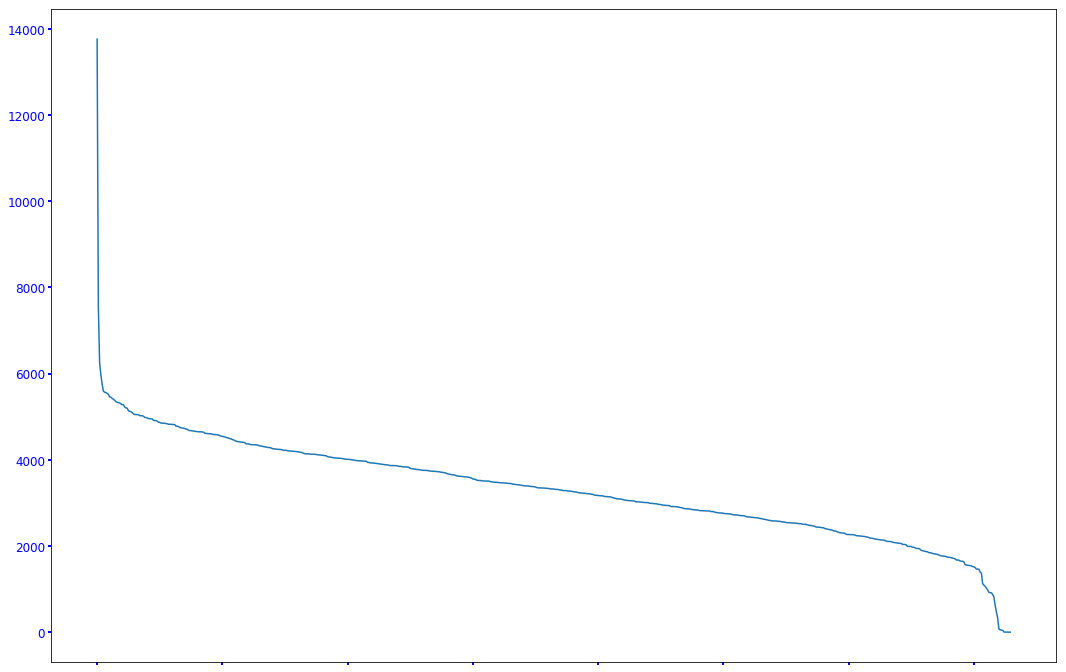

In [102]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=3, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
df_lemmas['_drawer'].value_counts().plot()

Fixing ambiguous information for two typists with same abbreviation:

- Christine Schellhorn (up to drawer 403 – this was her last drawer 
- Sonja Schwaiger (from drawer 636 – this was her first drawer)

In [103]:
df_lemmas[df_lemmas['_typist'] == 'Christine Schellhorn']['_drawer'].unique()

array(['HK 157', 'HK 000', 'HK 165', 'HK 170', 'HK 176', 'HK 188',
       'HK 240', 'HK 225', 'HK 234', 'HK 243', 'HK 255', 'HK 263',
       'HK 270', 'HK 276', 'HK 281', 'HK 290', 'HK 296', 'HK 301',
       'HK 311', 'HK 318', 'HK 324', 'HK 332', 'HK 334', 'HK 339',
       'HK 347', 'HK 353', 'HK 361', 'HK 376', 'HK 383', 'HK 389',
       'HK 403', 'HK 636', 'HK 652', 'HK 665', 'HK 673', 'HK 687',
       'HK 703', 'HK 708', 'HK 724', 'HK 729', 'HK 735', 'HK 739',
       'HK 749', 'HK 755', 'HK 765', 'HK 771', 'HK 780', 'HK 789',
       'HK 795', 'HK 804', 'HK 812', 'HK 821', 'HK 831', 'HK 836',
       'HK 844', 'HK 854', 'HK 856', 'HK 858', 'HK 867', 'HK 870',
       'HK 881'], dtype=object)

In [104]:
drw = df_lemmas[df_lemmas['_typist'] == 'Christine Schellhorn'].index

func = lambda x:int(x[3:])
for idx in drw:
    x = df_lemmas.loc[idx,'_drawer']
    if func(x) > 500:
        df_lemmas.loc[idx]['_typist'] = 'Sonja Schwaiger'

In [105]:
df_lemmas['_typist'].sort_values().value_counts()

Barbara Piringer          375962
Claudia Hareter-Kroiss    253213
Monika Platzer            211855
Bettina Barabas           186280
Lana Mayer                150502
Renate Eckel              132557
Birgit Hofstetter         117544
Sonja Schwaiger           115656
Eva Pudill                102226
Christian Nedoma           93332
Monika Ranftl              92024
Christine Schellhorn       78757
Bettina Fürst              77013
Angelika Eisenhut          72959
Berthold Föger             69227
Markus Pascher             52137
Sybille Groh               48845
Karin Kupitz               45738
Barbara Konate             34644
Marianne Pühringer         31013
Christine Hager            24985
Tamara Loitfellner         17048
Veronika Gasser            12159
Manfred Lagler             10409
Johanna Grützbauch          7464
Reinhard Bachmaier          2823
Name: _typist, dtype: int64

In [106]:
df_lemmas[['_typist',
           'hauptlemma_normalized',
           'hauptlemma_orig',
           'hauptlemma_unique',
           'nebenlemma_normalized',
           'nebenlemma_orig',
           'nebenlemma_unique',]].groupby(['_typist']).count()

,hauptlemma_normalized,hauptlemma_orig,hauptlemma_unique,nebenlemma_normalized,nebenlemma_orig,nebenlemma_unique
_typist,,,,,,
Angelika Eisenhut,38782,38782,29119,2105,2106,806
Barbara Konate,19996,19997,13225,1386,1386,705
Barbara Piringer,217140,217500,155106,22702,22708,18446
Berthold Föger,39013,39013,26843,1688,1688,1370
Bettina Barabas,101220,101222,61244,2526,2531,1327
Bettina Fürst,44793,44793,25618,5265,5265,1835
Birgit Hofstetter,63571,63571,46441,9895,9895,5501
Christian Nedoma,51119,51120,39292,5376,5376,3522
Christine Hager,15853,15853,6907,1378,1383,683


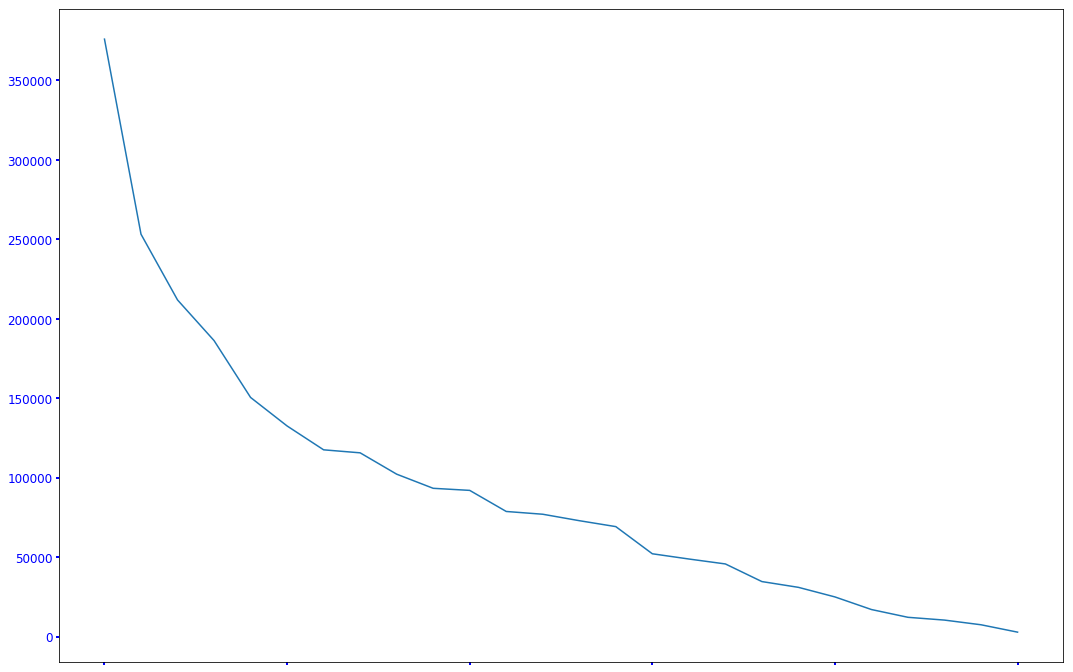

In [107]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=3, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
df_lemmas['_typist'].value_counts().plot()

#### 4) number of headwords per letter

In [108]:
headwords_idx = set(list(df_lemmas.hauptlemma_unique.dropna().index) \
                + list(df_lemmas.hauptlemma_normalized.dropna().index) \
                + list(df_lemmas.hauptlemma_orig.dropna().index) \
                + list(df_lemmas.nebenlemma_unique.dropna().index) \
                + list(df_lemmas.nebenlemma_normalized.dropna().index) \
                + list(df_lemmas.nebenlemma_orig.dropna().index))

In [109]:
headwords_list = []

for idx in headwords_idx:
    if df_lemmas.hauptlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_unique.iloc[idx])
    elif df_lemmas.hauptlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_normalized.iloc[idx])
    elif df_lemmas.hauptlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.hauptlemma_orig.iloc[idx])
    elif df_lemmas.nebenlemma_unique.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_unique.iloc[idx])
    elif df_lemmas.nebenlemma_normalized.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_normalized.iloc[idx])
    elif df_lemmas.nebenlemma_orig.iloc[idx]:
        headwords_list.append(df_lemmas.nebenlemma_orig.iloc[idx])
        
first_letter = [x[0].upper() for x in headwords_list]

In [110]:
freq_letters = nltk.FreqDist(first_letter)

freq_letters.pop('(')
freq_letters.pop(' ')
freq_letters.pop('←')
freq_letters.pop('[')
freq_letters.pop(':')
freq_letters.pop('^')
freq_letters.pop('?')
freq_letters.pop('1')
freq_letters.pop('2')
freq_letters.pop('6')
freq_letters.pop('─')
freq_letters.pop('†')
freq_letters.pop('~')
freq_letters.pop('|')
freq_letters.pop('\xa0')

freq_letters.most_common(50)

[('S', 373210),
 ('G', 192629),
 ('F', 190978),
 ('H', 189854),
 ('K', 180359),
 ('A', 162978),
 ('W', 122670),
 ('M', 107322),
 ('R', 104967),
 ('L', 101267),
 ('P', 90019),
 ('Z', 85329),
 ('T', 74090),
 ('E', 71092),
 ('D', 61183),
 ('N', 54603),
 ('U', 33973),
 ('J', 21494),
 ('O', 21345),
 ('B', 13719),
 ('Ü', 11380),
 ('I', 9663),
 ('Ë', 7563),
 ('Ê', 5051),
 ('Ô', 3280),
 ('Q', 2768),
 ('Ö', 2668),
 ('Â', 1275),
 ('Ä', 1132),
 ('V', 324),
 ('C', 98),
 ('Û', 82),
 ('X', 62),
 ('Y', 34),
 ('Á', 14),
 ('Å', 9),
 ('Ú', 3),
 ('!', 3),
 ('SS', 3),
 ('Ó', 2),
 ('9', 2),
 ('É', 1),
 ('Î', 1),
 ('+', 1),
 ('Ǎ', 1),
 ('Ē', 1),
 ('5', 1),
 ('*', 1),
 ('¹', 1),
 ('Í', 1)]

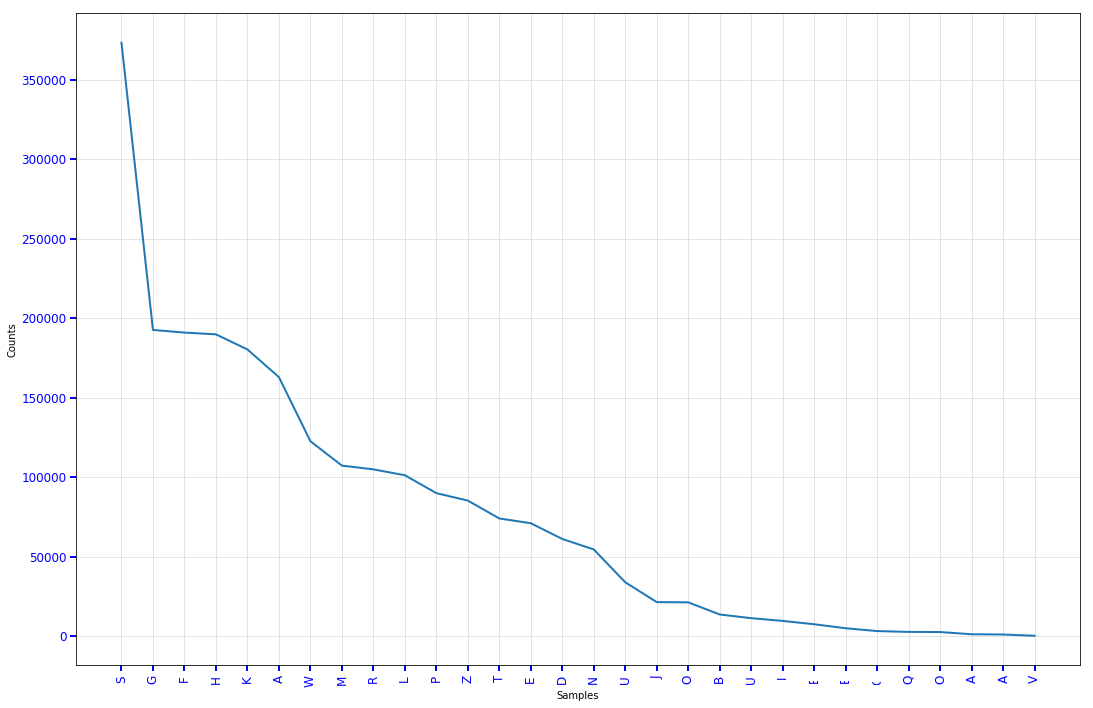

In [111]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', length=6, width=2, colors='b', grid_color='r', grid_alpha=0.5, labelsize='large')
freq_letters.plot(30,cumulative=False,)

#### 5) number of headwords per location

In [112]:
print(len(set(df_lemmas.Bundesland.dropna().index)))
print(len(set(df_lemmas.Ort.dropna().index)))
print(len(set(df_lemmas.Bundesland.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))))

1316889
1198447
1198447


In [113]:
# there is no intersection between records with simple placenames and records with original placenames
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.orig_placeName.dropna().index))

set()

In [114]:
# and there is no intersection between records with simple placenames and records with Ort information
set(df_lemmas.simple_placeName.dropna().index).intersection(set(df_lemmas.Ort.dropna().index))

set()

In [115]:
locations_idx = set(df_lemmas.simple_placeName.dropna().index)\
.union(set(df_lemmas.Ort.dropna().index))\
.union(df_lemmas.orig_placeName.dropna().index)

In [116]:
locations_list = []

for idx in locations_idx:
    if df_lemmas.simple_placeName.iloc[idx]:
        locations_list.append(df_lemmas.simple_placeName.iloc[idx])
    elif df_lemmas.Ort.iloc[idx]:
        locations_list.append(df_lemmas.Ort.iloc[idx])
    elif df_lemmas.orig_placeName.iloc[idx]:
        locations_list.append(df_lemmas.orig_placeName.iloc[idx])

In [117]:
freq_locations = nltk.FreqDist(locations_list)
freq_locations.most_common(50)

[('Wien', 71263),
 ('Mühlheim am Inn', 34694),
 ('(Leimsgrub u. Moarhäuser in Gm.) Schönbg. BöW', 33278),
 ('Gmunden', 33056),
 ('Kautzen', 32858),
 ('Kufstein', 21403),
 ('Linz', 21282),
 ('Plattetschl. BöW', 20835),
 ('Thiersee $Tiersee$', 20598),
 ('Poysdorf', 19641),
 ('Rangersdorf', 16430),
 ('Stainz', 16174),
 ('(Umg./Bz.) Braunau OÖ', 15722),
 ('Traun', 15627),
 ('Dunkelsteinerwald', 15541),
 ('Hohenfurth SBö.', 15374),
 ('Königswerth Egerld.', 14392),
 ('Fusch an der Großglocknerstraße', 13364),
 ('Puchberg am Schneeberg', 12969),
 ('Obermösel in Gm. Mösel Gott.(Slow.)', 12555),
 ('Pottendorf', 12501),
 ('Fendels', 11318),
 ('Kleinlobming', 11088),
 ('Sonnbg. SBö.', 10836),
 ('Straßburg', 10781),
 ('Ulrichsberg', 10609),
 ('Tullnitz SMä.', 10286),
 ('Rohr im Gebirge', 10276),
 ('Herzogenburg', 10084),
 ('Imst', 9854),
 ('Pilgersdorf', 9769),
 ('Gr.Tajax SMä.', 9579),
 ('Kumrowitz Brünn (Tschech.)', 9416),
 ('St. Gilgen', 9103),
 ('Hollabrunn', 8843),
 ('Gr.Arlt. in Sa.', 8769),

#### 6) average number of entries per headword

In [118]:
freq_words = nltk.FreqDist(headwords_list)
freq_words.most_common(50)

[('gên', 9039),
 ('kemmen', 5883),
 ('Hand', 5088),
 ('Haut', 4253),
 ('Kopf', 3931),
 ('Leib', 3790),
 ('Zand', 3671),
 ('sein', 3283),
 ('sehen', 3267),
 ('lich', 3200),
 ('tuon', 3131),
 ('rôt', 2773),
 ('klein', 2636),
 ('halten', 2617),
 ('Hâr', 2573),
 ('Nase', 2375),
 ('schwarz', 2308),
 ('ziehen', 2261),
 ('Hôhzeit', 2230),
 ('haben', 2208),
 ('schlagen', 2190),
 ('faren', 2171),
 ('machen', 2023),
 ('können', 2012),
 ('Mann', 1987),
 ('ein', 1975),
 ('lâßen', 1960),
 ('Maul', 1952),
 ('schwellen', 1945),
 ('guot', 1941),
 ('gëben', 1924),
 ('Georg', 1902),
 ('schön', 1878),
 ('Ort', 1859),
 ('Stein', 1847),
 ('schneiden', 1825),
 ('Fleisch', 1796),
 ('kurz', 1749),
 ('ër', 1736),
 ('Kind', 1732),
 ('helfen', 1687),
 ('Haus', 1685),
 ('schwär', 1683),
 ('Finger', 1672),
 ('ê', 1652),
 ('lang', 1628),
 ('schauen', 1613),
 ('grôß', 1608),
 ('Schneider', 1597),
 ('weiß', 1581)]

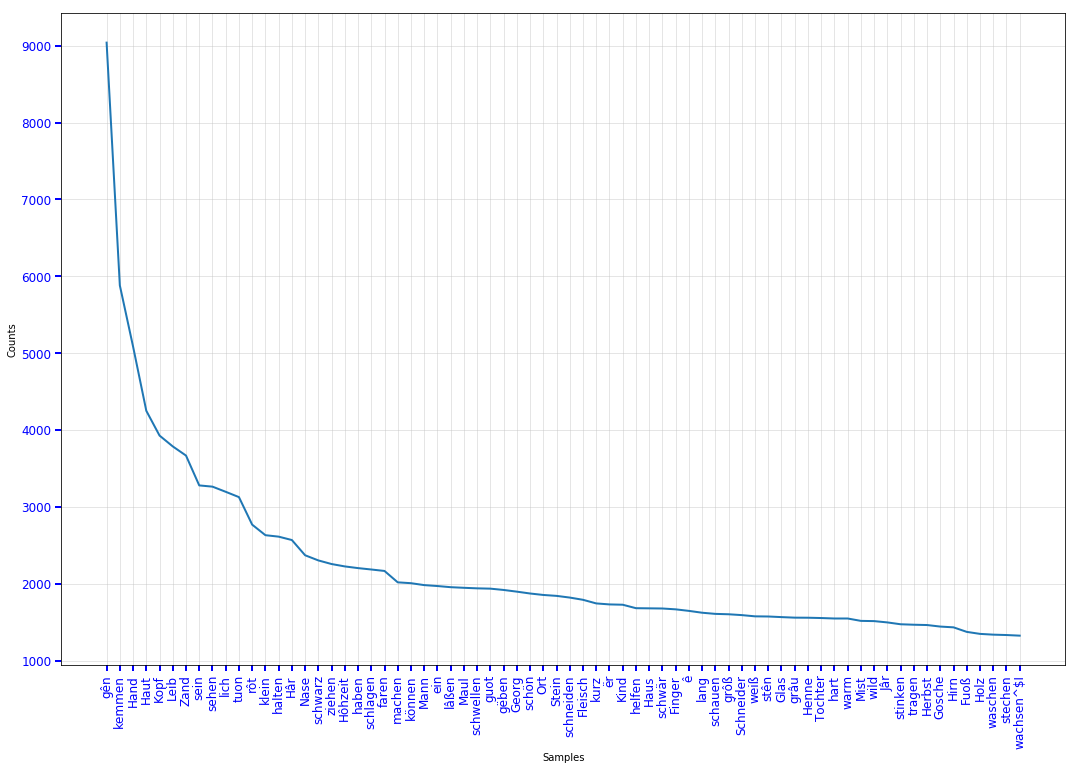

In [119]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', 
               length=6, 
               width=2, 
               colors='b', 
               grid_color='r', 
               #labelrotation=45,
               grid_alpha=0.5, 
               labelsize='large')

freq_words.plot(70,cumulative=False,)

In [120]:
len(headwords_list)/len(freq_words)

9.61762763716607

#### 7) number of different definitions / meanings

#### 8) number of locations cited

In [121]:
len(freq_locations)

27542

In [122]:
for col in regions_info:
    print(col, '--->', len(df_lemmas[col].unique()))

Bundesland ---> 10
Bundesland_idno ---> 10
Gemeinde ---> 1147
Großregion ---> 33
Großregion_idno ---> 32
Kleinregion ---> 324
Kleinregion_idno ---> 322
Ort ---> 1146
Ort_idno ---> 1147
simple_placeName ---> 25494
orig_placeName ---> 4437
placeName_id ---> 1308
usg_corresp ---> 21


In [123]:
#fine grained locations --> Ort + simple placename + original placename
len(set(df_lemmas.Ort).union(set(df_lemmas.simple_placeName)).union(df_lemmas.orig_placeName))

30231

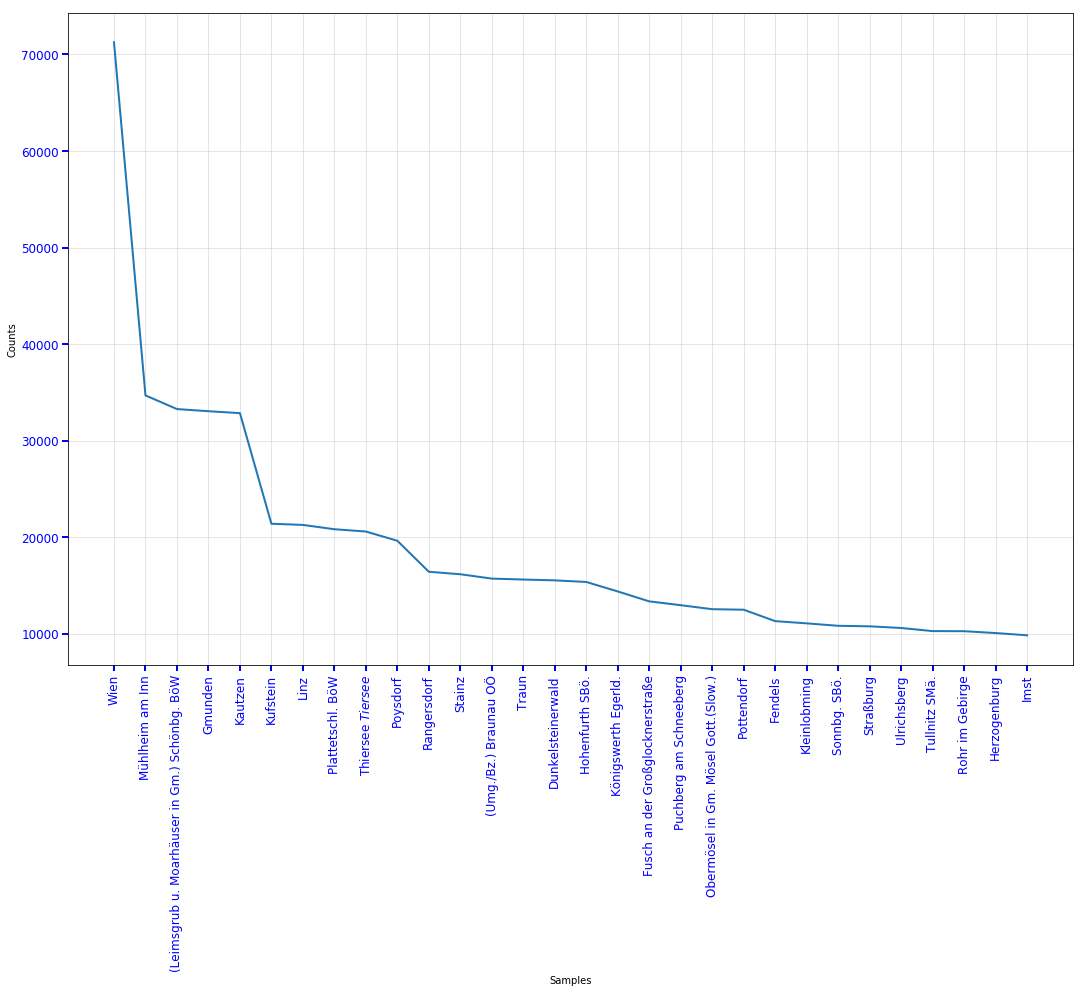

In [124]:
figure, ax = plt.subplots(figsize=(18, 12))
ax.tick_params(direction='out', 
               length=6, 
               width=2, 
               colors='b', 
               grid_color='r', 
               #labelrotation=45,
               grid_alpha=0.5, 
               labelsize='large')

freq_locations.plot(30,cumulative=False,)

#### 9) number of sources cited

#### 10) number of different people cited

#### 11) number of headwords per person

#### 12) number of entries per person

#### 13) number of concepts per questionnaire

#### 14) number of headwords related to questionnaire

In [125]:
df_lemmas.fragebogenNummer.value_counts()

23I6b: Haut m. Adj., Syn. (behaart/Pelz, gelbl.,*); Zshg. Hautfarbe-Haarfarbe/Charakter?                       2707
1A20: Kopf/Schädel als Gw. (Weiberkopf)                                                                        2382
1A3: Kopf/Haupt (übertr.) in Vergl./Ra.                                                                        2286
21C8: Fleisch best.Lebewesen (Heiden-*, Hirsch-,*)                                                             2262
1E12: Backenstreich/Ohrfeige; leicht/stark/schallend                                                           2047
20B2: Blut m. Vb. (es rinnt/hämmert; B. verlieren,*)                                                           2013
43A54b: kommen m. Ziel-/Ortsang. (aus d.Sinn k.,*)                                                             1982
1H1: Mund/Maul; Füg./Ra.                                                                                       1956
42A13d: gehn m. Ziel-/Ortsang. (fortg.; aufs Land g.;*)                 

In [32]:
condition = df_lemmas['fragebogenNummer'].dropna().str.contains("EFb")
idx1 = set(df_lemmas['fragebogenNummer'].dropna()[condition].index)
len(df_lemmas['fragebogenNummer'][idx1])

156043

In [34]:
condition = df_lemmas['fragebogenNummer'].dropna().str.contains("MüWi")
idx2 = set(df_lemmas['fragebogenNummer'].dropna()[condition].index)
len(df_lemmas['fragebogenNummer'][idx2])

755

In [38]:
idx3 = set(df_lemmas['fragebogenNummer'].dropna().index)
idx3 = idx3 - idx1
idx3 = idx3 - idx2
len(df_lemmas['fragebogenNummer'][idx3])

1140338

In [39]:
df_lemmas['_fragebogen'] = None
df_lemmas.loc[idx1,'_fragebogen'] = 'Additional'
df_lemmas.loc[idx2,'_fragebogen'] = 'Geographic'
df_lemmas.loc[idx3,'_fragebogen'] = 'Systematic'

In [43]:
df_lemmas['_fragebogen'].value_counts(dropna=False)

Systematic    1140338
NaN           1119363
Additional     156043
Geographic        755
Name: _fragebogen, dtype: int64

In [40]:
print('Systematic: ', df_lemmas[df_lemmas['_fragebogen'] == 'Systematic']['_bestlemma'].value_counts().count())
print('Additional: ', df_lemmas[df_lemmas['_fragebogen'] == 'Additional']['_bestlemma'].value_counts().count())
print('Geographic: ', df_lemmas[df_lemmas['_fragebogen'] == 'Geographic']['_bestlemma'].value_counts().count())

Systematic:  118269
Additional:  7849
Geographic:  447


#### 15) number of headwords related to questions

#### 16) number of entries related to questions related to authors of questions/questionnaires

#### 17) number of headwords related to questions related to authors of questions/questionnaires

#### 18) number of locations per person (that is identified)

#### 19) number of female:male collectors

#### 20) average number of entries per questions

#### 21) number of entries related to questionnaires

In [136]:
df_lemmas['_fragebogen'].value_counts()

Systematic    1140338
Additional     156043
Geographic        755
Name: _fragebogen, dtype: int64

#### 22) number of entries related to historical sources

#### 23) number of entries related to historical poetic sources

#### 24) number of entries related to "free collections"

#### 25) number of people working on the collection since the start

#### 26) names of people working on the collection since the start

#### 27) number of collectors per questionnaire

#### 28) average number of definitions per entry / paper slip

#### 29) average number of entries per person

#### 30) average number of headwords per person

#### 31) average number of entries per type of location

#### 32) average number of headwords per type of location

#### 34) persons sorted by the number of headwords (and a list of those headwords) that are least frequent in the corpus

#### 35) headwords sorted by frequency

#### 36) headwords sorted by frequency related to certain types of regions (e.g AT., bundesland, smallest regional unit, municipality)

#### 37) number of entries with time information

In [137]:
for year in df_lemmas.date.unique():
    print(year)

None
16.Jh.
1730
1363
1405
15.u.16.Jh.
17.Jh.
1549
Anf.15.Jh.
1399
Mitte 15.Jh.
vor 1483
1266
1431
1387
1392
1401
1495
15./16.Jh.
Mitte 16.Jh.
1705
1585
1513
O 1387
1759
1734
O 1642
1778
1623
1560-1594
2.Hä.16.Jh.
um 1600
1500
1607
1588
1587
1754
1597
1667
1507
1574
15.Jh.
1572
1745
1578
1380
O 1394
1512
15.6. 1575
1621
1467
1590
1492
1434
1732
1493-1523
1699
1648-1658
1.Hä.18.Jh.
1342
1297
1441
1515
1550
1772
O 1563
Mitte d.15.Jh.
1679
18.Jh.
1581
1376
1629
1630
C kais.Komm. 1607
1623; 1699
16.-18.Jh.
1608; 1651 [?]
1682
1715
4.2.1308
a. 1494
1701
1418-1454
a. 1580
1345
1290
1460
16. jh.
1465
a. 1426
1354
1509
1532
1463
1477
18. jh.
14.6.1621
1258
17. jh.
1564
a. 1431
19. 4. 1575
1284
1291
1375
1372
1323
1563
[24.3.] 1568
1188-93, C 13. Jh.
1521
1648
a. 1582
15. jh.
a. 1613
a. 1520
a. 1484
1668
1573
a. 1528
Mitte 16. Jh.
17.jh.
16.jh.
1436
14. Jh.
1427
vor 1621
a. 1565
1583
a. 1726
1. H. 16. Jh.
1. Hä. 16. Jh.
Jänner 1951
1494
vor 1511?
6.8.1592
1523
1581-95
1555-90
20.6.1567
1337
177

(vor 1127)
O 1680
O o.J., ca. 1592
15.12.1546
C 1482O 1466
o.J.
9.9.28
4.9.1928
1379,1427
1257
1490 (1419?)
17.1.1842
Übers.1470
Konz 1477
15541549
Konz.1478; O 1507, O 1533
16.u.17.Jh.
12.2.25
schon 1520
Aug.1913
1083
1058
1226
1171
1195
1209
1246
1268
23. 8. 1639
1703
27.7.1415
18. Jhd. (1768)
(vor 11.4.) 1597
30.11. 1299
1838
[90 jährige Frau]
1729
1906; 1665
August 1951
2.10.1982
ca. 1530
Anf. 16. Jh.
1908
2.8.1449
25. Juli 1240
Orig. aus 1306
23.5.1366
14.4.1288
Vidim. 1384
1848
1931
1658,1715
1659
28.2.94
1904
20.3.1921
27.6.1361
22.8.1982
6.12.27
15.7.1562
5.7.1311
1978
18.6.1518
17. Jh
ab 1774
seit ca. 1920
nach 1918
1900
2.Hä.18.Jh.
19351935
17.u.18.Jh.
1711-1719
1962
1891
O.1642
seit 14.Jh.
6.Aug.1921
28.10.1928
28.2.1959
25.11.1981
2.5.1981
16. 9. 1926
15.Jh.?
1695-1780
1914
12.Febr.1928
5.XI.31
Aug.1951
seit 1369
Anf 15.Jh.
14371439
1658 u.a.
1580-95
1587-95
6. 8. 1592
1591-1595
1689 u.a.J.
1582-1585
1578 29/ 3
24.8.1414
10.1.1573
1898
17.1.1745
26.2.1327
1633
12.8.1640
188

8. 3. 1925
9. 8. 1928
1554-88
31. 1. 1933
16. 2. 1925
O. 1507
März 1952
28. 2. 1929
4. 10. (1929)
Oktober 1952
C 1500>1420
ca. 1526
14. 5. 1612
O1400
1560-1580
16./17. Jh.
anno '19
ca. 1960
1169; 1171/72
ca 1300
19.Jg
L.O. v. 1553; v. 1616
(1399)
a. 1399
anno1487
1950/60
O. 1472
O. 1158
O. 147z
O. 29. 10. 1595
O. ca. 1490
C. 1534
B 1560-94
O. 1533
O. 1675
21. 8. 1366
15. 8. 1340
1. 5. 1310
12. 11. 1926
12. 12. 1925
16.3.1571
1852
1. 12. '26
1591-93
aus Timelkam (Hausruck)
Mitte d. 15. Jhrh.
ad 1455
17. 1. 1864
vor 2. Weltkrieg
7. 11. 1572
1684-17091582
2. 6. 1575
1556 3/7
23.5.1925
2. 12. 1926
1. 12. 1926
Wallern
17. 1. 1485
9. 6. 1924
O. 1653
ad 1513
34,12
Oca. 1371
seit 1634
2. Hälfte 16 Jh.
1239
O 1361
1306-1346
16.,17.Jhdt.
a.1443
a.1580
a.1670
a.1758
a.1565
1. Hälfte des 18.Jhdts
a.1532
a.1418
a.1648-1658
Ende 15.Jhdt.
a.1495
a. 1564
(1642)
(1521)
(1465)
a. 1570
1. Hälfte 18.Jhdt.
a.1666
a. 1606
v. 1350
18. 7. 1582
16. / 17. Jh.
Steyr 2. Hälfte 16. Jh.
c. 1607
O. 1595
vor 70 Jahre

In [138]:
df_lemmas.date.value_counts()

17.Jh.                     738
16.Jh.                     707
1587                       634
1623                       631
15.Jh.                     567
16. Jh.                    498
17. Jh.                    486
1550                       486
1581                       462
1532                       455
1969                       431
1463                       400
1368                       388
15. Jh.                    377
1498                       345
1465                       329
1553                       319
1367                       311
1590                       304
1454                       304
1573                       302
1467                       292
1494                       291
1365                       287
1460                       274
1621                       262
1624                       260
1370                       257
1514                       256
1699                       254
                          ... 
bald nach 1600               1
15./16. 

Substituting references to centuries with the middle of the century (e.g. 16.Jh. ---> 1650)

In [139]:
df_lemmas['_year'] = df_lemmas['date'].str.extract('([0-9]{4})', expand=True)
df_lemmas['_year'].sort_values().value_counts()

1587    653
1623    641
1550    533
1581    480
1532    473
1648    443
1969    434
1463    409
1368    394
1590    374
1465    371
1460    366
1553    365
1498    349
1621    335
1454    318
1367    315
1418    314
1573    312
1467    306
1494    302
1365    289
1400    287
1624    279
1560    272
1361    265
1370    260
1514    258
1513    258
1699    257
       ... 
1998      1
1158      1
1012      1
1017      1
1185      1
1184      1
1198      1
1103      1
1078      1
1113      1
1059      1
1088      1
1261      1
1174      1
1216      1
1205      1
1231      1
1999      1
1230      1
0132      1
1106      1
1069      1
1196      1
1282      1
1149      1
2008      1
1080      1
1273      1
1267      1
1138      1
Name: _year, Length: 865, dtype: int64

In [140]:
df_lemmas['_year'] = df_lemmas['date'].str.extract('(1[0-9]{1}[\s.]+[JjHh.]{2,})', expand=True)
df_lemmas['_year'].sort_values().value_counts()

16.Jh.     1051
16. Jh.     794
17.Jh.      783
15.Jh.      645
17. Jh.     521
15. Jh.     422
18.Jh.      266
17.jh.      239
16. jh.     224
16.jh.      210
17. jh.     202
18. Jh.     199
15. jh.     169
15.jh.      153
14.Jh.      105
14. Jh.     102
16.Jh        78
18.jh.       62
16. Jh       58
15.Jh        56
18. jh.      49
17.Jh        48
15. Jh       44
17. Jh       39
14. Jh       31
18.Jh        25
14.Jh        25
18. Jh       24
16 Jh.       18
16 Jh        16
           ... 
18.jh         2
12. Jh.       2
17 Jh         2
17.jh         2
17.JH.        2
18 Jh.        2
13.Jh         2
19.Jh         2
15. jh        2
11.Jh.        2
15.jh         2
14 Jh.        2
16.jh         1
13.jh.        1
12.Jh         1
10 Jh.        1
12 Jh         1
16. JH.       1
14. Hh        1
13. Jh        1
18 JH         1
19.jh.        1
15 .Jh.       1
11. Jh.       1
18 Jh         1
16 jh.        1
14. jh        1
10.Jh.        1
18. jh        1
18 jh         1
Name: _year, Length: 78,

In [142]:
df_lemmas[df_lemmas['_year'].isna()]['date'].value_counts()

1587                                                                                                                                       634
1623                                                                                                                                       631
1550                                                                                                                                       486
1581                                                                                                                                       462
1532                                                                                                                                       455
1969                                                                                                                                       431
1463                                                                                                                                       400

In [143]:
df_lemmas['date'].str.extract('(1[0-9]{1}[\s.]+[JjHh.]{2,})', expand=True)[0].unique()

array([nan, '16.Jh.', '17.Jh.', '15.Jh.', '18.Jh.', '16. jh.', '18. jh.',
       '17. jh.', '13. Jh.', '15. jh.', '16. Jh.', '17.jh.', '16.jh.',
       '14. Jh.', '14.Jh', '13.Jh.', '15.jh.', '15. Jh.', '14.Jh.',
       '15. Jh', '17. Jh.', '18. Jh', '14. jh.', '18. Jh.', '15.Jh',
       '18.Jh', '16.Jh', '17 jh.', '18.jh.', '17.Jh', '14.jh.', '18 jh.',
       '16. Jh', '19.Jh.', '12.Jh.', '19.jh.', '17 Jh.', '14. Jh',
       '16 Jh', '17. Jh', '15 Jh', '17.JH.', '16 Jh.', '11.Jh.', '18 Jh.',
       '18 JH', '18 Jh', '19. Jh.', '15 Jh.', '16. JH.', '14. Hh',
       '17.jh', '15. jh', '19.Jh', '18.jh', '12 Jh', '15 jh.', '13.Jh',
       '10 Jh.', '12. Jh.', '10. Jh.', '19. Jh', '16 jh.', '13.jh.',
       '15.jh', '12.Jh', '10.Jh.', '15 jh', '16. jh', '17 jh', '14. jh',
       '18 jh', '17 Jh', '14 Jh.', '18. jh', '13. Jh', '15 .Jh.', '16.jh',
       '11. Jh.'], dtype=object)

#### 38) average number of entries per collection

#### 39) percentage of headwords in a certain location per person

#### 40) percentage of plant names per letter  

In [144]:
len(df_lemmas) - len(locations_idx)

686299

#### Exporting the Enriched Dataframe

In [14]:
df_lemmas.to_pickle('./df_lemmas.pkl')

#### Building a SQLite Database

In [25]:
conn = sqlite3.connect('./lemmas_db.sqlite')

In [16]:
df_lemmas.applymap(str).head()

,Bundesland,Bundesland_idno,Gemeinde,Großregion,Großregion_idno,Kleinregion,Kleinregion_idno,Ort,Ort_idno,archiv,...,tustep,usg_corresp,verweise,_coordinates,_location,_typist,_drawer,_fragebogen,_bestlemma,_year
0,None,None,None,None,None,None,None,None,None,"HK 154, d154^#1.1 = d1540308.pir^#1.1",...,"('diaun',)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,nan
1,None,None,None,None,None,None,None,None,None,"HK 154, d154^#2.1 = d1540308.pir^#2.1",...,"('diaun',)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,nan
2,None,None,None,None,None,None,None,None,None,"HK 154, d154^#3.1 = d1540308.pir^#3.1",...,"('diaun',)",None,None,None,None,Barbara Piringer,HK 154,None,Diaun,nan
3,None,None,None,None,None,None,None,None,None,"HK 154, d154^#4.1 = d1540308.pir^#4.1",...,"('tib',)",None,None,None,None,Barbara Piringer,HK 154,Systematic,tib,nan
4,None,None,None,None,None,None,None,None,None,"HK 154, d154^#5.1 = d1540308.pir^#5.1",...,"('tib',)",None,None,None,None,Barbara Piringer,HK 154,Systematic,tib,nan


In [17]:
df_lemmas.applymap(str).to_sql(name='lemmas', con=conn)

In [26]:
cur = conn.cursor()

In [19]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('lemmas',)]


In [22]:
q = '''
select _typist, _drawer, _fragebogen, _bestlemma  from lemmas limit 40;
'''

In [27]:
cur.execute(q)
for entry in cur.fetchall():
    print(entry)

('Barbara Piringer', 'HK 154', 'None', 'Diaun')
('Barbara Piringer', 'HK 154', 'None', 'Diaun')
('Barbara Piringer', 'HK 154', 'None', 'Diaun')
('Barbara Piringer', 'HK 154', 'Systematic', 'tib')
('Barbara Piringer', 'HK 154', 'Systematic', 'tib')
('Barbara Piringer', 'HK 154', 'Systematic', 'tib')
('Barbara Piringer', 'HK 154', 'Systematic', 'tib')
('Barbara Piringer', 'HK 154', 'None', 'Diebede')
('Barbara Piringer', 'HK 154', 'None', 'Diebede')
('Barbara Piringer', 'HK 154', 'None', 'Diebede')


In [24]:
conn.close()